# Autores:
- **Andressa dos santos Silva**
- **Alexsandro Da Silva Bezerra**
- **Alexandre Da Cunha Fernandes**
- **Breno Henrique Reys Lorenzo**
- **Leonardo De Jesus Andrade**
- **Raphael Imperator Cavicchia Fleury**

# **Importações das bibliotecas**

In [ ]:
import requests
from bs4 import BeautifulSoup
import spacy
import networkx as nx
from itertools import combinations
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
nlp = spacy.load("pt_core_news_lg")

In [ ]:
def coletar_texto(url):
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, "html.parser")
    conteudo = soup.find("div", class_="mc-article-body")
    if conteudo:
        texto = " ".join([p.get_text() for p in conteudo.find_all("p")])
    else:
         texto = "Erro: Conteúdo da notícia não encontrado na página do G1"

    return texto

**A função coletar_texto recebe como entrada uma URL e tenta extrair o texto principal de uma notícia publicada no site G1**

Primeiro, a função usa requests.get para enviar uma requisição ao endereço indicado. O cabeçalho User-Agent é definido para imitar um navegador (Mozilla/5.0), o que ajuda a evitar bloqueios simples por parte do servidor.

Depois de receber a resposta, o conteúdo bruto da página (response.content) é passado ao BeautifulSoup, que cria um objeto soup capaz de navegar pela estrutura HTML de forma mais intuitiva.

Com o objeto soup, a função procura a div que tenha a classe "mc-article-body", pois é nela que o G1 costuma colocar o corpo das notícias. Se essa divisão existir, ela é armazenada em conteudo.

Caso conteudo não seja None, o código percorre todas as tags p dentro dessa div, obtém apenas o texto de cada parágrafo (com get_text()) e junta tudo em uma única string, separando por espaços.

Se a div com a classe esperada não for encontrada, significa que o layout da página é diferente ou o artigo não existe. Nesse caso, a função retorna uma mensagem de erro informando que o conteúdo não foi localizado.

Finalmente, a variável texto que contém todo o corpo do artigo ou a mensagem de erro é devolvida pela função para quem a chamou.

In [ ]:
def construir_grafo(texto):
    doc = nlp(texto)
    palavras_escolhidas = ["chuva","alerta","tempestade","clima","sol","haver","pancada","temperatura","atingir","energia","afetar","informar","forte","fraca","vento","longo","longa","aviso","vermelho","isolar","informação","emergências","climáticas","duração","elevação","temporal","provocar","queda","árvore","luz","chover","atenção","grande","rajada","nublado","baixo","meteorologia","climatempo","extratopical","perigoso","ciclone","potencialmente","previsão","risco","possibilidade","granizo","alagamento","emitir","estrago","transtorno","intensa","mínimas","termômetro","nuvem","nebulosidade","umidade","abafar","raio","elevar","pressão","temporal","máxima","calor","frio","atmosférico","imóvel","ar","seco","previsto","tendência","precipitação","intensificar","fria","blecaute","garoa","frente","chuvisco","prever","medição","quente","calorão","queimada","incêndio","problema","respiratório","poluição","recorde","climático","Queimadas","trânsito","apagão","água","apagado","lentidão","danificar","ocorrer","alagar","desabamento","dano","galho","registrar","meteorológico","luzfalta","falta","chuvisco","céu","formação","nublar","circulação","limpo","chance","milímetro","amanhecer","anoitecer","entardecer","manhã","sensação","inundar","despenca","ameno","análise meteorológica", "variabilidade climática", "nível de alagamento", "desgaste ambiental","ventania", "trovão", "relâmpago", "seca", "seco","sem chover","sem chuva","quentura","onda","perigo", "risco","enchente", "inundação","secura","mormaço"]
    palavras = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.lemma_.lower()  in palavras_escolhidas]

    G = nx.Graph()
    window_size = 2

    for i in range(len(palavras) - window_size + 1):
        window = palavras[i:i + window_size]
        for palavra1, palavra2 in combinations(window, 2):
            if G.has_edge(palavra1, palavra2):
                G[palavra1][palavra2]['weight'] += 1
            else:
                G.add_edge(palavra1, palavra2, weight=1)

    return G


**A função construir_grafo transforma um texto em um grafo de coocorrência de palavras, destacando relações entre termos escolhidos.**

Primeiro, o texto inteiro é passado para o pipeline de linguagem natural (nlp), que retorna um objeto doc contendo tokens (palavras, pontuações etc.) com informações como lema e se são stopwords.

A lista palavras_escolhidas define manualmente termos de interesse referentes ao clima (por exemplo “chuva”, “vento”, “granizo” etc.). O código percorre cada token em doc, transforma-o em seu lemma (forma base) e filtra apenas aqueles que são alfabéticos, não são stopwords e cujo lema aparece em palavras_escolhidas. O resultado é a lista palavras, já lematizada e reduzida ao vocabulário relevante.

Utilizando o NetworkX, a função inicializa um grafo vazio G = nx.Graph(). Esse grafo vai armazenar as palavras como nós e conexões (arestas) entre palavras que ocorrem próximas uma da outra.

Com o parâmetro window_size = 2, a função considera pares de palavras consecutivas. Ela percorre a lista palavras e, para cada posição, pega o par atual de duas palavras (window = palavras[i:i + 2]).

Para cada par (palavra1, palavra2), a função verifica se já existe uma aresta entre esses nós em G.

- Se existir, aumenta o atributo weight (peso) dessa aresta em 1, reforçando a força da coocorrência.

- Se não existir, cria uma nova aresta com weight = 1.

Ao final, a função retorna o objeto G, que representa um grafo não dirigido onde cada nó é uma palavra escolhida e cada aresta reflete quantas vezes as duas palavras apareceram juntas no texto.

In [ ]:
def estatisticas_grafo(G):
    print("\nEstatísticas do Grafo:")
    print(f"Número de Nós: {G.number_of_nodes()}")
    print(f"Número de Arestas: {G.number_of_edges()}")

    graus = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    print("\nGrau dos Nós (em ordem decrescente):")
    for node, degree in graus[:]:
        print(f"Nó: {node}, Grau: {degree}")

    print("\nPeso das Arestas (em ordem decrescente):")
    pesos_arestas = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    for u, v, data in pesos_arestas:
        print(f"Aresta: ({u}, {v}), Peso: {data['weight']}")

    centralidade = nx.betweenness_centrality(G)
    centralidade_ordenada = sorted(centralidade.items(), key=lambda x: x[1], reverse=True)
    print("\nCentralidade de Intermediação dos Nós (Top 10):")
    for node, betw in centralidade_ordenada[:10]:
        print(f"Nó: {node}, Centralidade de Intermediação: {betw:.4f}")

    coef_aglomeracao = nx.average_clustering(G)
    print(f"\nCoeficiente de Aglomeração Médio: {coef_aglomeracao:.4f}")

    comunidades = list(greedy_modularity_communities(G))
    modularidade = nx.algorithms.community.modularity(G, comunidades)
    print(f"Modularidade das Comunidades: {modularidade:.4f}")

**A função estatisticas_grafo recebe um grafo G (instância de NetworkX) e imprime em texto várias métricas que ajudam a caracterizar sua estrutura e importância dos nós.**

Logo no início, ela exibe quantos nós (G.number_of_nodes()) e quantas arestas (G.number_of_edges()) compõem o grafo. Esses valores dão uma ideia geral do seu tamanho e densidade.

Em seguida, a função calcula o “grau” de cada nó isto é, quantas conexões ele possui usando G.degree(). Ela ordena essa lista em ordem decrescente de grau e imprime todos os pares (nó, grau). Quanto maior o grau, mais central ou “conectado” esse termo é no contexto de coocorrência.

Depois, a função lista todas as arestas juntamente com seus pesos (o atributo weight que contamos ao construir o grafo). Ordenadas de forma decrescente, essas informações destacam quais pares de palavras aparecem juntos com maior frequência.

A centralidade de intermediação mede o quanto um nó atua como “ponte” em caminhos mais curtos que conectam outros nós. É calculada por nx.betweenness_centrality(G) e impressa para os 10 nós com valores mais altos. Um nó com alta centralidade de intermediação costuma ser uma palavra de transição ou de conexão entre diferentes grupos de termos.

Usando nx.average_clustering(G), a função calcula o clustering médio isto é, quão provável é que dois vizinhos de um nó também estejam conectados entre si. Valores mais altos indicam presença de “triângulos” no grafo, sinal de coesão local.

Por fim, a função aplica o algoritmo de comunidades por modularidade (greedy_modularity_communities) para agrupar nós que estão mais fortemente interconectados entre si. Em seguida, calcula a qualidade desses agrupamentos com modularity(G, comunidades). A modularidade varia entre –1 e 1 e, de maneira geral, quanto mais próxima de 1, mais bem definidas estão as comunidades.

In [ ]:
def plotar_grafo(G):
    comunidades = greedy_modularity_communities(G)
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=0.15)
    colors = plt.cm.rainbow([i / len(comunidades) for i in range(len(comunidades))])

    for color, comunidade in zip(colors, comunidades):
        nx.draw_networkx_nodes(G, pos, nodelist=comunidade, node_color=[color], node_size=100)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title("Grafo de Co-ocorrência de Palavras")
    plt.show()

**A função plotar_grafo recebe um grafo G e gera
uma visualização gráfica das comunidades de coocorrência de palavras.**

Detecção de comunidades
Primeiro, o algoritmo greedy_modularity_communities identifica grupos de nós (palavras) que estão mais fortemente interligados entre si. Cada “comunidade” corresponde a um conjunto de termos que costumam ocorrer juntos.

Com plt.figure(figsize=(15, 15)), a função cria uma área de desenho quadrada de 15×15 polegadas para garantir que o grafo seja bem legível, mesmo quando há muitos nós.

O layout usado é o spring_layout, que simula molas entre os nós para distribuí-los de forma equilibrada no espaço. O parâmetro k=0.15 controla a distância ideal entre nós: valores menores deixam o grafo mais compacto, valores maiores afastam mais os pontos.

Para diferenciar visualmente cada comunidade, a função gera uma paleta Rainbow usando plt.cm.rainbow. Cada comunidade recebe uma cor distinta proporcional ao seu índice no conjunto de comunidades.

Em seguida, para cada comunidade, chama-se nx.draw_networkx_nodes, passando a lista de nós daquele grupo e a cor atribuída, além de um tamanho fixo (node_size=100). Assim, as palavras pertencentes ao mesmo cluster aparecem pintadas igualmente.

A função traça todas as conexões com nx.draw_networkx_edges, definindo espessura fina (width=0.5) e transparência parcial (alpha=0.5) para não poluir visualmente. Depois, os nomes dos nós (as palavras) são desenhados com nx.draw_networkx_labels, em fonte de tamanho 10.

Por fim, plt.title adiciona um título descritivo à figura, e plt.show() envia o gráfico para a tela. O resultado é um diagrama em que comunidades, relações e a estrutura geral de coocorrência ficam claras de relance.

In [ ]:
def detectar_comunidades(G):
    comunidades = list(greedy_modularity_communities(G))
    for i, comunidade in enumerate(comunidades):
        print(f"Comunidade {i+1}: {', '.join(comunidade)}")

**A função detectar_comunidades identifica e mostra os grupos de palavras mais fortemente conectados no grafo**

Ela usa greedy_modularity_communities(G), que é um método guloso para maximizar a modularidade do grafo. Esse algoritmo tenta agrupar nós de modo que haja muitas arestas dentro de cada grupo e poucas entre grupos diferentes. O resultado é uma lista de conjuntos, onde cada conjunto representa uma “comunidade” de palavras relacionadas.

Como greedy_modularity_communities retorna um iterador, a função converte seu resultado em lista com list(...). Assim, podemos usar índices para numerar cada comunidade.

Em seguida, a função percorre essa lista com enumerate, obtendo o índice i (que será somado de 1 para apresentação mais intuitiva) e o próprio conjunto de nós comunidade. Para cada comunidade, ela imprime uma linha no formato:
Comunidade 1: palavraA, palavraB, palavraC, …

A saída em texto permite analisar rapidamente cada cluster de palavras, ajudando a entender quais temas ou conceitos tendem a aparecer em conjunto no seu conjunto de dados.

# Notícias do **G1 2022**

In [ ]:
urls_G1_2022 = [
"https://g1.globo.com/sp/sao-paulo/noticia/2022/01/30/chuvas-que-atingem-sp-sao-provocadas-por-fenomeno-tipico-do-verao-entenda.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/02/02/no-de-mortos-pelas-fortes-chuvas-em-sp-ja-e-48percent-maior-do-que-o-do-verao-passado.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/03/21/sao-paulo-tem-verao-marcado-por-contraste-entre-chuvas-intensas-e-2o-fevereiro-mais-seco-em-79-anos.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/04/11/semana-em-sp-comeca-com-calor-temperatura-despenca-a-partir-de-quinta-e-feriado-tera-minima-de-10c.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/05/05/cidade-de-sao-paulo-registra-madrugada-mais-fria-do-ano-nesta-quinta-feira-diz-inmet.ghtml",
"https://g1.globo.com/sp/mogi-das-cruzes-suzano/noticia/2022/06/30/junho-termina-com-apenas-376percent-da-chuva-esperada-para-o-mes-nas-represas-do-alto-tiete.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/07/25/cidade-de-sp-tem-o-mes-de-julho-mais-quente-desde-1984.ghtml",
"https://g1.globo.com/hora1/noticia/2022/08/01/agosto-comeca-com-volta-do-calor-e-ar-seco-em-boa-parte-do-pais.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/09/07/apos-feriado-de-chuva-e-frio-cidade-de-sp-tera-dias-de-sol-e-calor-maxima-deve-chegar-aos-32-na-sexta.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/10/04/cidade-de-sp-teve-apenas-48-dias-de-sol-com-temperaturas-acima-de-30oc-neste-ano-diz-levantamento.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/11/07/semana-na-cidade-de-sp-comeca-com-chuvas-isoladas-e-frio-temperatura-sobe-a-partir-de-quarta-feira.ghtml",
"https://g1.globo.com/sp/sao-paulo/noticia/2022/12/21/primavera-2022-em-sp-e-marcada-por-chuvas-intensas-e-grande-amplitude-termica.ghtml"
]

**O loop abaixo faz com que o bloco seja repetido para cada endereço de notícia de 2022 que foi armazenado na lista urls_G1_2022 acima. Assim, todo o processo de extração, análise e visualização é aplicado individualmente a cada página.**

Logo no início de cada iteração, o print(f"\nAnalisando link do ano 2022: {url}") exibe no console qual URL está sendo processada.

A chamada texto = coletar_texto(url) usa a função que vimos antes. Em seguida, usamos a função construir_grafo em G = construir_grafo(texto), plotamos o gráfico com plotar_grafo(G).

Na linha estatisticas_grafo(G), irá imprimir várias métricas sobre o grafo. Por fim, detectar_comunidades(G), irá detectar essas comunidades.

Depois de executar todas essas etapas para uma URL, o loop volta ao for, processa o próximo link e assim por diante, até que todas as URLs de 2022 tenham sido completamente analisadas.

**obs: Esse mesmo loop será utilizado nos links de 2023 e 2024**


Analisando link do ano 2022: https://g1.globo.com/sp/sao-paulo/noticia/2022/01/30/chuvas-que-atingem-sp-sao-provocadas-por-fenomeno-tipico-do-verao-entenda.ghtml


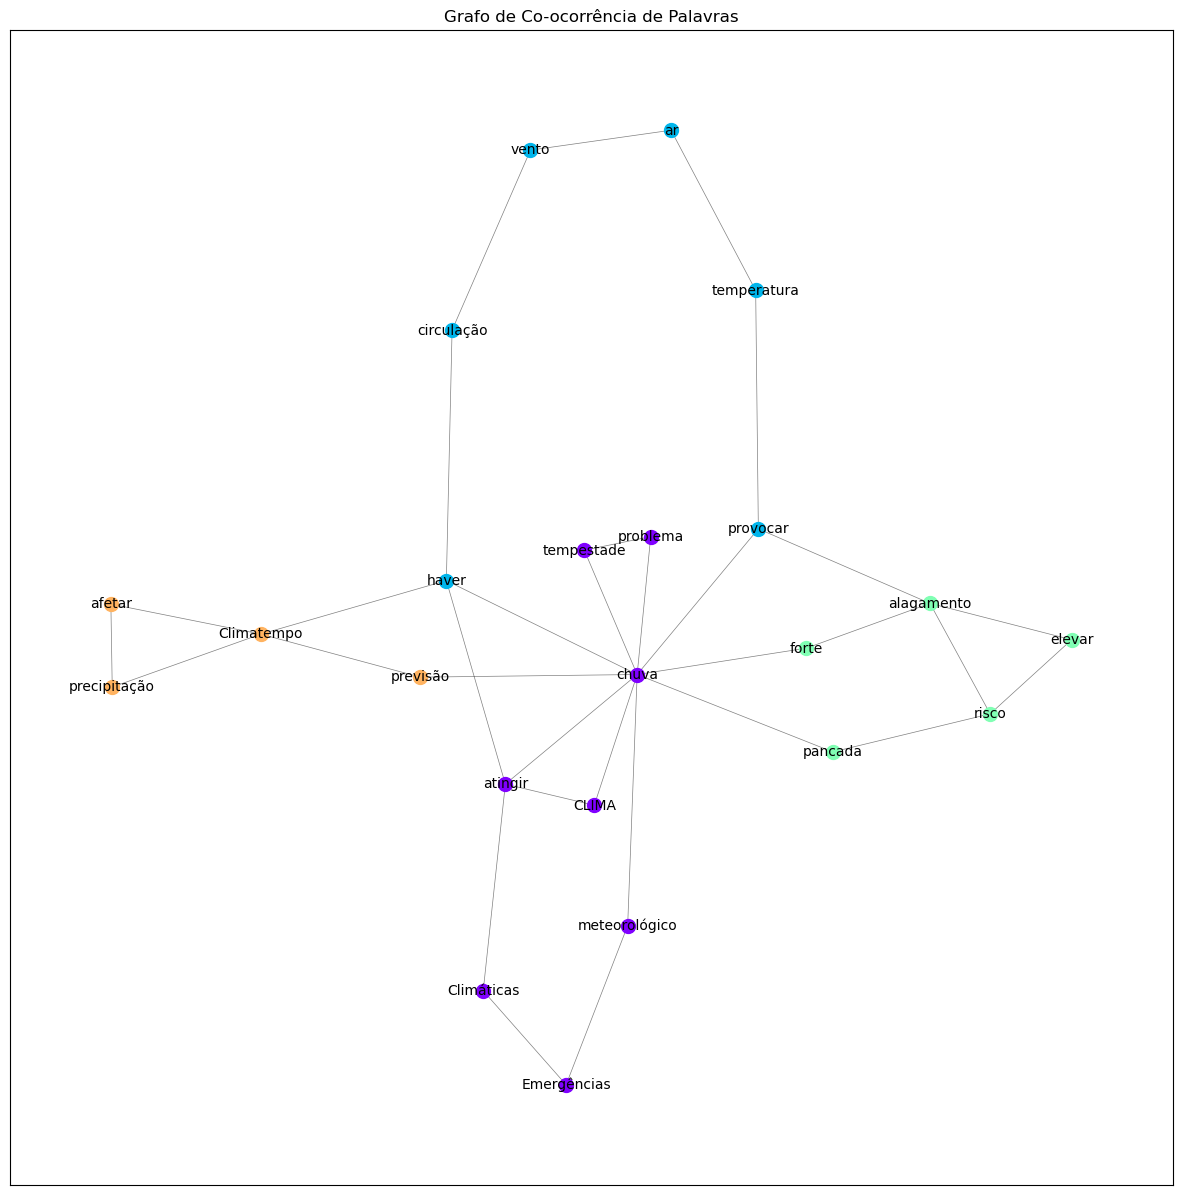


Estatísticas do Grafo:
Número de Nós: 23
Número de Arestas: 32

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 10
Nó: alagamento, Grau: 4
Nó: atingir, Grau: 4
Nó: Climatempo, Grau: 4
Nó: haver, Grau: 4
Nó: provocar, Grau: 3
Nó: risco, Grau: 3
Nó: forte, Grau: 2
Nó: CLIMA, Grau: 2
Nó: previsão, Grau: 2
Nó: afetar, Grau: 2
Nó: precipitação, Grau: 2
Nó: circulação, Grau: 2
Nó: vento, Grau: 2
Nó: ar, Grau: 2
Nó: temperatura, Grau: 2
Nó: tempestade, Grau: 2
Nó: problema, Grau: 2
Nó: meteorológico, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: pancada, Grau: 2
Nó: elevar, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, provocar), Peso: 2
Aresta: (chuva, forte), Peso: 1
Aresta: (chuva, atingir), Peso: 1
Aresta: (chuva, CLIMA), Peso: 1
Aresta: (chuva, previsão), Peso: 1
Aresta: (chuva, tempestade), Peso: 1
Aresta: (chuva, problema), Peso: 1
Aresta: (chuva, meteorológico), Peso: 1
Aresta: (chuva, haver), Peso: 1
Aresta: (chuva, pancada), Peso: 1
Aresta: 

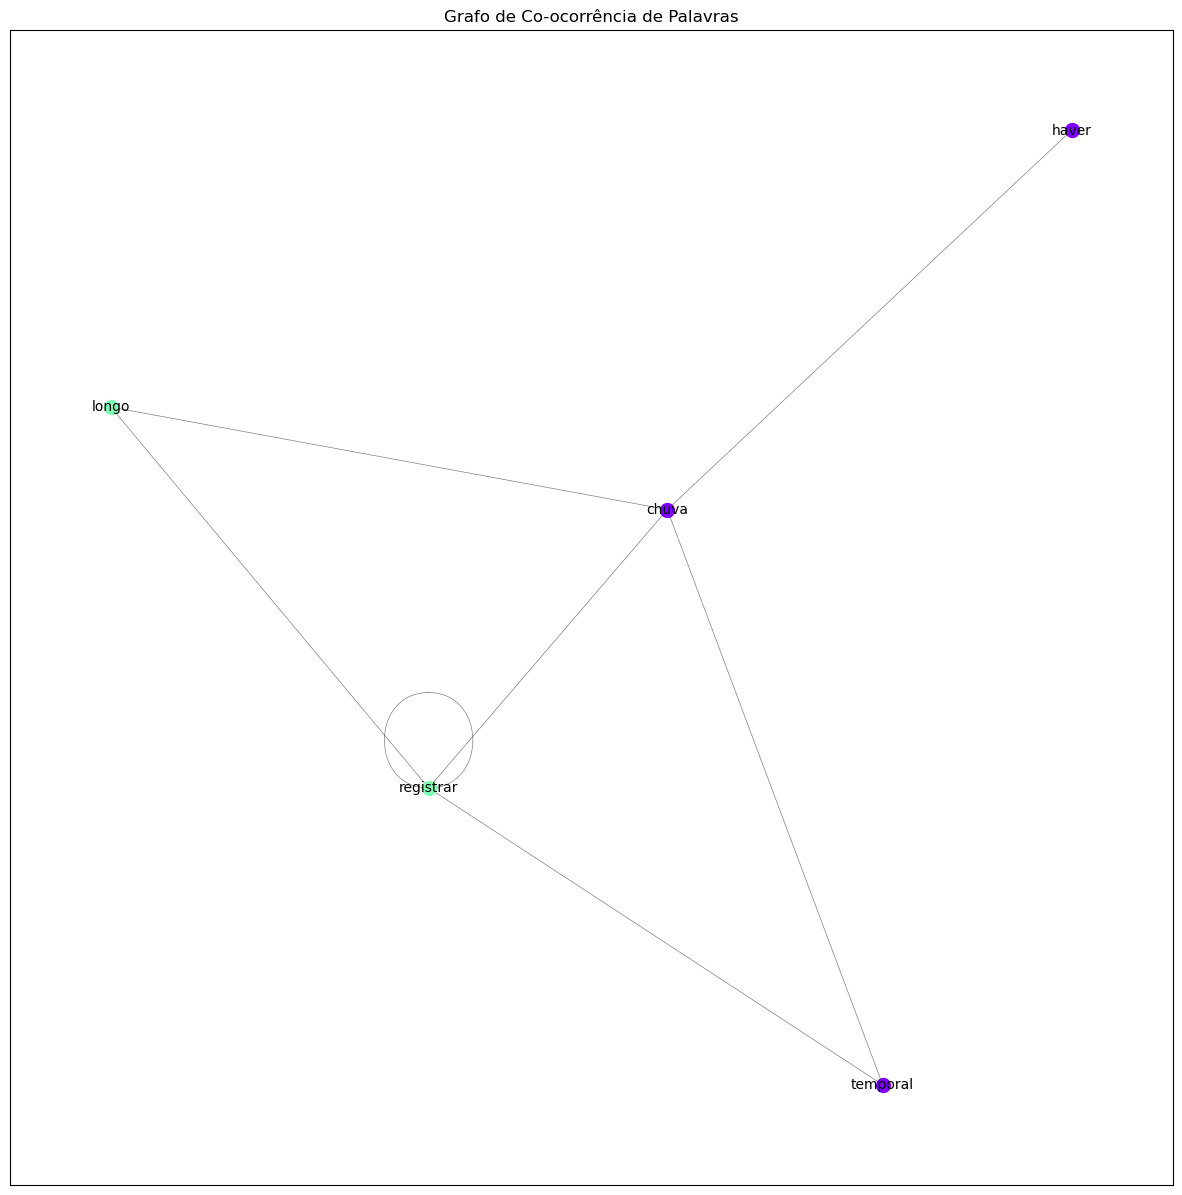


Estatísticas do Grafo:
Número de Nós: 5
Número de Arestas: 7

Grau dos Nós (em ordem decrescente):
Nó: registrar, Grau: 5
Nó: chuva, Grau: 4
Nó: temporal, Grau: 2
Nó: longo, Grau: 2
Nó: haver, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, registrar), Peso: 4
Aresta: (chuva, haver), Peso: 2
Aresta: (chuva, longo), Peso: 2
Aresta: (chuva, temporal), Peso: 1
Aresta: (temporal, registrar), Peso: 1
Aresta: (registrar, registrar), Peso: 1
Aresta: (registrar, longo), Peso: 1

Centralidade de Intermediação dos Nós (Top 10):
Nó: chuva, Centralidade de Intermediação: 0.5833
Nó: registrar, Centralidade de Intermediação: 0.0833
Nó: temporal, Centralidade de Intermediação: 0.0000
Nó: haver, Centralidade de Intermediação: 0.0000
Nó: longo, Centralidade de Intermediação: 0.0000

Coeficiente de Aglomeração Médio: 0.6000
Modularidade das Comunidades: -0.0868

Comunidade 1: haver, chuva, temporal
Comunidade 2: longo, registrar

Analisando link do ano 2022: https://g1.globo.com/sp/sa

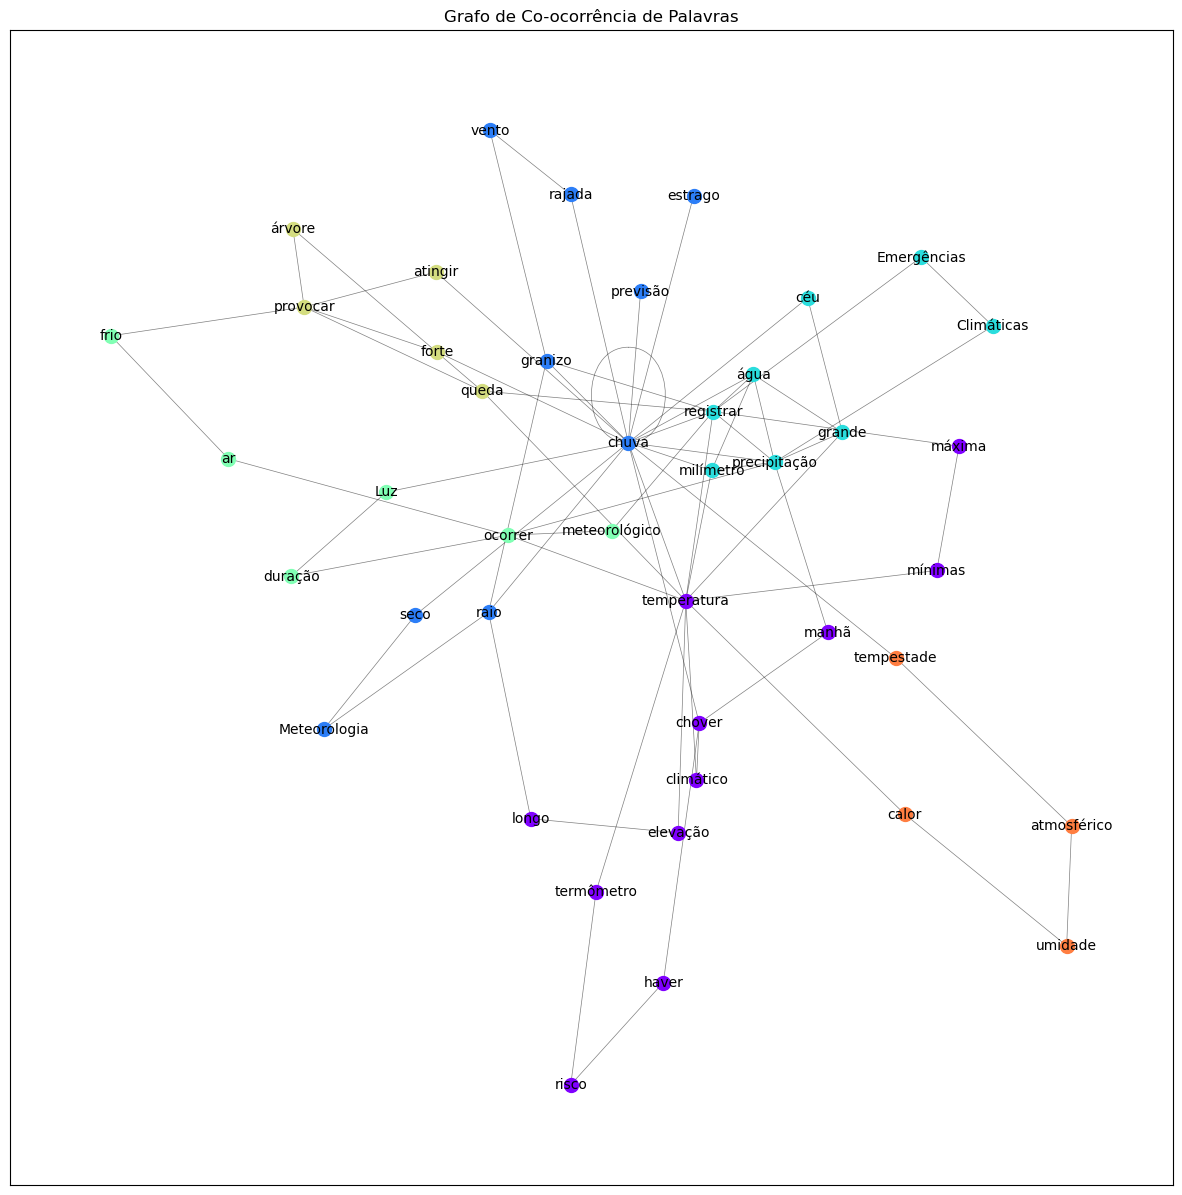


Estatísticas do Grafo:
Número de Nós: 43
Número de Arestas: 72

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 19
Nó: temperatura, Grau: 11
Nó: registrar, Grau: 9
Nó: precipitação, Grau: 8
Nó: provocar, Grau: 5
Nó: água, Grau: 5
Nó: ocorrer, Grau: 5
Nó: raio, Grau: 4
Nó: granizo, Grau: 4
Nó: milímetro, Grau: 4
Nó: grande, Grau: 4
Nó: chover, Grau: 4
Nó: queda, Grau: 4
Nó: seco, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: longo, Grau: 2
Nó: elevação, Grau: 2
Nó: calor, Grau: 2
Nó: umidade, Grau: 2
Nó: atmosférico, Grau: 2
Nó: tempestade, Grau: 2
Nó: rajada, Grau: 2
Nó: vento, Grau: 2
Nó: atingir, Grau: 2
Nó: forte, Grau: 2
Nó: climático, Grau: 2
Nó: haver, Grau: 2
Nó: risco, Grau: 2
Nó: termômetro, Grau: 2
Nó: meteorológico, Grau: 2
Nó: mínimas, Grau: 2
Nó: máxima, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: manhã, Grau: 2
Nó: céu, Grau: 2
Nó: árvore, Grau: 2
Nó: Luz, Grau: 2
Nó: duração, Grau: 2
Nó: ar, Grau: 2
Nó: frio, Grau: 2
Nó: estrago, Grau: 1
Nó: previsão, Gra

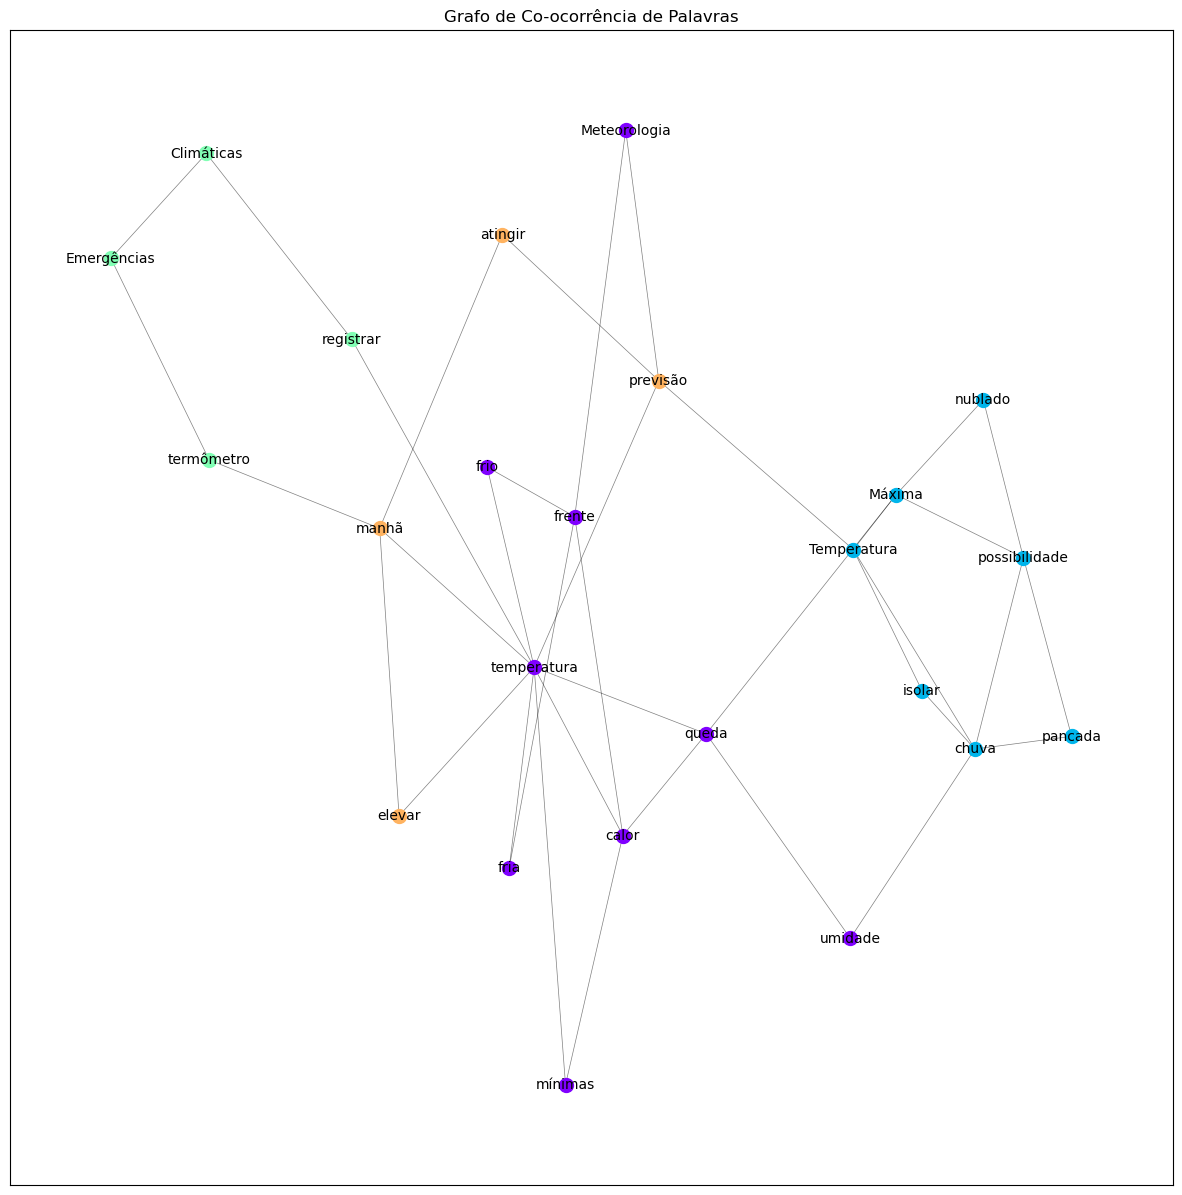


Estatísticas do Grafo:
Número de Nós: 24
Número de Arestas: 37

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 9
Nó: chuva, Grau: 5
Nó: calor, Grau: 4
Nó: queda, Grau: 4
Nó: frente, Grau: 4
Nó: manhã, Grau: 4
Nó: previsão, Grau: 4
Nó: Temperatura, Grau: 4
Nó: Máxima, Grau: 4
Nó: possibilidade, Grau: 4
Nó: frio, Grau: 2
Nó: termômetro, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: registrar, Grau: 2
Nó: elevar, Grau: 2
Nó: atingir, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: fria, Grau: 2
Nó: mínimas, Grau: 2
Nó: nublado, Grau: 2
Nó: isolar, Grau: 2
Nó: pancada, Grau: 2
Nó: umidade, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (Temperatura, Máxima), Peso: 5
Aresta: (Temperatura, isolar), Peso: 3
Aresta: (Máxima, nublado), Peso: 3
Aresta: (nublado, possibilidade), Peso: 3
Aresta: (chuva, isolar), Peso: 3
Aresta: (calor, queda), Peso: 2
Aresta: (queda, temperatura), Peso: 2
Aresta: (possibilidade, chuva), Peso: 2
Aresta: (possibilidade, pancada), Peso: 

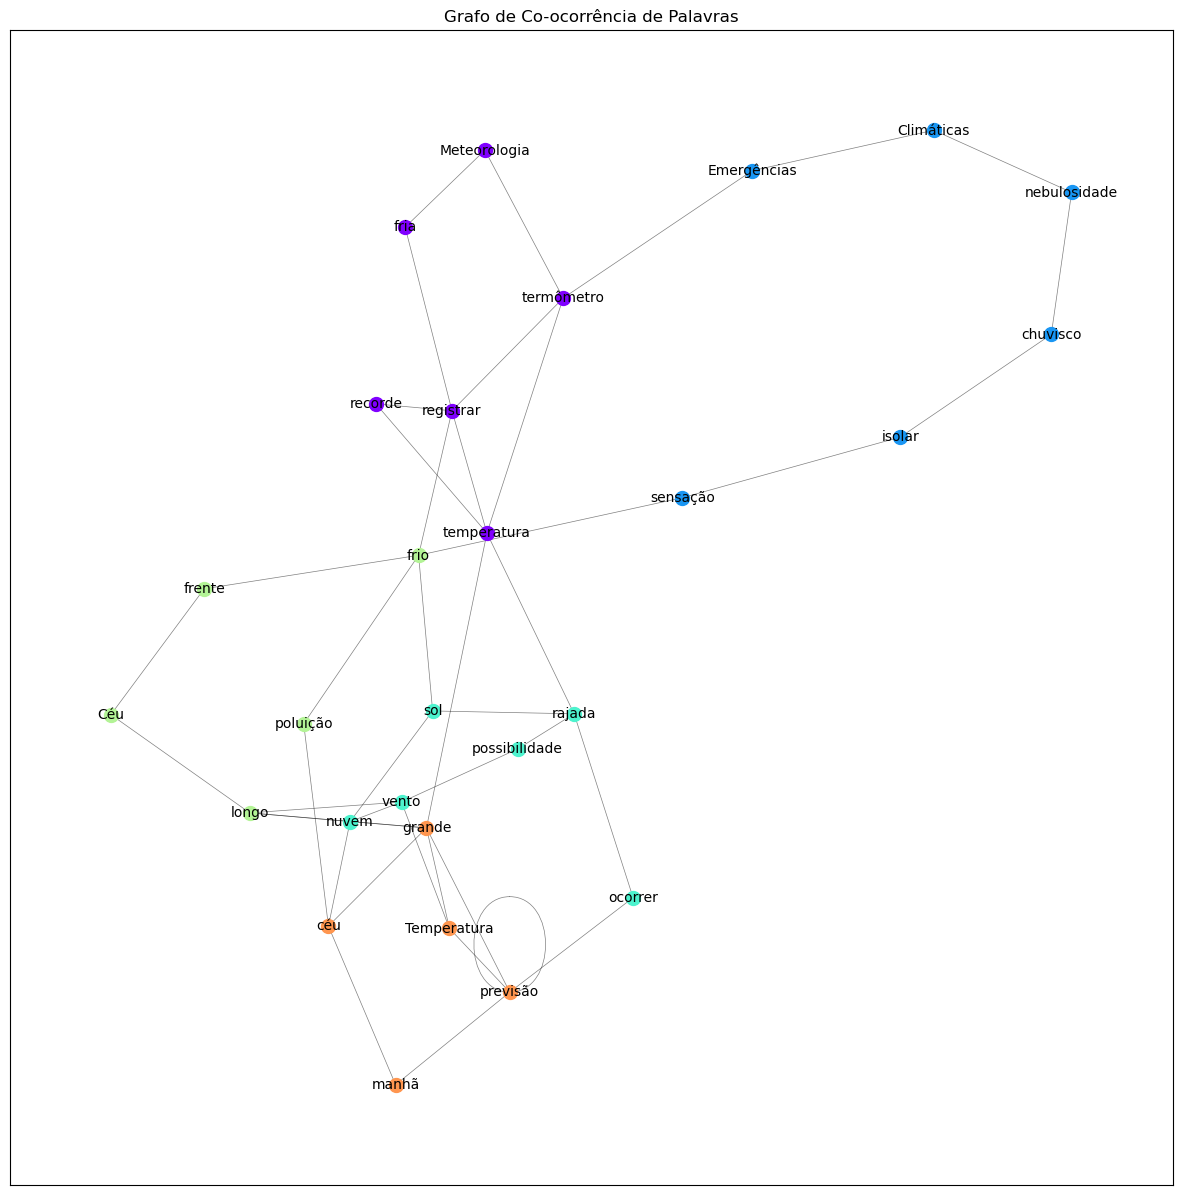


Estatísticas do Grafo:
Número de Nós: 28
Número de Arestas: 44

Grau dos Nós (em ordem decrescente):
Nó: previsão, Grau: 6
Nó: grande, Grau: 6
Nó: registrar, Grau: 5
Nó: frio, Grau: 5
Nó: temperatura, Grau: 5
Nó: nuvem, Grau: 5
Nó: termômetro, Grau: 4
Nó: longo, Grau: 4
Nó: céu, Grau: 4
Nó: rajada, Grau: 4
Nó: vento, Grau: 4
Nó: sol, Grau: 3
Nó: Temperatura, Grau: 3
Nó: fria, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: recorde, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: nebulosidade, Grau: 2
Nó: chuvisco, Grau: 2
Nó: isolar, Grau: 2
Nó: sensação, Grau: 2
Nó: Céu, Grau: 2
Nó: frente, Grau: 2
Nó: poluição, Grau: 2
Nó: manhã, Grau: 2
Nó: ocorrer, Grau: 2
Nó: possibilidade, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (registrar, frio), Peso: 2
Aresta: (registrar, temperatura), Peso: 2
Aresta: (sol, nuvem), Peso: 2
Aresta: (nuvem, grande), Peso: 2
Aresta: (nuvem, vento), Peso: 2
Aresta: (grande, Temperatura), Peso: 2
Aresta: (rajada, possibilidade), Peso: 2
Aresta

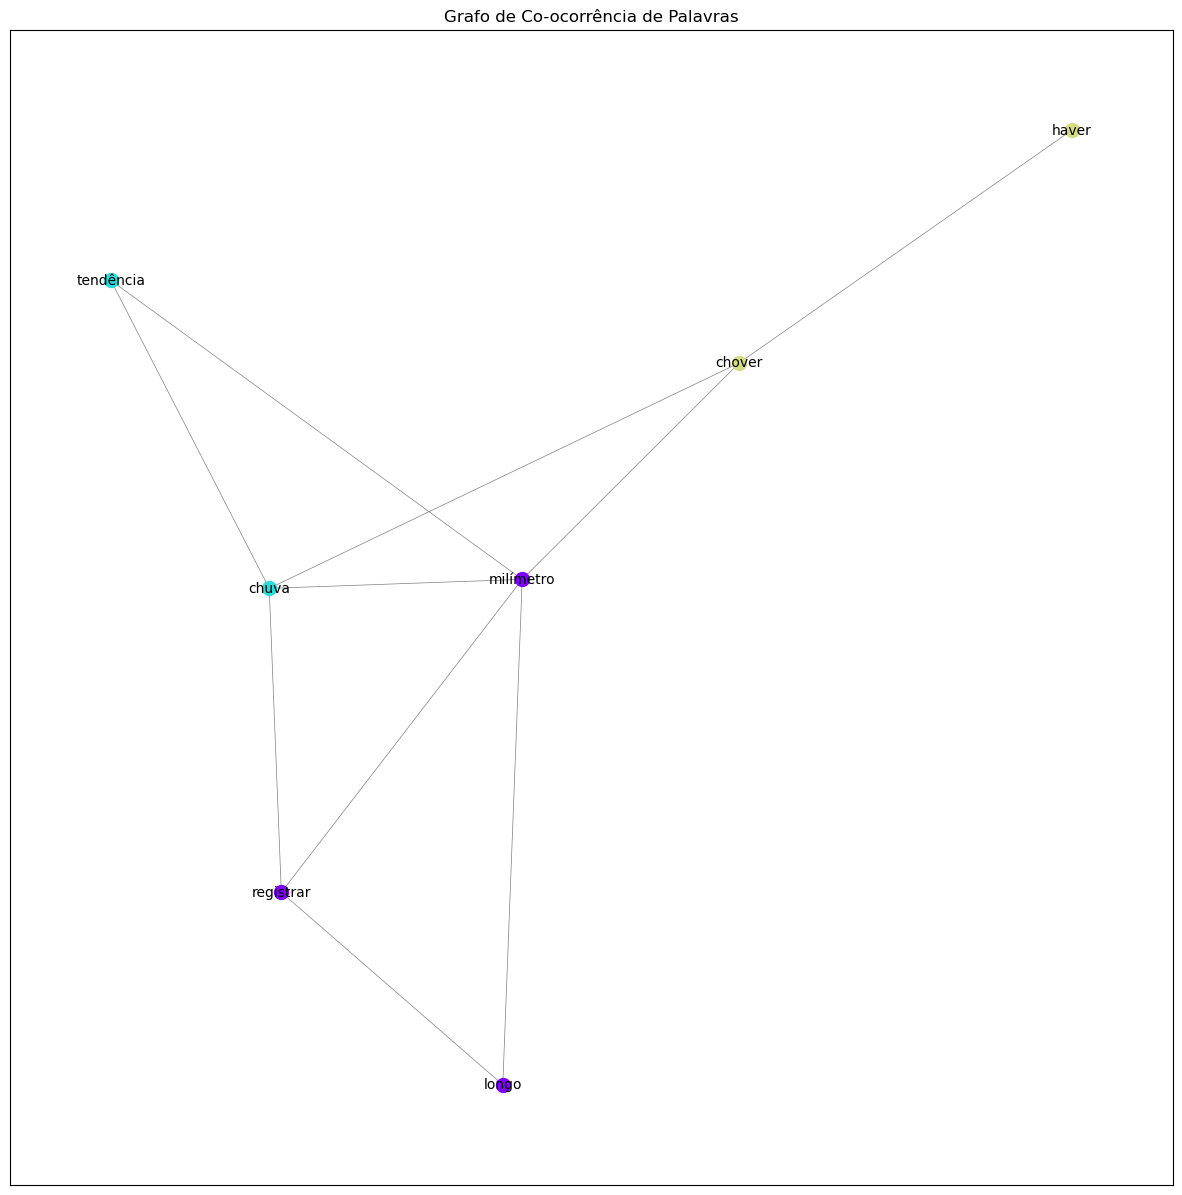


Estatísticas do Grafo:
Número de Nós: 7
Número de Arestas: 10

Grau dos Nós (em ordem decrescente):
Nó: milímetro, Grau: 5
Nó: chuva, Grau: 4
Nó: registrar, Grau: 3
Nó: chover, Grau: 3
Nó: longo, Grau: 2
Nó: tendência, Grau: 2
Nó: haver, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (registrar, chuva), Peso: 3
Aresta: (milímetro, chover), Peso: 3
Aresta: (longo, registrar), Peso: 2
Aresta: (chover, haver), Peso: 2
Aresta: (longo, milímetro), Peso: 1
Aresta: (registrar, milímetro), Peso: 1
Aresta: (chuva, milímetro), Peso: 1
Aresta: (chuva, tendência), Peso: 1
Aresta: (chuva, chover), Peso: 1
Aresta: (milímetro, tendência), Peso: 1

Centralidade de Intermediação dos Nós (Top 10):
Nó: milímetro, Centralidade de Intermediação: 0.4000
Nó: chover, Centralidade de Intermediação: 0.3333
Nó: chuva, Centralidade de Intermediação: 0.1667
Nó: registrar, Centralidade de Intermediação: 0.0333
Nó: longo, Centralidade de Intermediação: 0.0000
Nó: tendência, Centralidade de Intermediação:

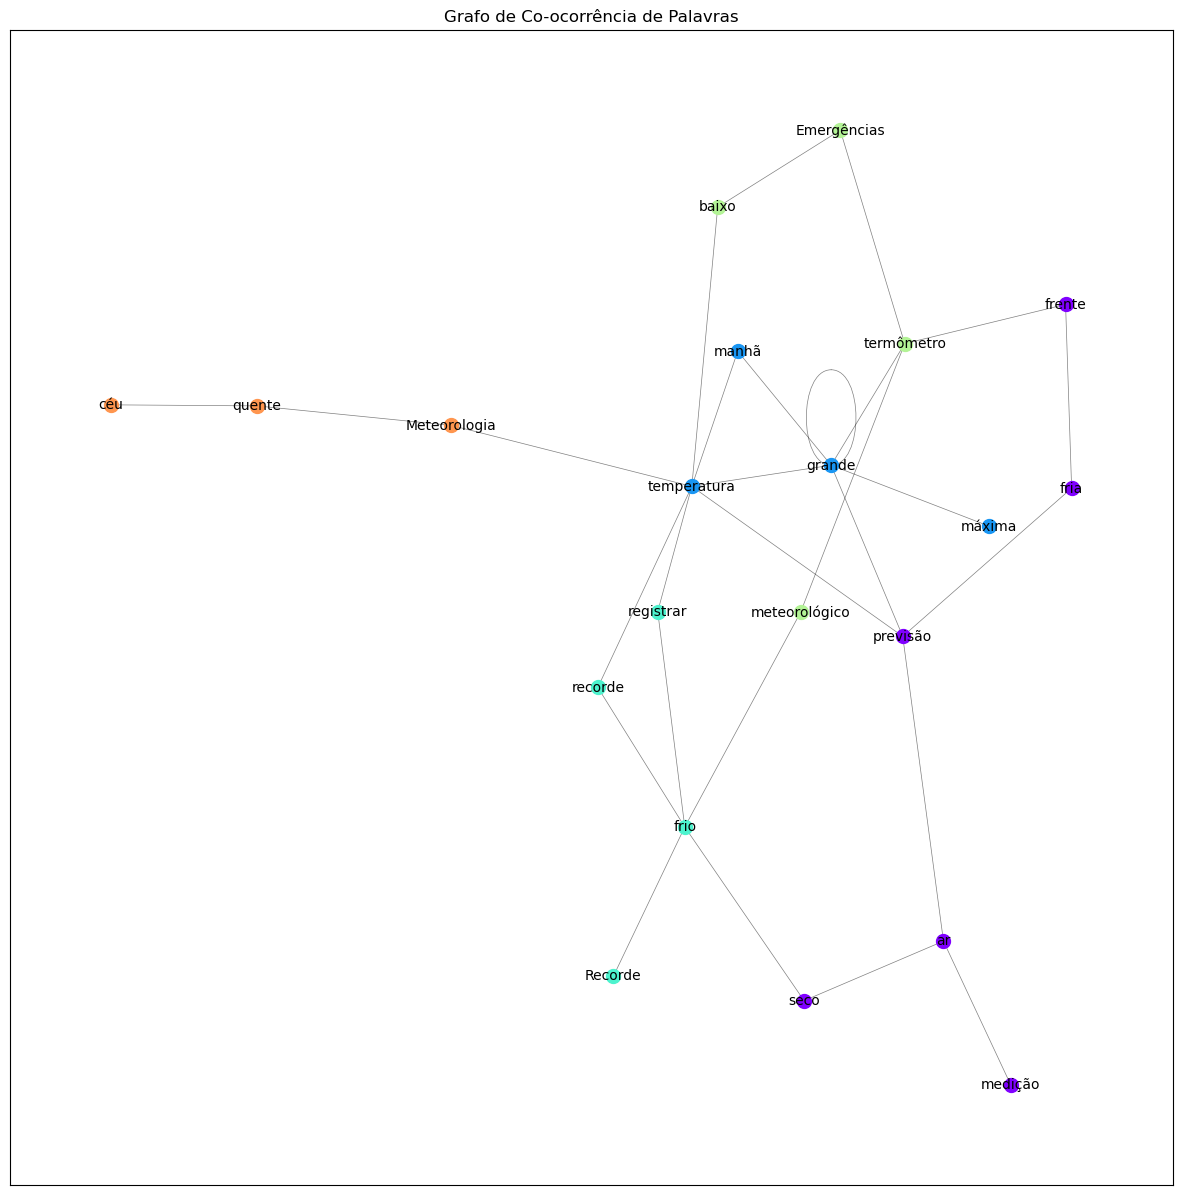


Estatísticas do Grafo:
Número de Nós: 21
Número de Arestas: 28

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 7
Nó: grande, Grau: 7
Nó: frio, Grau: 5
Nó: termômetro, Grau: 4
Nó: previsão, Grau: 4
Nó: ar, Grau: 3
Nó: quente, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: registrar, Grau: 2
Nó: baixo, Grau: 2
Nó: Emergências, Grau: 2
Nó: meteorológico, Grau: 2
Nó: recorde, Grau: 2
Nó: seco, Grau: 2
Nó: manhã, Grau: 2
Nó: frente, Grau: 2
Nó: fria, Grau: 2
Nó: céu, Grau: 1
Nó: Recorde, Grau: 1
Nó: medição, Grau: 1
Nó: máxima, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (temperatura, registrar), Peso: 3
Aresta: (temperatura, grande), Peso: 2
Aresta: (frio, Recorde), Peso: 2
Aresta: (ar, medição), Peso: 2
Aresta: (céu, quente), Peso: 1
Aresta: (quente, Meteorologia), Peso: 1
Aresta: (Meteorologia, temperatura), Peso: 1
Aresta: (temperatura, baixo), Peso: 1
Aresta: (temperatura, recorde), Peso: 1
Aresta: (temperatura, previsão), Peso: 1
Aresta: (temperatura, manhã), Peso: 

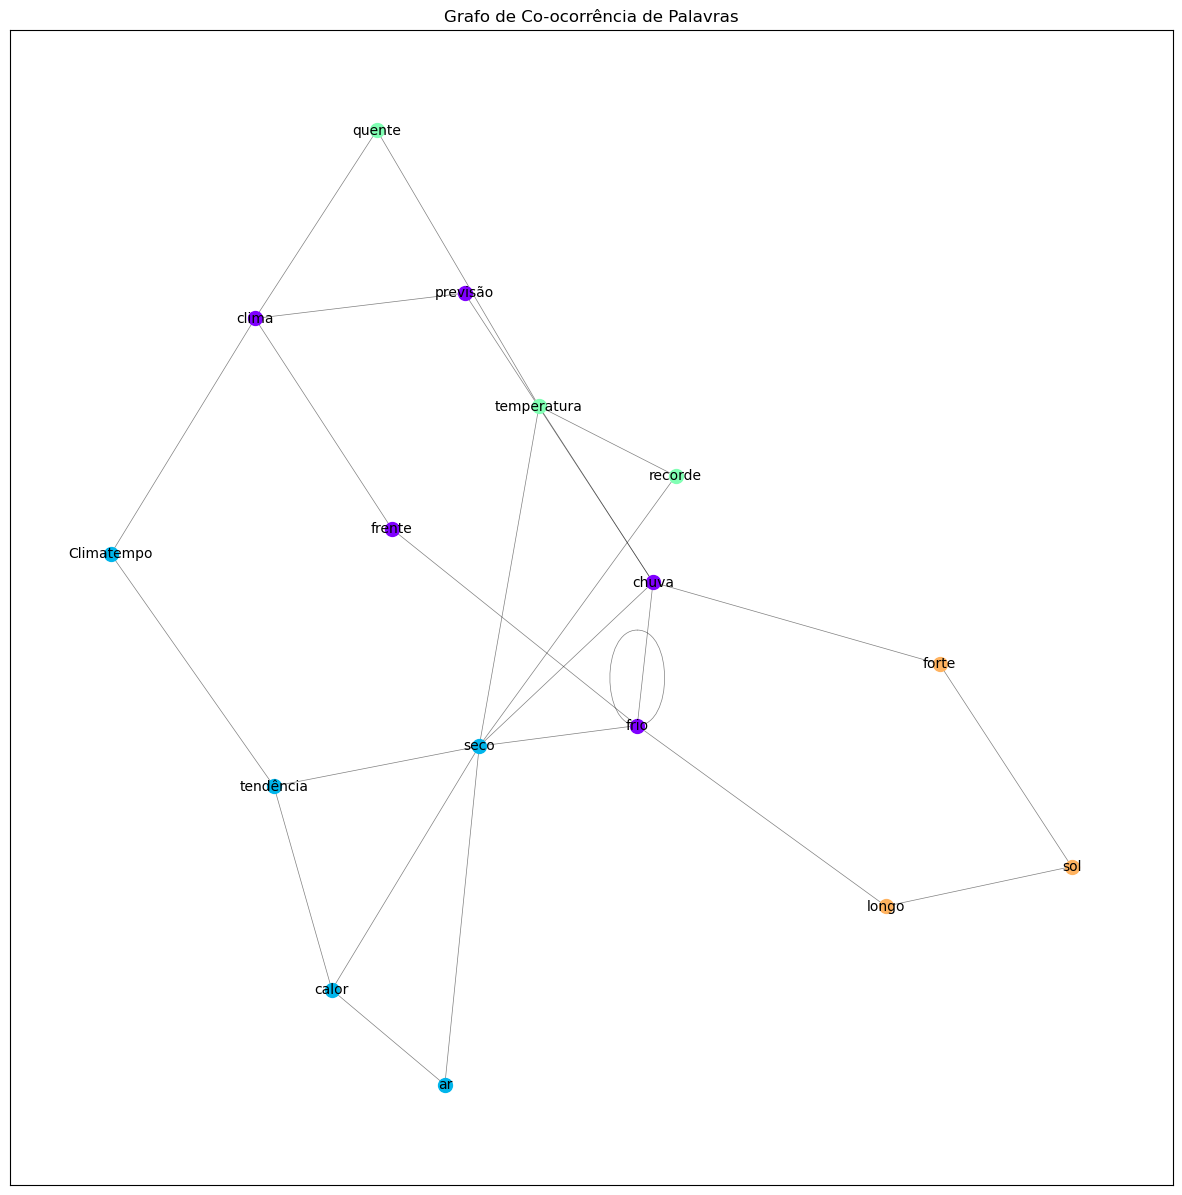


Estatísticas do Grafo:
Número de Nós: 16
Número de Arestas: 25

Grau dos Nós (em ordem decrescente):
Nó: seco, Grau: 7
Nó: frio, Grau: 6
Nó: chuva, Grau: 5
Nó: temperatura, Grau: 4
Nó: clima, Grau: 4
Nó: calor, Grau: 3
Nó: tendência, Grau: 3
Nó: ar, Grau: 2
Nó: longo, Grau: 2
Nó: sol, Grau: 2
Nó: forte, Grau: 2
Nó: previsão, Grau: 2
Nó: Climatempo, Grau: 2
Nó: recorde, Grau: 2
Nó: quente, Grau: 2
Nó: frente, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, frio), Peso: 3
Aresta: (seco, tendência), Peso: 2
Aresta: (calor, ar), Peso: 1
Aresta: (calor, tendência), Peso: 1
Aresta: (calor, seco), Peso: 1
Aresta: (ar, seco), Peso: 1
Aresta: (seco, temperatura), Peso: 1
Aresta: (seco, recorde), Peso: 1
Aresta: (seco, frio), Peso: 1
Aresta: (seco, chuva), Peso: 1
Aresta: (temperatura, chuva), Peso: 1
Aresta: (temperatura, recorde), Peso: 1
Aresta: (temperatura, quente), Peso: 1
Aresta: (chuva, forte), Peso: 1
Aresta: (chuva, previsão), Peso: 1
Aresta: (frio, frio), Peso: 1
Ar

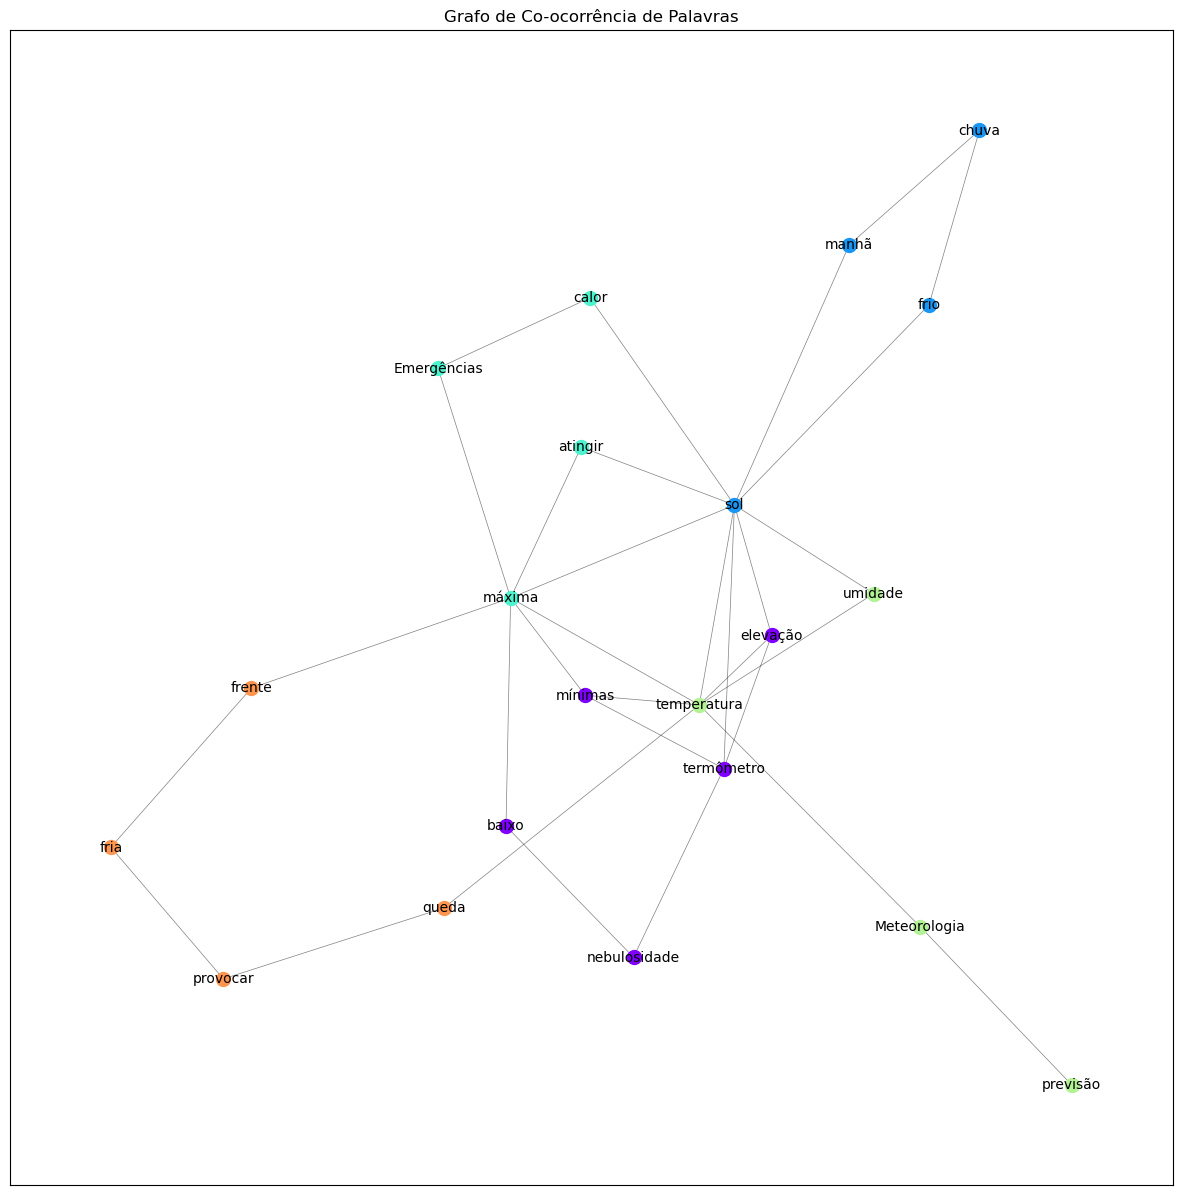


Estatísticas do Grafo:
Número de Nós: 21
Número de Arestas: 31

Grau dos Nós (em ordem decrescente):
Nó: sol, Grau: 9
Nó: máxima, Grau: 7
Nó: temperatura, Grau: 7
Nó: termômetro, Grau: 4
Nó: elevação, Grau: 3
Nó: mínimas, Grau: 3
Nó: manhã, Grau: 2
Nó: chuva, Grau: 2
Nó: frio, Grau: 2
Nó: calor, Grau: 2
Nó: Emergências, Grau: 2
Nó: baixo, Grau: 2
Nó: nebulosidade, Grau: 2
Nó: umidade, Grau: 2
Nó: atingir, Grau: 2
Nó: frente, Grau: 2
Nó: fria, Grau: 2
Nó: provocar, Grau: 2
Nó: queda, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: previsão, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (elevação, temperatura), Peso: 3
Aresta: (sol, elevação), Peso: 2
Aresta: (sol, temperatura), Peso: 2
Aresta: (máxima, mínimas), Peso: 2
Aresta: (sol, manhã), Peso: 1
Aresta: (sol, frio), Peso: 1
Aresta: (sol, calor), Peso: 1
Aresta: (sol, termômetro), Peso: 1
Aresta: (sol, máxima), Peso: 1
Aresta: (sol, umidade), Peso: 1
Aresta: (sol, atingir), Peso: 1
Aresta: (manhã, chuva), Peso: 1
Aresta: (chuva, f

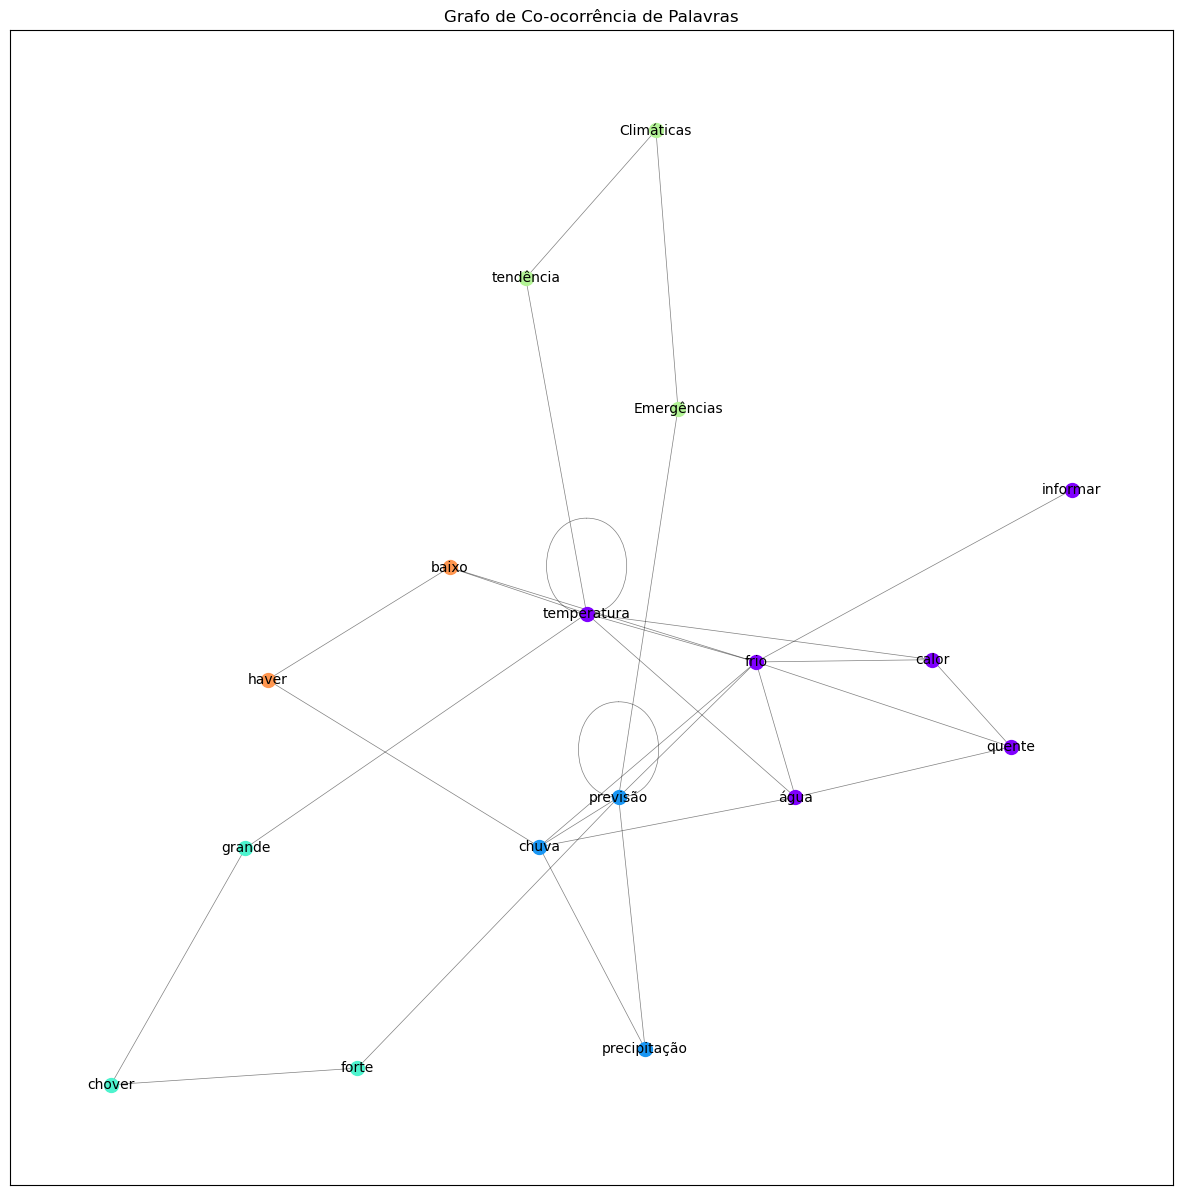


Estatísticas do Grafo:
Número de Nós: 17
Número de Arestas: 29

Grau dos Nós (em ordem decrescente):
Nó: frio, Grau: 8
Nó: temperatura, Grau: 8
Nó: previsão, Grau: 7
Nó: chuva, Grau: 5
Nó: água, Grau: 4
Nó: calor, Grau: 3
Nó: quente, Grau: 3
Nó: baixo, Grau: 3
Nó: haver, Grau: 2
Nó: precipitação, Grau: 2
Nó: grande, Grau: 2
Nó: chover, Grau: 2
Nó: forte, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: tendência, Grau: 2
Nó: informar, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (calor, quente), Peso: 4
Aresta: (frio, temperatura), Peso: 2
Aresta: (frio, previsão), Peso: 2
Aresta: (temperatura, baixo), Peso: 2
Aresta: (chuva, frio), Peso: 1
Aresta: (chuva, haver), Peso: 1
Aresta: (chuva, precipitação), Peso: 1
Aresta: (chuva, previsão), Peso: 1
Aresta: (chuva, água), Peso: 1
Aresta: (frio, calor), Peso: 1
Aresta: (frio, baixo), Peso: 1
Aresta: (frio, quente), Peso: 1
Aresta: (frio, água), Peso: 1
Aresta: (frio, informar), Peso: 1
Aresta: (calor, temperatura), 

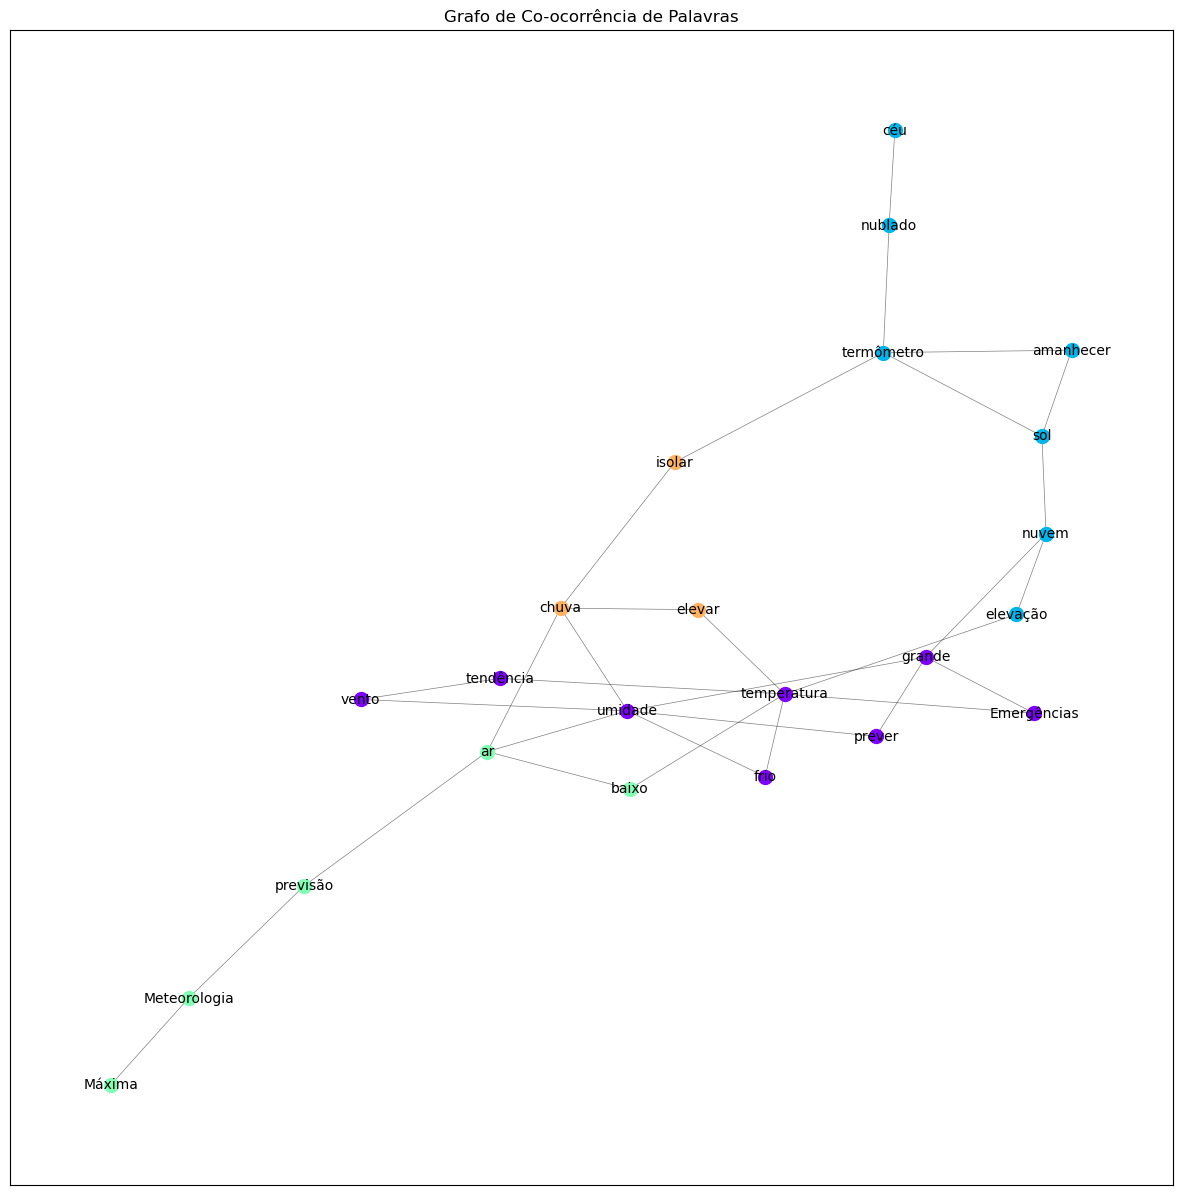


Estatísticas do Grafo:
Número de Nós: 23
Número de Arestas: 31

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 6
Nó: umidade, Grau: 6
Nó: termômetro, Grau: 4
Nó: grande, Grau: 4
Nó: ar, Grau: 4
Nó: chuva, Grau: 4
Nó: sol, Grau: 3
Nó: nuvem, Grau: 3
Nó: nublado, Grau: 2
Nó: elevação, Grau: 2
Nó: Emergências, Grau: 2
Nó: prever, Grau: 2
Nó: baixo, Grau: 2
Nó: tendência, Grau: 2
Nó: vento, Grau: 2
Nó: frio, Grau: 2
Nó: elevar, Grau: 2
Nó: isolar, Grau: 2
Nó: amanhecer, Grau: 2
Nó: previsão, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: céu, Grau: 1
Nó: Máxima, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (umidade, ar), Peso: 3
Aresta: (sol, nuvem), Peso: 2
Aresta: (céu, nublado), Peso: 1
Aresta: (nublado, termômetro), Peso: 1
Aresta: (termômetro, sol), Peso: 1
Aresta: (termômetro, isolar), Peso: 1
Aresta: (termômetro, amanhecer), Peso: 1
Aresta: (sol, amanhecer), Peso: 1
Aresta: (nuvem, elevação), Peso: 1
Aresta: (nuvem, grande), Peso: 1
Aresta: (elevação, temperatura),

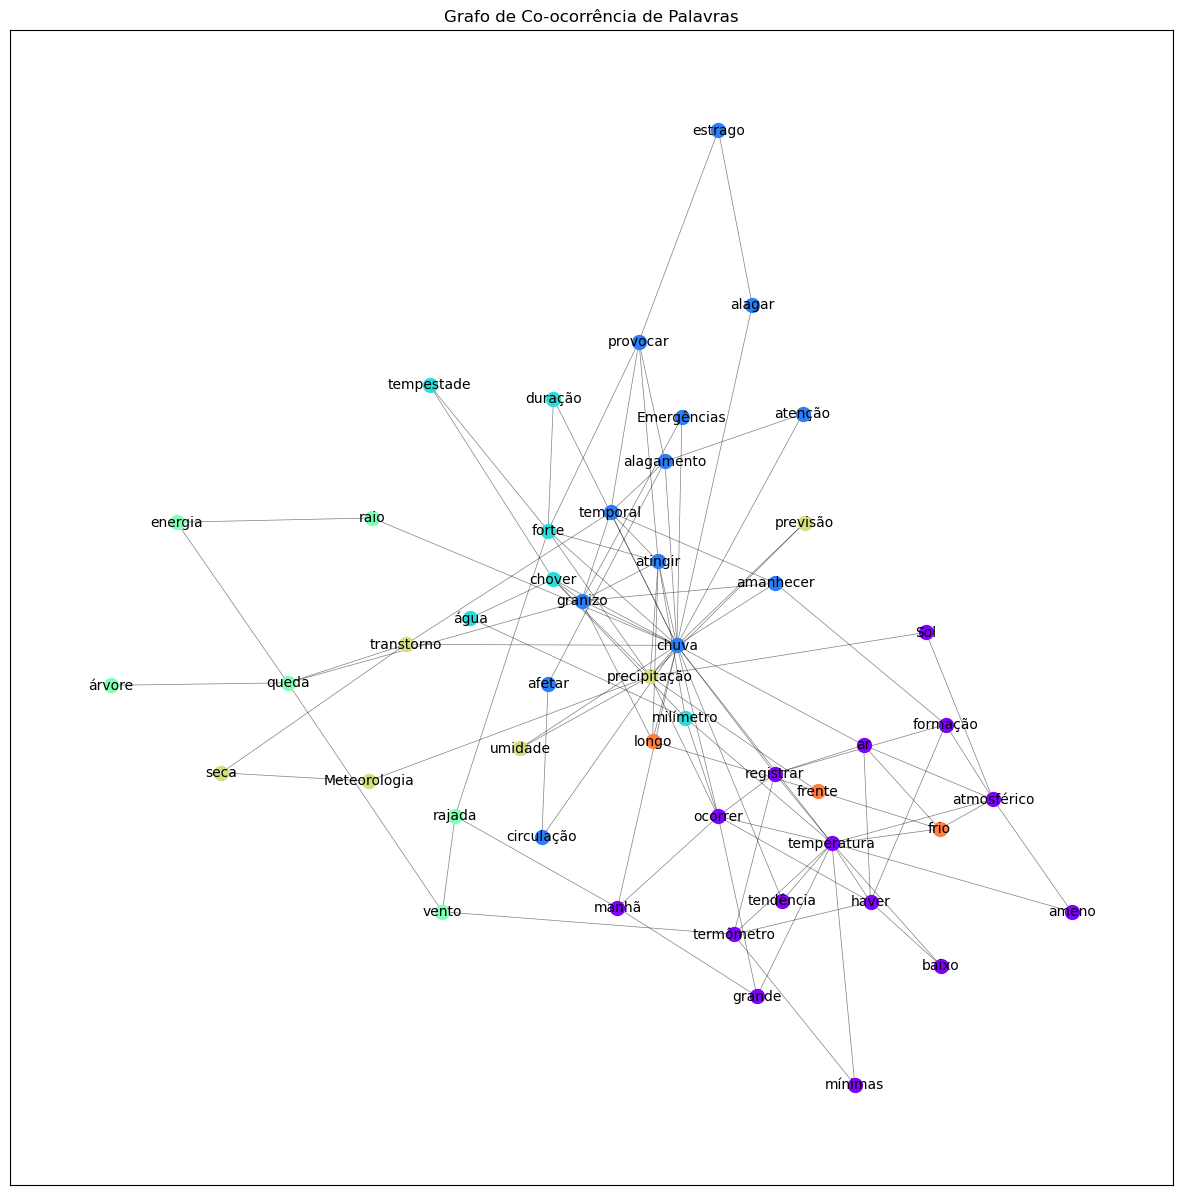


Estatísticas do Grafo:
Número de Nós: 49
Número de Arestas: 108

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 24
Nó: temperatura, Grau: 13
Nó: precipitação, Grau: 10
Nó: ocorrer, Grau: 8
Nó: granizo, Grau: 8
Nó: atingir, Grau: 8
Nó: temporal, Grau: 7
Nó: forte, Grau: 7
Nó: chover, Grau: 6
Nó: atmosférico, Grau: 6
Nó: registrar, Grau: 6
Nó: haver, Grau: 6
Nó: alagamento, Grau: 5
Nó: milímetro, Grau: 5
Nó: termômetro, Grau: 5
Nó: provocar, Grau: 5
Nó: ar, Grau: 5
Nó: queda, Grau: 5
Nó: transtorno, Grau: 4
Nó: frio, Grau: 4
Nó: longo, Grau: 4
Nó: manhã, Grau: 4
Nó: formação, Grau: 4
Nó: amanhecer, Grau: 4
Nó: frente, Grau: 3
Nó: grande, Grau: 3
Nó: rajada, Grau: 3
Nó: vento, Grau: 3
Nó: atenção, Grau: 2
Nó: seca, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: água, Grau: 2
Nó: baixo, Grau: 2
Nó: tempestade, Grau: 2
Nó: estrago, Grau: 2
Nó: alagar, Grau: 2
Nó: ameno, Grau: 2
Nó: Sol, Grau: 2
Nó: mínimas, Grau: 2
Nó: afetar, Grau: 2
Nó: circulação, Grau: 2
Nó: energia, Grau: 2
Nó: raio, Gr

In [ ]:
for url in urls_G1_2022:
    print(f"\nAnalisando link do ano 2022: {url}")
    texto = coletar_texto(url)
    G = construir_grafo(texto)
    plotar_grafo(G)
    estatisticas_grafo(G)
    print()
    detectar_comunidades(G)

# **Análises dos grafos do ano de 2022**

**Análise do Grafo do Mês 01 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/01/30/chuvas-que-atingem-sp-sao-provocadas-por-fenomeno-tipico-do-verao-entenda.ghtml)**

Número de Nós: 23, Número de Arestas: 32

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (10), indicando que é o nó mais central e o mais conectado no grafo. Outros nó  com alto grau, como "alagamento" (4), "atingir" (4), "Climatempo" (4) e "haver" (4), sugerem que o foco da notícia envolve um evento climático significativo, especificamente fortes chuvas que causaram alagamentos entre outros problemas. Reforçado pelas arestas (chuva, provocar) com peso 2 e (chuva, forte) com peso 1, que destacam a intensidade da chuva e seus efeitos negativos.

A centralidade de intermediação do nó "chuva" é de 65,37%, reforçando que este termo serve como ponto central que conecta a maioria dos outros termos no grafo. Isso indica que a narrativa da notícia gira principalmente em torno das chuvas e seus efeitos, além disso temos os nós "haver" apresenta uma centralidade de 27,27% e "provocar" com uma centralidade de 19,35%, ambos funcioando como conectores importantes no grafo sugerindo que este verbo é usado para descrever os efeitos das chuvas, como alagamentos e possíveis danos. Essas conexões nos levam a interpretar que a notícia enfatiza o impacto das chuvas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 31,45%, o grafo apresenta uma conectividade razoável entre as palavras. Esse nível de aglomeração sugere que, embora as palavras estejam conectadas, ainda há distinções entre subtemas dentro da narrativa, como detalhes sobre o impacto das chuvas versus previsões meteorológicas.

Modularidade das Comunidades: A modularidade de 43,94% indica uma estrutura razoavelmente definida de comunidades, o que nos permite identificar grupos de palavras (ou "comunidades") que tratam de subtemas específicos dentro do tópico principal jutando isso com as 4 comunidades detectadas que são:

- Comunidade 1: "atingir", "problema", "chuva", "Emergências", "Climáticas", "CLIMA", "tempestade", "meteorológico".
Essa comunidade parece focada no impacto das chuvas e nas condições meteorológicas adversas, sugerindo que a notícia também aborda a resposta das emergências climáticas à situação.

- Comunidade 2: "ar", "vento", "circulação", "temperatura", "provocar", "haver".
Este grupo de palavras se relaciona com os aspectos meteorológicos que influenciam as chuvas, como circulação do ar e vento, sugerindo uma análise das causas climáticas por trás da tempestade.

- Comunidade 3: "risco", "forte", "elevar", "pancada", "alagamento".
Aqui, a ênfase está nos riscos diretos causados pela intensidade da chuva, incluindo alagamentos, o que reforça a ideia de um evento climático severo com potencial de causar danos.

- Comunidade 4: "Climatempo", "precipitação", "previsão", "afetar".
Esta comunidade parece centrada nas previsões meteorológicas e nas informações fornecidas pelo Climatempo, indicando a fonte e a análise antecipada sobre a precipitação.

Esse grafo reflete uma situação de fortes chuvas em janeiro de 2022, que provocaram alagamentos e potenciais riscos à população. A presença de palavras como "Emergências" e "Climatempo" sugere que a notícia discutiu tanto os impactos imediatos das chuvas quanto a resposta das autoridades e as previsões para o clima. Combinando a alta centralidade da palavra "chuva" e o grau elevado de conexões com termos como "alagamento" e "problema", fica claro que a narrativa principalmente se concentra nas consequências das chuvas intensas, que causaram alagamentos e possivelmente colocaram áreas em estado de emergência.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 02 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/02/02/no-de-mortos-pelas-fortes-chuvas-em-sp-ja-e-48percent-maior-do-que-o-do-verao-passado.ghtml)**

Número de Nós: 5, Número de Arestas: 7

**Principais Nós e Centralidade**

A palavra "registrar" possui o maior grau (5), destacando-se como o nó mais conectado no grafo. Outros nós com graus elevados, como "chuva" (4), "temporal" (2), "longo" (2) e "haver" (1), sugerem que a notícia centraliza-se no registro de um evento climático, envolvendo chuvas e temporais prolongados. As arestas com pesos mais altos, como (chuva, registrar) com peso 4 e (chuva, haver) com peso 2, reforçam a ideia de que a notícia está destacando a intensidade da chuva.

A centralidade de intermediação do nó "chuva" é de 58,33%, o que indica que, embora não seja o nó com maior grau, ele ainda desempenha um papel fundamental ao conectar outras palavras no grafo. Esse valor sugere que a chuva é um tema central na narrativa e que o evento descrito na notícia gira em torno de chuvas fortes e prolongadas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 60%, o grafo apresenta uma conectividade relativamente alta entre os nós. Esse nível de aglomeração sugere que as palavras estão bem conectadas e mantêm uma relação próxima entre si, o que reflete no foco específico na notícia sobre as chuvas e temporais.

Modularidade das Comunidades: A modularidade negativa -8,68% indica uma baixa definição de comunidades no grafo, sugerindo que os subtemas dentro da narrativa não estão claramente separados. De fato, apenas duas comunidades foram detectadas:

- Comunidade 1: "haver", "temporal", "chuva".
Esta comunidade parece focada na ocorrência dos temporais e na presença contínua das chuvas, reforçando a ideia de um clima adverso e persistente.

- Comunidade 2: "registrar", "longo".
Esta comunidade destaca o aspecto de "registro" e a duração "longa" dos eventos climáticos, sugerindo que o foco da notícia também inclui a documentação de chuvas prolongadas.


Esse segundo grafo reflete um evento climático em fevereiro de 2022, caracterizado por chuvas intensas e possivelmente contínuas. A centralidade elevada de "chuva" e "registrar" aponta para uma narrativa focada na documentação dos temporais, com uma duração prolongada. A estrutura simples do grafo, com poucas comunidades e alta conectividade, reforça que a notícia aborda diretamente um evento climático sem outros temas ou submetas, enfatizando a intensidade e duração das chuvas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 03 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/03/21/sao-paulo-tem-verao-marcado-por-contraste-entre-chuvas-intensas-e-2o-fevereiro-mais-seco-em-79-anos.ghtml)**

Número de Nós: 43, Número de Arestas: 72

**Principais Nós e Centralidade**

A palavra "chuva" apresenta o maior grau (19), posicionando-se como o nó mais central e conectado do grafo, seguido por "temperatura" (11), "registrar" (9), "precipitação" (8) e "provocar" (5). Isso sugere que a notícia enfatiza novamente a ocorrência de chuvas e o impacto delas, especialmente com relação à temperatura e aos registros de precipitação. O que é reforçado pelo peso das arestas, como (chuva, registrar) com peso 5 e (chuva, chuva) com peso 3.

A centralidade de intermediação do nó "chuva" é de 53,59%, o que indica seu papel como ponto de conexão crucial para a maioria dos outros termos no grafo. O nó "temperatura" com centralidade de 32,77% e o nó "registrar" com 16,65% também se destacam, apoiando a ideia de que o foco da notícia está na relação entre a chuva, os registros e as variações de temperatura que a chuva acarreta.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de apenas 9%, revela uma baixa conectividade entre as palavras no grafo, o que sugere que as conexões são mais fragmentadas e específicas a temas pontuais.

Modularidade das Comunidades: A modularidade de 38,40% aponta para uma estrutura razoavelmente definida de comunidades, indicando subtemas distintos dentro do tópico principal. As seis comunidades identificadas são:

- Comunidade 1: "elevação", "risco", "mínimas", "máxima", "haver", "manhã", "climático", "termômetro", "chover", "temperatura", "longo".
Esta comunidade foca nas condições climáticas relacionadas às variações de temperatura e precipitação ao longo do dia.

- Comunidade 2: "estrago", "vento", "previsão", "raio", "chuva", "granizo", "Meteorologia", "seco", "rajada".
Aqui, a ênfase está nos fenômenos meteorológicos adversos como rajadas de vento e granizo, indicando riscos e estragos causados por condições intensas.

- Comunidade 3: "grande", "água", "Emergências", "céu", "Climáticas", "registrar", "precipitação", "milímetro".
Esta comunidade foca na quantidade de precipitação e no impacto das chuvas sobre o ambiente, relacionando a intensidade das chuvas com situações de emergência.

- Comunidade 4: "ar", "frio", "Luz", "duração", "ocorrer", "meteorológico".
A comunidade está relacionada aos aspectos mais atmosféricos e meteorológicos, incluindo ar frio e duração de eventos climáticos.

- Comunidade 5: "atingir", "forte", "árvore", "provocar", "queda".
Esta comunidade destaca os efeitos das chuvas fortes, como queda de árvores, sugerindo consequências diretas da intensidade dos eventos climáticos.

- Comunidade 6: "umidade", "tempestade", "atmosférico", "calor".
Relacionada à umidade e tempestades, essa comunidade sugere condições atmosféricas que acompanham as tempestades e mudanças de calor.


Esse terceiro grafo representa uma notícia de março de 2022, com foco em registros de precipitação, variações de temperatura e os impactos das chuvas. A centralidade elevada de "chuva" e "temperatura", associada às comunidades identificadas, indica que a narrativa foca nos registros de chuvas, mudanças de temperatura, e possíveis danos causados por condições meteorológicas adversas, como queda de árvores e rajadas de vento.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 04 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/04/11/semana-em-sp-comeca-com-calor-temperatura-despenca-a-partir-de-quinta-e-feriado-tera-minima-de-10c.ghtml)**

Número de Nós: 24, Número de Arestas: 37

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (9), destacando-se como o nó mais central e conectado do grafo, seguida por "chuva" (5), "calor" (4) e "queda" (4). Isso indica que o foco da notícia está em uma queda de temperatura, possivelmente provocada pela chuva, que ocorreu após um período de calor. Essa ideia é reforçada pelo peso das arestas, como (temperatura, Máxima) com peso 5 e (temperatura, isolar) com peso 3.

A centralidade de intermediação do nó "temperatura" é de 53,53%, o que mostra que ele serve como ponto principal de conexão entre a maioria dos outros nós. O nó "queda" com 26,39% e "previsão" com 24,40% também se destacam como conectores importantes, reforçando o foco em uma mudança de temperatura devido às chuvas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 27,57%, o grafo apresenta uma conectividade razoável entre os nós, indicando uma estrutura coesa, embora ainda existam subtemas bem demarcados.

Modularidade das Comunidades: A modularidade de 46,97% indica uma estrutura razoalmente definida de comunidades, com os termos distribuídos em torno de tópicos específicos. As quatro comunidades identificadas são:

- Comunidade 1: "frio", "mínimas", "calor", "Meteorologia", "queda", "frente", "fria", "umidade", "temperatura".
Esta comunidade se concentra na variação de temperatura e umidade, indicando uma mudança para uma frente fria após um período de calor.

- Comunidade 2: "possibilidade", "isolar", "chuva", "nublado", "Máxima", "pancada", "Temperatura".
Este grupo foca nas condições climáticas de chuva e céu nublado, reforçando a ideia de pancadas de chuva e oscilações de temperatura.

- Comunidade 3: "registrar", "termômetro", "Climáticas", "Emergências".
Aqui, a ênfase está no registro de dados climáticos e na resposta a possíveis emergências, sugerindo uma preocupação com o monitoramento das condições meteorológicas.

- Comunidade 4: "atingir", "previsão", "elevar", "manhã".
Focada nas previsões, esta comunidade sugere mudanças de temperatura que podem ser previstas e acompanhadas ao longo do dia.


Esse quarto grafo representa uma notícia de abril de 2022, centrada na queda de temperatura após uma fase de calor, possivelmente provocada pela chuva. A centralidade de "temperatura" e os temas das comunidades reforçam que o foco está nas variações climáticas e na resposta às mudanças, com especial atenção às condições de umidade e monitoramento das temperaturas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 05 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/05/05/cidade-de-sao-paulo-registra-madrugada-mais-fria-do-ano-nesta-quinta-feira-diz-inmet.ghtml)**

Número de Nós: 28, Número de Arestas: 44

**Principais Nós e Centralidade**

A palavra "previsão" possui o maior grau (6), seguida de "grande" (6), "registrar" (5) e "frio" (5). Isso indica que o foco da notícia está na previsão de uma frente fria, com registros de temperaturas baixas. O peso das arestas, como (registrar, frio) e (registrar, temperatura) ambos com peso 2, reforça essa interpretação.

A centralidade de intermediação do nó "frio" é de 30,17%, evidenciando seu papel central para conectar outros nós no grafo. Outros nós com uma centralidade razoável incluem "temperatura" com 27,54%, "grande" com 23,71% e "termômetro" com 21,82%, reforçando o foco na frente fria e nas condições climáticas observadas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de apenas 11,55%, o grafo mostra uma conectividade limitada entre as palavras, o que indica uma menor coesão entre os nós.

Modularidade das Comunidades: A modularidade de 47,54% revela uma estrutura razoavelmente bem definida de comunidades, cada uma representando subtemas específicos. As cinco comunidades identificadas são:

- Comunidade 1: "registrar", "termômetro", "fria", "temperatura", "recorde", "Meteorologia".
Essa comunidade foca no registro e monitoramento das temperaturas baixas, indicando a possibilidade de recordes relacionados à frente fria.

- Comunidade 2: "nebulosidade", "isolar", "Emergências", "chuvisco", "Climáticas", "sensação".
O foco aqui está nas condições climáticas como nebulosidade e chuviscos, que intensificam a sensação de frio e sugerem medidas de precaução.

- Comunidade 3: "possibilidade", "nuvem", "vento", "sol", "rajada", "ocorrer".
Essa comunidade reflete a variabilidade climática, destacando possibilidades de ventos e céu nublado.

- Comunidade 4: "frente", "frio", "céu", "longo", "poluição".
Esta comunidade sugere uma frente fria prolongada e seus impactos, possivelmente afetando a qualidade do ar.

- Comunidade 5: "grande", "previsão", "céu", "manhã", "temperatura".
Aqui, a previsão de uma grande mudança de temperatura, visível especialmente nas primeiras horas da manhã, é destacada.


Esse quinto grafo representa uma notícia de maio de 2022, focada em uma frente fria que impactou as temperaturas e foi amplamente prevista e monitorada. A centralidade de "frio" e o peso das conexões envolvendo "temperatura" e "registrar" reforçam que a notícia aborda o registro de baixas temperaturas, a variabilidade das condições climáticas e a previsão de uma onda de frio.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 06 de 2022 (https://g1.globo.com/sp/mogi-das-cruzes-suzano/noticia/2022/06/30/junho-termina-com-apenas-376percent-da-chuva-esperada-para-o-mes-nas-represas-do-alto-tiete.ghtml)**

Número de Nós: 7, Número de Arestas: 10

**Principais Nós e Centralidade**

A palavra "milímetro" possui o maior grau (5), seguida por "chuva" (4), "registrar" (3) e "chover" (3). Isso indica que a notícia foca no registro da quantidade de chuva em milímetros. As arestas mais fortes, como (registrar, chuva) com peso 3 e (milímetro, chover) também com peso 3, reforçam o tema de monitoramento da precipitação.

A centralidade de intermediação do nó "milímetro" é de 40%, evidenciando que ele atua como um importante conector entre os demais nós do grafo. Outros nós centrais incluem "chover" com centralidade de 33,33% e "chuva" com 16,67%, todos reforçando o foco na medição de chuva.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 55,71%, o grafo apresenta uma conectividade boa entre as palavras, sugerindo uma coesão maior entre os termos.

Modularidade das Comunidades: A modularidade de 6,25% revela uma estrutura pouco definida de comunidades, indicando uma narrativa menos segmentada. As três comunidades detectadas são:

- Comunidade 1: "registrar", "longo", "milímetro".
Esta comunidade sugere a medição ao longo do tempo, focando na quantidade de chuva registrada em milímetros.

- Comunidade 2: "tendência", "chuva".
Aqui, o foco parece estar na tendência das chuvas, indicando uma análise sobre a continuidade ou variação da precipitação.

- Comunidade 3: "haver", "chover".
Esta comunidade destaca a ocorrência de chuvas, reforçando a ideia de uma análise sobre a intensidade e frequência das precipitações.


Esse  sexto grafo representa uma notícia de junho de 2022 focada no monitoramento da quantidade de chuva em milímetros. A centralidade de "milímetro" e as conexões com "chuva" e "registrar" indicam uma ênfase na medição e tendência das chuvas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 07 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/07/25/cidade-de-sp-tem-o-mes-de-julho-mais-quente-desde-1984.ghtml)**

Número de Nós: 21, Número de Arestas: 28

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (7), seguida por "grande" (7), "frio" (5) e "termômetro" (4), indicando que a notícia foca em uma elevação significativa da temperatura. Esse tema é reforçado pelas arestas mais fortes, como (temperatura, registrar) com peso 3 e (temperatura, grande) com peso 2.

A centralidade de intermediação do nó "temperatura" é de 48,20%, tornando-o o principal ponto de conexão no grafo. Outros nós centrais incluem "previsão" com centralidade de 24,12% e "grande" com 20,66%, reforçando o foco no aumento das temperaturas e nas previsões climáticas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 6,18%, o grafo apresenta baixa conectividade entre as palavras, sugerindo que os subtemas estão mais separados entre si.

Modularidade das Comunidades: A modularidade de 40,27% indica uma estrutura razoavelmente definida de comunidades, permitindo identificar cinco grupos distintos de palavras:

- Comunidade 1: "ar", "frente", "previsão", "fria", "medição", "seco".
Esta comunidade sugere um foco nas condições atmosféricas e previsões de tempo, mencionando a frente fria e secura do ar.

- Comunidade 2: "máxima", "grande", "manhã", "temperatura".
Este grupo indica que as temperaturas máximas, especialmente nas manhãs, são o destaque, sugerindo o aumento de calor.

- Comunidade 3: "registrar", "Recorde", "frio".
A ênfase aqui está nos registros de temperatura, tanto máximos quanto possivelmente recordes de frio.

- Comunidade 4: "baixo", "termômetro", "meteorológico", "Emergências".
Foco na medição da temperatura e possível monitoramento meteorológico devido às mudanças bruscas no termômetro.

- Comunidade 5: "Meteorologia", "quente", "céu".
Esta comunidade destaca o tempo quente e céu claro, possivelmente associado ao aumento de temperaturas.


Esse sétimo grafo representa uma notícia de julho de 2022 focada no aumento das temperaturas, sugerindo uma onda de calor. A centralidade de "temperatura" e as conexões com "grande" e "registrar" reforçam a narrativa de elevação significativa da temperatura, incluindo recordes de calor.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 08 de 2022 (https://g1.globo.com/hora1/noticia/2022/08/01/agosto-comeca-com-volta-do-calor-e-ar-seco-em-boa-parte-do-pais.ghtml)**

Número de Nós: 16, Número de Arestas: 25

**Principais Nós e Centralidade**

A palavra "seco" possui o maior grau (7), seguida por "frio" (6), "chuva" (5) e "temperatura" (4), indicando que a notícia destaca um período de clima seco, com previsão de mudança para um tempo mais frio e chuvoso. Esse tema é reforçado pelas arestas mais fortes, como (chuva, frio) com peso 3 e (seco, tendência) com peso 2.

A centralidade de intermediação do nó "seco" é de 39,49%, evidenciando-o como o principal ponto de conexão no grafo. Outros nós com alta centralidade incluem "chuva" com 27,25% e "frio" com 22,81%, reforçando a ideia de um clima seco, porém com previsões de chuva e temperaturas mais baixas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 24,61%, o grafo apresenta baixa conectividade entre as palavras, sugerindo que os subtemas dentro da narrativa estão relativamente separados.

Modularidade das Comunidades: A modularidade de 36,29% indica uma estrutura razoavelmente definida de comunidades, permitindo a identificação de quatro grupos de palavras:

- Comunidade 1: "clima", "frente", "frio", "previsão", "chuva".
Esta comunidade foca na previsão do tempo, destacando a chegada de uma frente fria e chuvas após um período seco.

- Comunidade 2: "Climatempo", "ar", "calor", "seco", "tendência".
Este grupo enfatiza o clima seco e quente, com uma tendência de mudança, possivelmente devido a informações do Climatempo.

- Comunidade 3: "recorde", "quente", "temperatura".
A ênfase aqui está nas altas temperaturas registradas, indicando um clima quente e possivelmente recordes de calor.

- Comunidade 4: "longo", "sol", "forte".
Esta comunidade sugere uma exposição prolongada ao sol intenso, refletindo o tempo seco e quente mencionado anteriormente.


Este oitavo grafo representa uma notícia de agosto de 2022, focada em um clima seco e quente, com previsão de uma frente fria e chuvas que devem romper o período de seca. A centralidade da palavra "seco" e as conexões com "chuva" e "frio" reforçam a narrativa de uma transição climática, com destaque para o calor intenso e a possível chegada de chuvas e temperaturas mais baixas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 09 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/09/07/apos-feriado-de-chuva-e-frio-cidade-de-sp-tera-dias-de-sol-e-calor-maxima-deve-chegar-aos-32-na-sexta.ghtml)**

Número de Nós: 21, Número de Arestas: 31

**Principais Nós e Centralidade**

A palavra "sol" possui o maior grau (9), seguida por "máxima" (7), "temperatura" (7) e "termômetro" (4). Isso indica que a notícia aborda um período de clima ensolarado e temperaturas elevadas. As conexões mais fortes, como (elevação, temperatura) com peso 3 e (sol, elevação) com peso 2, reforçam o destaque no aumento das temperaturas.

A centralidade de intermediação do nó "sol" é de 43,39%, evidenciando-o como um importante ponto de conexão no grafo. Outros nós com centralidade elevada incluem "temperatura" com 37,31% e "máxima" com 33,89%, corroborando a ideia de uma notícia focada em dias ensolarados e temperaturas elevadas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 17,33%, o grafo mostra baixa conectividade entre as palavras, sugerindo que os subtemas estão relativamente dispersos.

Modularidade das Comunidades: A modularidade de 26,04% indica uma estrutura de comunidades definida, permitindo a identificação de cinco grupos de palavras:

- Comunidade 1: "termômetro", "elevação", "nebulosidade", "mínimas", "baixo".
Esta comunidade parece focada nas medições de temperatura, indicando elevação e variação nas mínimas e nebulosidade reduzida.

- Comunidade 2: "sol", "frio", "chuva", "manhã".
Este grupo reflete a variação climática, mencionando sol predominante, mas também referência a períodos de frio e possibilidade de chuva.

- Comunidade 3: "máxima", "atingir", "calor", "Emergências".
Aqui, a ênfase está nas altas temperaturas, sugerindo registros de calor extremo com potencial de impacto sobre as condições de emergência.

- Comunidade 4: "Meteorologia", "umidade", "previsão", "temperatura".
Esta comunidade aborda previsões meteorológicas, com foco na umidade e nas temperaturas.

- Comunidade 5: "frente", "fria", "provocar", "queda".
A última comunidade sugere a chegada de uma frente fria, que pode provocar queda de temperatura após o período quente.


Este nono grafo reflete uma notícia de setembro de 2022, centrada em um clima de muito sol e temperaturas elevadas, com possibilidade de mudança para uma frente fria. A centralidade de "sol" e sua conexão com termos como "temperatura" e "máxima" indicam que o foco está em dias ensolarados e registros de calor, enquanto a presença de uma "frente fria" sugere uma possível mudança climática iminente.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 10 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/10/04/cidade-de-sp-teve-apenas-48-dias-de-sol-com-temperaturas-acima-de-30oc-neste-ano-diz-levantamento.ghtml)**

Número de Nós: 17, Número de Arestas: 29

**Principais Nós e Centralidade**

A palavra "frio" possui o maior grau (8), seguida por "temperatura" (8), "previsão" (7) e "chuva" (5), indicando que a notícia aborda um período de temperaturas mais baixas com ocorrência de chuva. As conexões mais fortes, como (calor, quente) com peso 4 e (frio, temperatura) com peso 2, reforçam o destaque nas variações de temperatura.

A centralidade de intermediação do nó "frio" é de 35,28%, destacando-o como um ponto central que conecta diversos outros nós no grafo. Outros nós com alta centralidade incluem "temperatura" com 29,58% e "previsão" com 29,03%, o que sugere um foco em condições climáticas frias e previsões de variação.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 24,22%, o grafo mostra baixa conectividade entre as palavras, sugerindo que os subtemas estão relativamente separados.

Modularidade das Comunidades: A modularidade de 30,98% indica uma estrutura de comunidades razoalmente definida, permitindo a identificação de cinco grupos de palavras:

- Comunidade 1: "água", "frio", "temperatura", "calor", "informar", "quente".
Esta comunidade parece abordar as variações de temperatura, ressaltando a alternância entre períodos frios e momentos de calor.

- Comunidade 2: "precipitação", "previsão", "chuva".
Este grupo se foca nas previsões de chuva e na quantidade de precipitação esperada.

- Comunidade 3: "grande", "forte", "chover".
A ênfase nesta comunidade está nas intensidades das chuvas, sugerindo a possibilidade de chuvas fortes.

- Comunidade 4: "Climáticas", "tendência", "Emergências".
Este grupo parece discutir as tendências climáticas e as possíveis respostas de emergência em relação às condições previstas.

- Comunidade 5: "baixo", "haver".
A última comunidade sugere um foco em eventos climáticos ou medidas em níveis baixos, possivelmente relacionados às temperaturas ou precipitação.


Este décimo grafo reflete uma notícia de outubro de 2022, centrada em um período com temperaturas baixas e precipitações. A alta centralidade de "frio" e sua conexão com termos como "temperatura" e "chuva" indicam um foco nas condições climáticas frias e nas previsões de chuva, com uma possível oscilação de temperatura entre momentos de calor e frio. A presença de comunidades relacionadas a "Emergências" e "tendências climáticas" indica uma preocupação tanto com o impacto do clima frio quanto com as medidas que podem ser necessárias diante dessas condições.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 11 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/11/07/semana-na-cidade-de-sp-comeca-com-chuvas-isoladas-e-frio-temperatura-sobe-a-partir-de-quarta-feira.ghtml)**

Número de Nós: 23, Número de Arestas: 31

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (6), seguida por "umidade" (4), "termômetro" (4) e "grande" (4), indicando que a notícia trata de um período de clima mais frio e úmido, possivelmente com chuva. As arestas mais fortes, como (umidade, ar) com peso 3 e (sol, nuvem) com peso 2, reforçam a presença de condições de umidade e de céu nublado.

A centralidade de intermediação do nó "ar" é de 28,35%, posicionando-o como um ponto de conexão importante entre outros termos no grafo. Outros nós centrais incluem "chuva" com 27,20% e "umidade" com 26,70%, sugerindo um foco em condições atmosféricas de umidade e chuva, comuns em climas frios.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 13,62%, o grafo apresenta uma baixa conectividade entre as palavras, o que indica que os subtemas não estão fortemente interligados.

Modularidade das Comunidades: A modularidade de 40,79% indica uma estrutura razoavelmente definida, possibilitando a identificação de quatro comunidades:

Comunidade 1: "grande", "vento", "frio", "Emergências", "prever", "tendência", "umidade", "temperatura".
Este grupo abrange condições atmosféricas frias e úmidas, destacando a presença de vento e o acompanhamento de tendências climáticas.

Comunidade 2: "termômetro", "elevação", "nuvem", "céu", "sol", "amanhecer", "nublado".
Esta comunidade enfatiza variações na temperatura e a presença de nuvens, sugerindo um céu predominantemente nublado.

Comunidade 3: "ar", "previsão", "baixo", "Máxima", "Meteorologia".
Este grupo se relaciona com aspectos de previsão meteorológica e variações de temperatura.

Comunidade 4: "isolar", "elevar", "chuva".
Esta última comunidade indica a ocorrência de chuva e a presença de condições isoladas ou intensas.

Este décimo primeiro grafo reflete uma notícia de novembro de 2022 focada em um clima frio e úmido, com chuvas e temperaturas baixas. A centralidade de "temperatura" e sua conexão com termos como "umidade" e "vento" reforça o foco em condições atmosféricas frias, com previsão de chuva. A presença de comunidades relacionadas a "previsão" e "tendência" indica uma preocupação com o monitoramento climático e o impacto das condições climáticas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 12 de 2022 (https://g1.globo.com/sp/sao-paulo/noticia/2022/12/21/primavera-2022-em-sp-e-marcada-por-chuvas-intensas-e-grande-amplitude-termica.ghtml)**

Número de Nós: 49, Número de Arestas: 108

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (24), indicando ser o nó mais central e mais conectado no grafo. Outros nós de alto grau, como "temperatura" (13), "precipitação" (10) e "granizo" (8), sugerem que a notícia aborda um clima predominantemente chuvoso e frio, com eventos de chuva de granizo. A alta centralidade da aresta (temperatura, registrar) com peso 6 e (chuva, registrar) com peso 5 reforça o registro de chuvas intensas e baixas temperaturas.

A centralidade de intermediação do nó "chuva" é de 54,80%, confirmando seu papel como ponto de conexão para a maioria dos termos. Outros nós centrais, como "temperatura" com 19,13% e "precipitação" com 10,62%, também atuam como conectores importantes, reforçando a ideia de um clima dominado por chuvas frequentes e de grande intensidade.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: O valor de 34,32% indica uma conectividade moderada entre as palavras, sugerindo que há distinções entre os subtemas, ainda que relacionados.

Modularidade das Comunidades: A modularidade de 34,89% indica uma estrutura razoavelmente definida, permitindo a identificação de seis comunidades principais:

Comunidade 1: "formação", "grande", "ameno", "mínimas", "haver", "tendência", "manhã", "ocorrer", "registrar", "ar", "termômetro", "temperatura", "Sol", "baixo", "atmosférico".
Esta comunidade descreve as condições gerais de temperatura, especialmente mínimas, registradas em um clima ameno e frio.

Comunidade 2: "estrago", "atingir", "chuva", "alagar", "circulação", "granizo", "Emergências", "amanhecer", "provocar", "afetar", "atenção", "temporal", "alagamento".
Focada nos impactos das chuvas intensas, especialmente as chuvas de granizo, e em suas consequências, como alagamentos e estragos.

Comunidade 3: "água", "forte", "milímetro", "chover", "tempestade", "duração".
Este grupo destaca a intensidade e a duração das chuvas fortes e tempestades.

Comunidade 4: "energia", "vento", "raio", "árvore", "rajada", "queda".
Relacionado aos eventos meteorológicos extremos, como ventos fortes e quedas de árvores, associados às tempestades.

Comunidade 5: "transtorno", "precipitação", "umidade", "previsão", "seca", "Meteorologia".
Esta comunidade aborda as previsões meteorológicas, com foco nos transtornos causados pela umidade e precipitação.

Comunidade 6: "longo", "frente", "frio".
Envolve a chegada de frentes frias, indicando um clima persistente de baixa temperatura.

Este décimo segundo grafo reflete uma situação de dezembro de 2022, marcada por um clima predominantemente chuvoso, frio e com tempestades de granizo. A presença de palavras como "estrago" e "Emergências" sugere que a notícia aborda tanto os efeitos imediatos das fortes chuvas quanto a resposta das autoridades. A centralidade de "chuva" e a alta conectividade com termos como "alagamento" e "estrago" indicam uma narrativa centrada nas consequências dessas chuvas intensas e seus impactos no cotidiano e na infraestrutura.




# Notícias do **G1 2023**

In [ ]:
urls_G1_2023 = [
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/01/09/cidade-de-sao-paulo-tem-o-inicio-de-ano-mais-frio-desde-1982-diz-inmet.ghtml",
        "https://g1.globo.com/sp/mogi-das-cruzes-suzano/noticia/2023/02/28/fevereiro-de-2023-foi-o-mes-mais-chuvoso-dos-ultimos-quatro-anos-nas-represas-do-alto-tiete-mostra-levantamento.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/03/02/cidade-de-sp-tem-o-terceiro-mes-de-fevereiro-mais-chuvoso-da-historia-diz-inmet.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/04/21/sao-paulo-tem-manha-gelada-no-feriado-prolongado-de-tiradentes.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/05/23/mes-de-maio-e-o-mais-seco-desde-2020-em-sp-especialistas-dao-dicas-de-como-amenizar-sensacao-de-secura.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/06/21/outono-2023-teve-minima-de-93oc-e-maxima-de-323oc-em-sp.ghtml",
        "https://g1.globo.com/meio-ambiente/noticia/2023/07/05/apesar-dos-25c-na-madrugada-em-sp-julho-deve-ter-temperaturas-acima-da-media-em-grande-parte-do-pais.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/08/23/sao-paulo-atinge-segunda-maior-temperatura-do-ano-durante-o-inverno.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/09/24/com-365c-neste-domingo-sp-tem-a-maior-temperatura-do-ano-e-a-quinta-maior-da-historia.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/10/27/outubro-de-2023-ja-e-o-mais-chuvoso-da-historia-na-cidade-de-sp-diz-inmet.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/11/16/sp-pode-registrar-o-dia-mais-quente-da-historia-nesta-quinta-temperatura-deve-chegar-a-38c.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2023/12/17/chuva-forte-deixa-regioes-da-cidade-de-sp-em-estado-de-atencao-para-alagamentos-neste-domingo.ghtml"
]



Analisando link do ano 2023: https://g1.globo.com/sp/sao-paulo/noticia/2023/01/09/cidade-de-sao-paulo-tem-o-inicio-de-ano-mais-frio-desde-1982-diz-inmet.ghtml


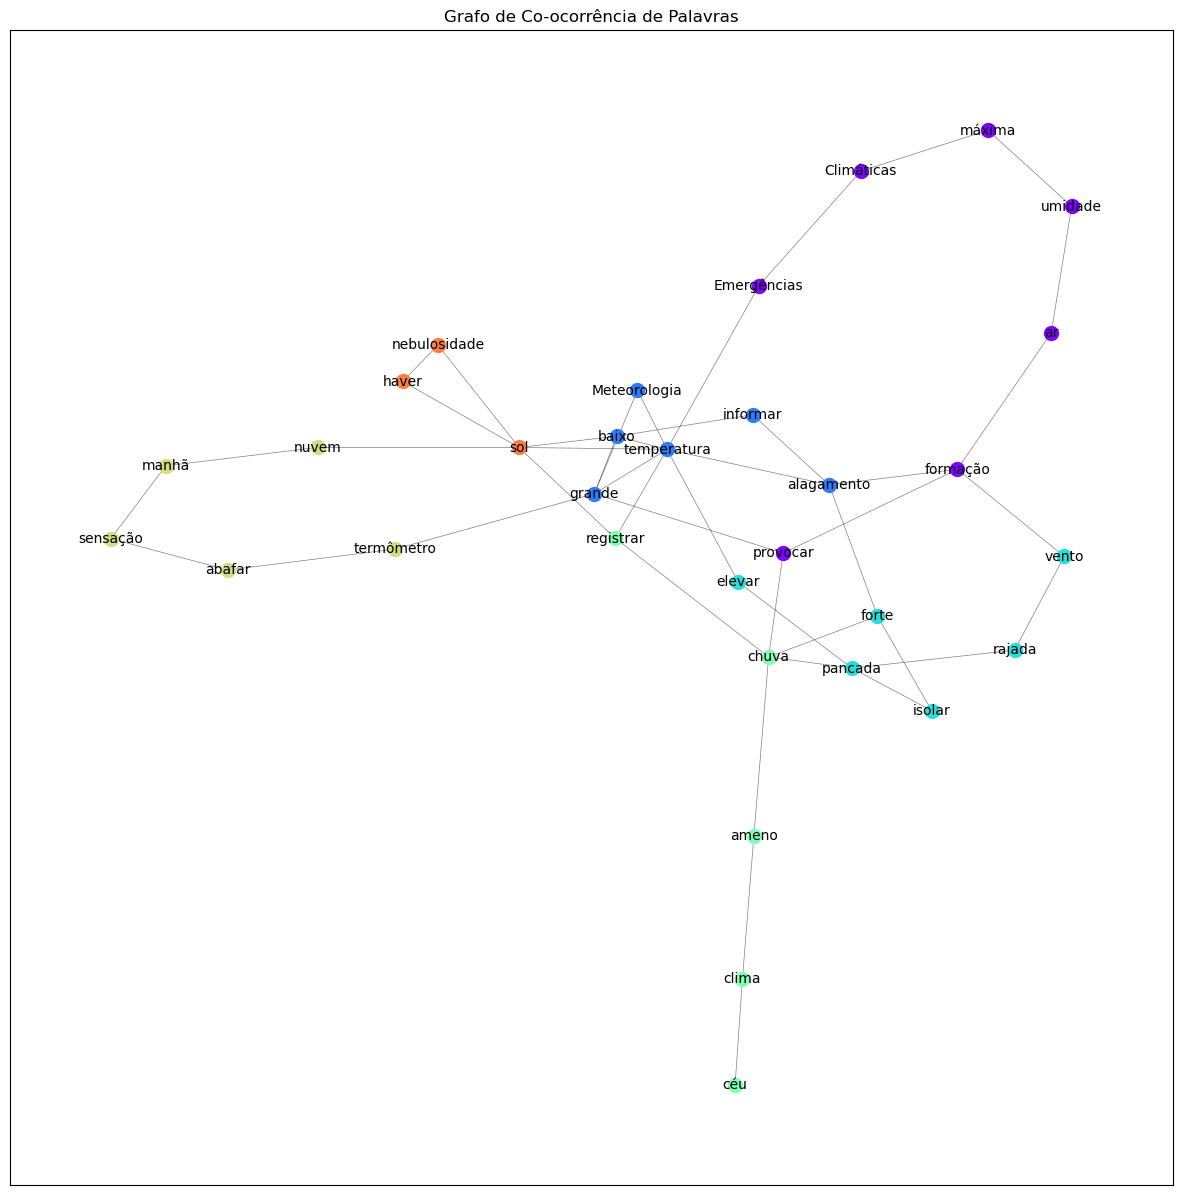


Estatísticas do Grafo:
Número de Nós: 32
Número de Arestas: 45

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 8
Nó: sol, Grau: 6
Nó: chuva, Grau: 5
Nó: grande, Grau: 5
Nó: baixo, Grau: 4
Nó: formação, Grau: 4
Nó: pancada, Grau: 4
Nó: alagamento, Grau: 4
Nó: registrar, Grau: 3
Nó: provocar, Grau: 3
Nó: forte, Grau: 3
Nó: clima, Grau: 2
Nó: ameno, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: nebulosidade, Grau: 2
Nó: haver, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: máxima, Grau: 2
Nó: umidade, Grau: 2
Nó: ar, Grau: 2
Nó: isolar, Grau: 2
Nó: informar, Grau: 2
Nó: nuvem, Grau: 2
Nó: manhã, Grau: 2
Nó: sensação, Grau: 2
Nó: abafar, Grau: 2
Nó: termômetro, Grau: 2
Nó: rajada, Grau: 2
Nó: vento, Grau: 2
Nó: elevar, Grau: 2
Nó: céu, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, pancada), Peso: 3
Aresta: (chuva, provocar), Peso: 2
Aresta: (registrar, sol), Peso: 2
Aresta: (temperatura, baixo), Peso: 2
Aresta: (temperatura, sol), Peso: 2
Aresta: (gr

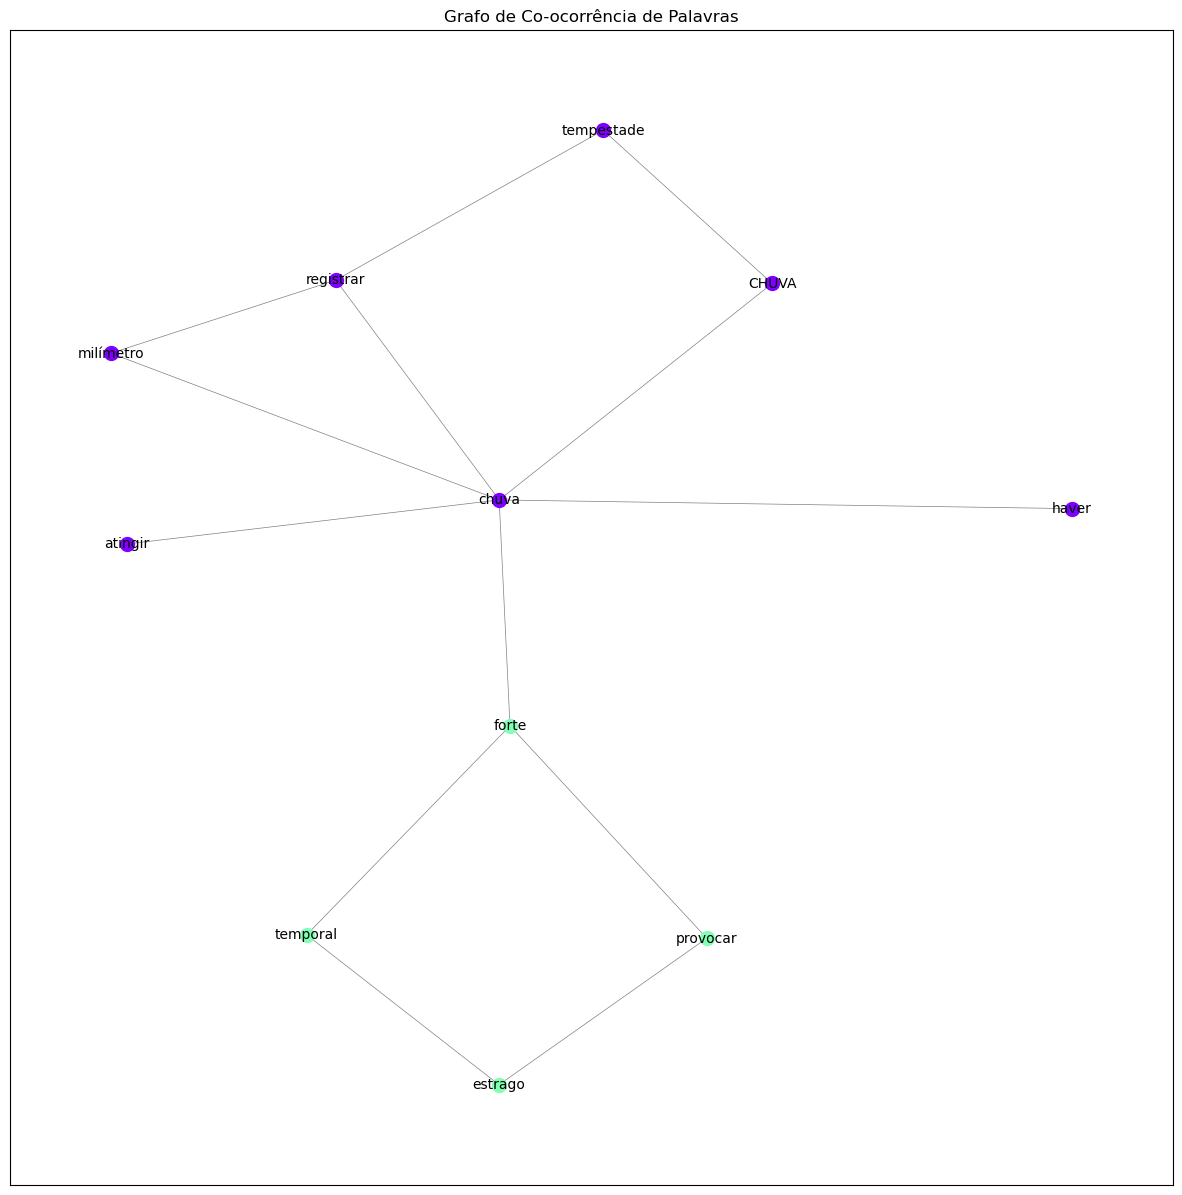


Estatísticas do Grafo:
Número de Nós: 11
Número de Arestas: 13

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 6
Nó: registrar, Grau: 3
Nó: forte, Grau: 3
Nó: milímetro, Grau: 2
Nó: tempestade, Grau: 2
Nó: CHUVA, Grau: 2
Nó: provocar, Grau: 2
Nó: estrago, Grau: 2
Nó: temporal, Grau: 2
Nó: atingir, Grau: 1
Nó: haver, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (milímetro, registrar), Peso: 2
Aresta: (chuva, forte), Peso: 2
Aresta: (chuva, atingir), Peso: 2
Aresta: (milímetro, chuva), Peso: 1
Aresta: (registrar, chuva), Peso: 1
Aresta: (registrar, tempestade), Peso: 1
Aresta: (chuva, CHUVA), Peso: 1
Aresta: (chuva, haver), Peso: 1
Aresta: (tempestade, CHUVA), Peso: 1
Aresta: (forte, provocar), Peso: 1
Aresta: (forte, temporal), Peso: 1
Aresta: (provocar, estrago), Peso: 1
Aresta: (estrago, temporal), Peso: 1

Centralidade de Intermediação dos Nós (Top 10):
Nó: chuva, Centralidade de Intermediação: 0.7667
Nó: forte, Centralidade de Intermediação: 0.4778
Nó: registrar

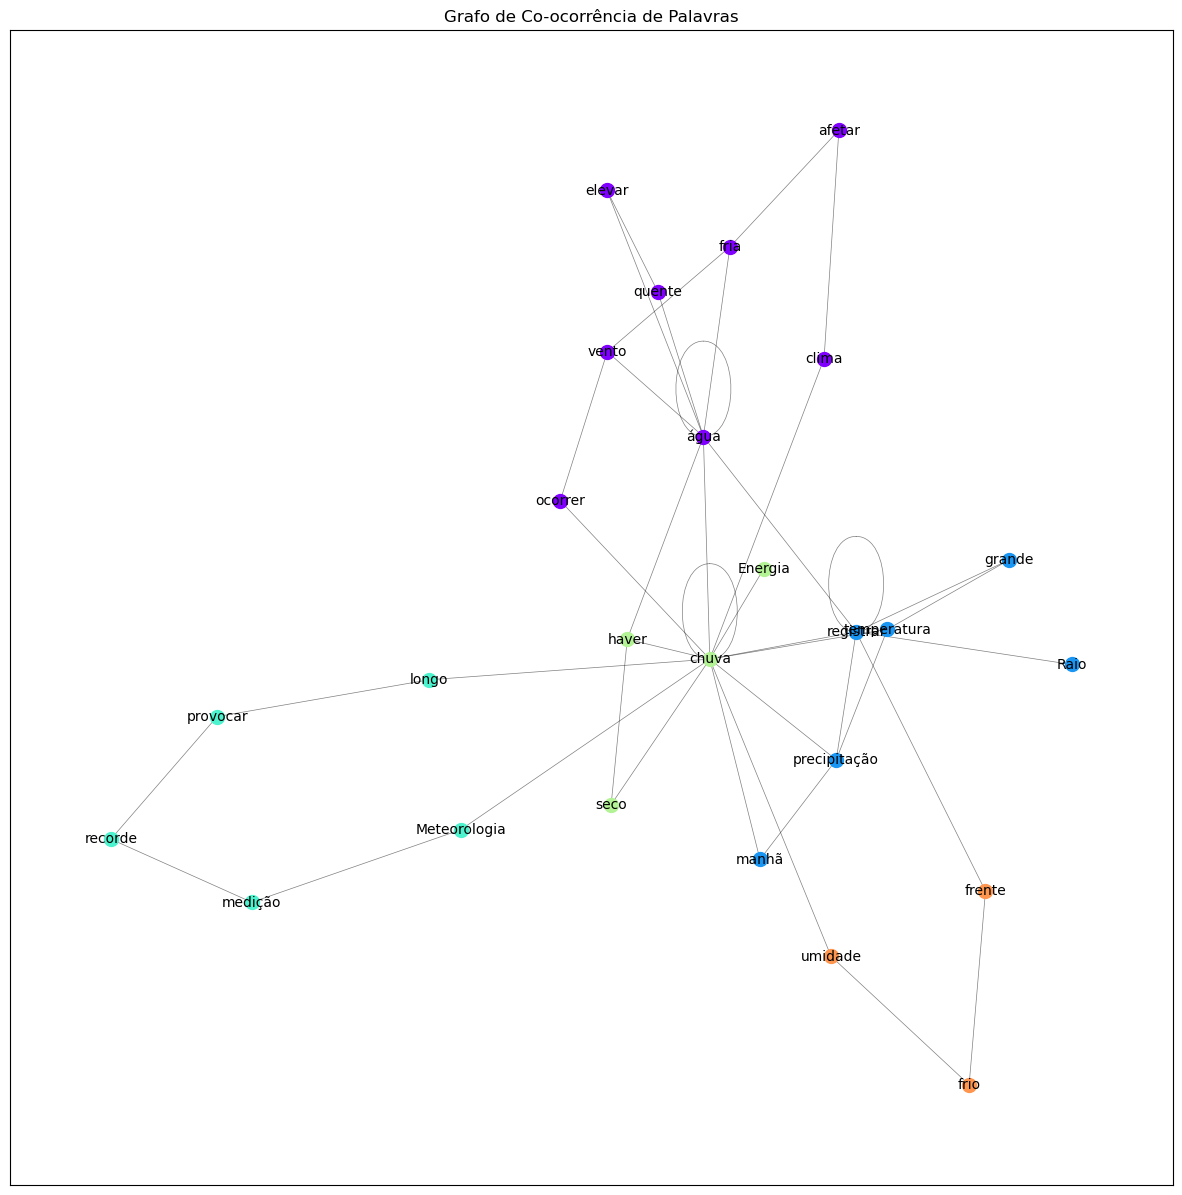


Estatísticas do Grafo:
Número de Nós: 26
Número de Arestas: 41

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 15
Nó: água, Grau: 9
Nó: registrar, Grau: 8
Nó: precipitação, Grau: 4
Nó: haver, Grau: 3
Nó: temperatura, Grau: 3
Nó: vento, Grau: 3
Nó: fria, Grau: 3
Nó: longo, Grau: 2
Nó: provocar, Grau: 2
Nó: recorde, Grau: 2
Nó: medição, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: seco, Grau: 2
Nó: manhã, Grau: 2
Nó: grande, Grau: 2
Nó: frente, Grau: 2
Nó: frio, Grau: 2
Nó: umidade, Grau: 2
Nó: ocorrer, Grau: 2
Nó: quente, Grau: 2
Nó: elevar, Grau: 2
Nó: afetar, Grau: 2
Nó: clima, Grau: 2
Nó: Raio, Grau: 1
Nó: Energia, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (água, quente), Peso: 3
Aresta: (registrar, chuva), Peso: 2
Aresta: (registrar, água), Peso: 2
Aresta: (chuva, haver), Peso: 2
Aresta: (chuva, água), Peso: 2
Aresta: (chuva, Energia), Peso: 2
Aresta: (chuva, chuva), Peso: 2
Aresta: (chuva, temperatura), Peso: 2
Aresta: (água, água), Peso: 2
Aresta: (água, vento), P

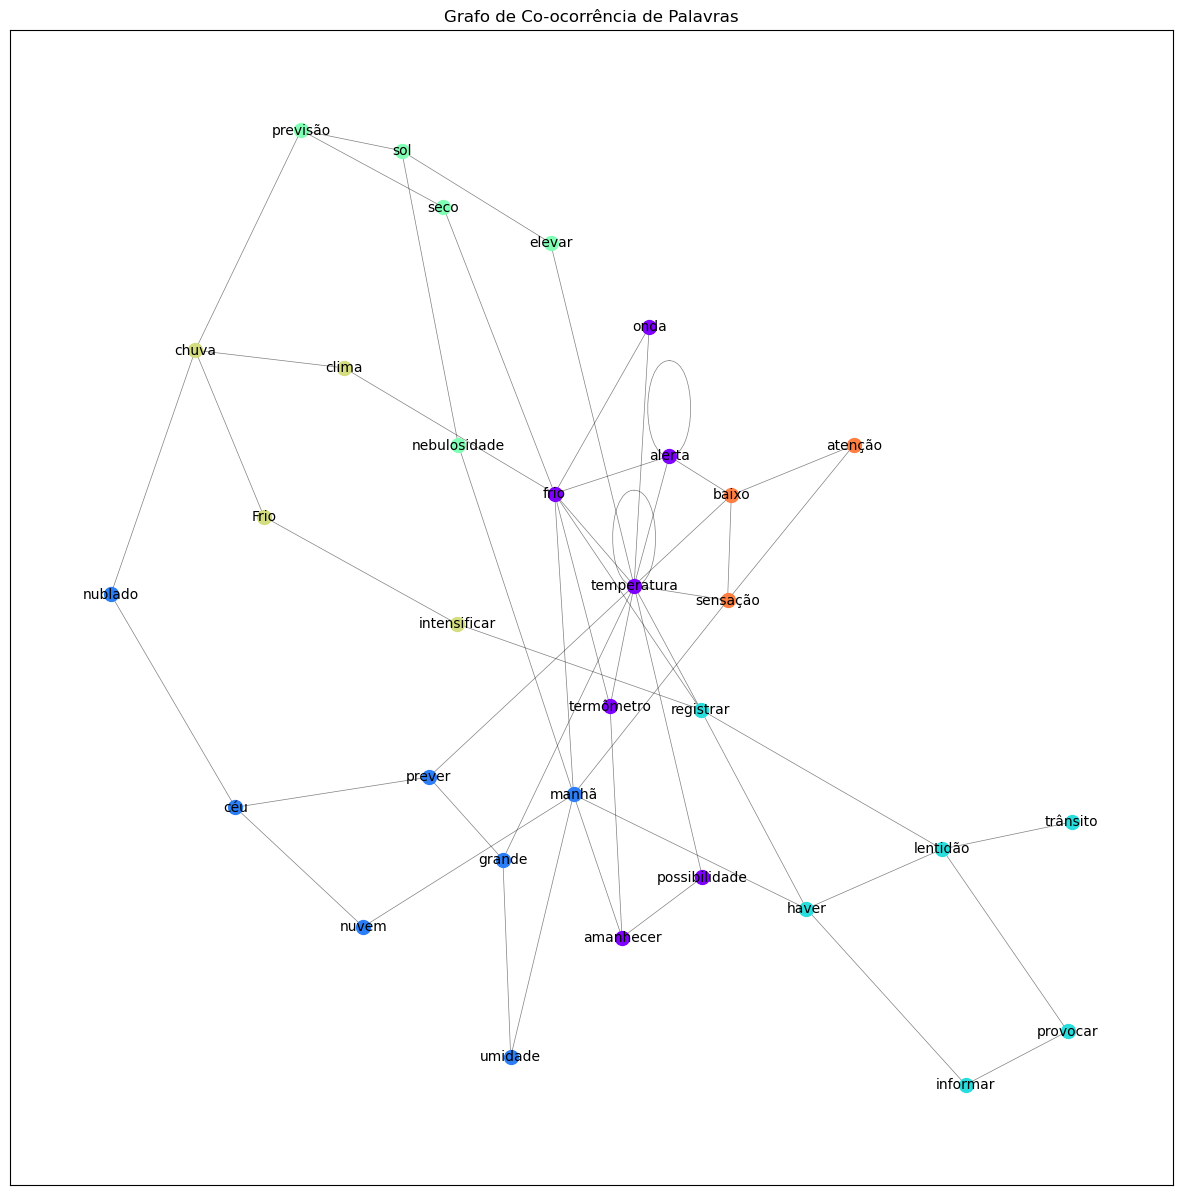


Estatísticas do Grafo:
Número de Nós: 32
Número de Arestas: 54

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 13
Nó: frio, Grau: 8
Nó: manhã, Grau: 7
Nó: registrar, Grau: 5
Nó: alerta, Grau: 5
Nó: sensação, Grau: 4
Nó: baixo, Grau: 4
Nó: chuva, Grau: 4
Nó: haver, Grau: 4
Nó: lentidão, Grau: 4
Nó: céu, Grau: 3
Nó: amanhecer, Grau: 3
Nó: termômetro, Grau: 3
Nó: grande, Grau: 3
Nó: prever, Grau: 3
Nó: previsão, Grau: 3
Nó: sol, Grau: 3
Nó: nuvem, Grau: 2
Nó: nublado, Grau: 2
Nó: clima, Grau: 2
Nó: atenção, Grau: 2
Nó: seco, Grau: 2
Nó: Frio, Grau: 2
Nó: intensificar, Grau: 2
Nó: onda, Grau: 2
Nó: possibilidade, Grau: 2
Nó: nebulosidade, Grau: 2
Nó: elevar, Grau: 2
Nó: umidade, Grau: 2
Nó: provocar, Grau: 2
Nó: informar, Grau: 2
Nó: trânsito, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (temperatura, baixo), Peso: 4
Aresta: (temperatura, sensação), Peso: 3
Aresta: (temperatura, alerta), Peso: 3
Aresta: (manhã, amanhecer), Peso: 2
Aresta: (termômetro, temperatura

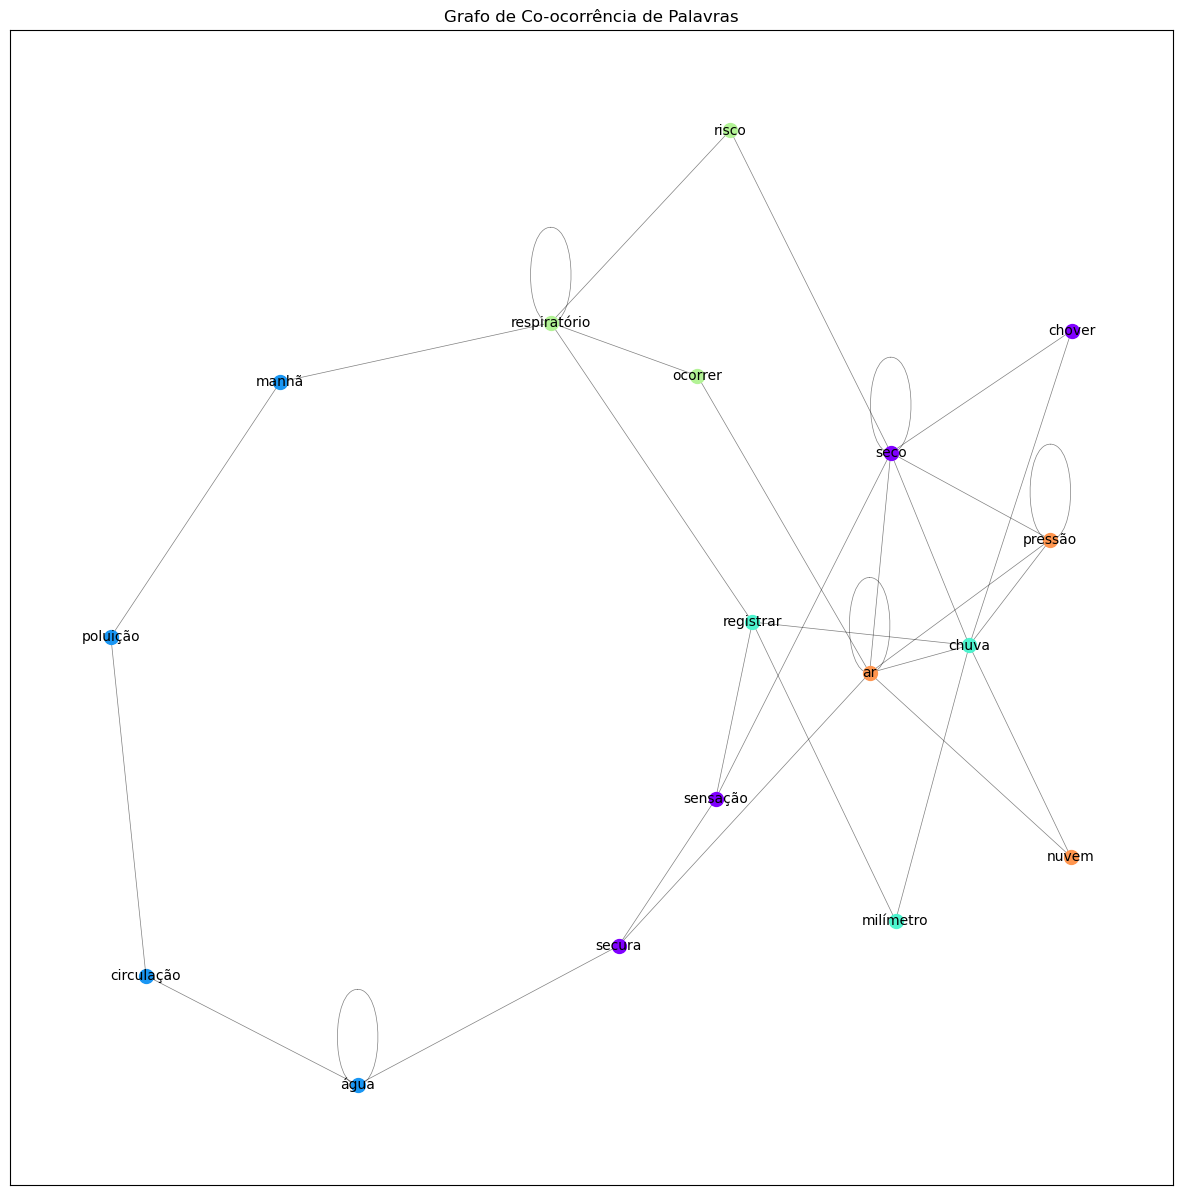


Estatísticas do Grafo:
Número de Nós: 17
Número de Arestas: 32

Grau dos Nós (em ordem decrescente):
Nó: seco, Grau: 8
Nó: ar, Grau: 8
Nó: chuva, Grau: 7
Nó: respiratório, Grau: 6
Nó: pressão, Grau: 5
Nó: registrar, Grau: 4
Nó: água, Grau: 4
Nó: sensação, Grau: 3
Nó: secura, Grau: 3
Nó: milímetro, Grau: 2
Nó: chover, Grau: 2
Nó: risco, Grau: 2
Nó: ocorrer, Grau: 2
Nó: circulação, Grau: 2
Nó: poluição, Grau: 2
Nó: manhã, Grau: 2
Nó: nuvem, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (seco, ar), Peso: 2
Aresta: (chuva, ar), Peso: 2
Aresta: (sensação, secura), Peso: 2
Aresta: (seco, seco), Peso: 1
Aresta: (seco, chuva), Peso: 1
Aresta: (seco, chover), Peso: 1
Aresta: (seco, risco), Peso: 1
Aresta: (seco, sensação), Peso: 1
Aresta: (seco, pressão), Peso: 1
Aresta: (chuva, registrar), Peso: 1
Aresta: (chuva, milímetro), Peso: 1
Aresta: (chuva, chover), Peso: 1
Aresta: (chuva, nuvem), Peso: 1
Aresta: (chuva, pressão), Peso: 1
Aresta: (registrar, milímetro), Peso: 1
Aresta: (re

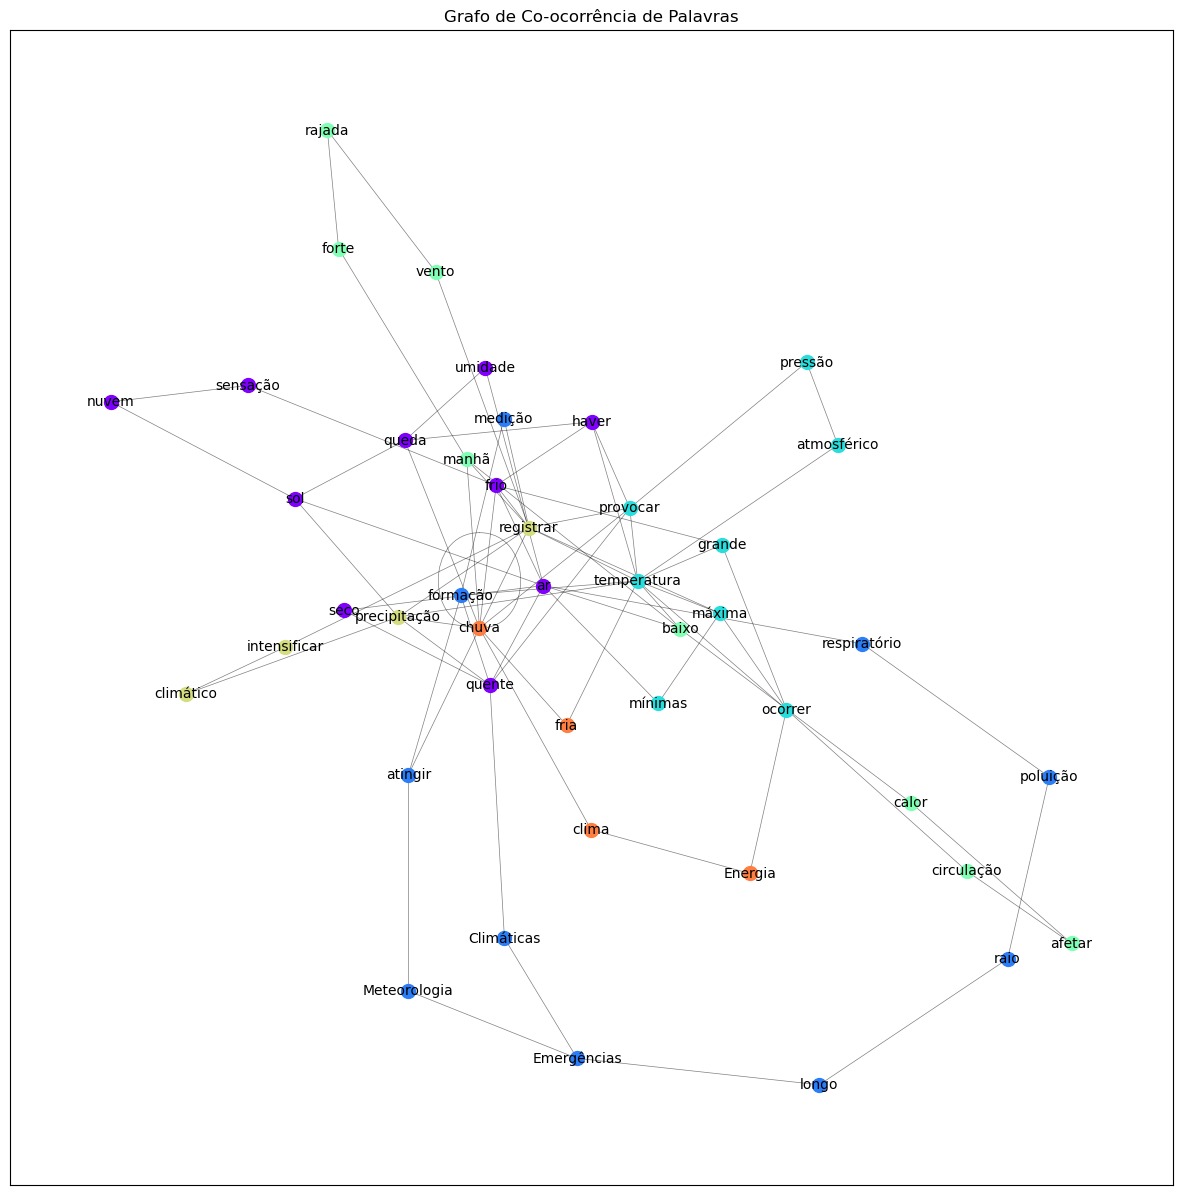


Estatísticas do Grafo:
Número de Nós: 44
Número de Arestas: 78

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 11
Nó: chuva, Grau: 11
Nó: registrar, Grau: 10
Nó: ar, Grau: 8
Nó: frio, Grau: 6
Nó: provocar, Grau: 6
Nó: precipitação, Grau: 6
Nó: quente, Grau: 6
Nó: ocorrer, Grau: 5
Nó: máxima, Grau: 4
Nó: haver, Grau: 4
Nó: baixo, Grau: 4
Nó: queda, Grau: 4
Nó: sol, Grau: 4
Nó: formação, Grau: 4
Nó: manhã, Grau: 4
Nó: grande, Grau: 3
Nó: atingir, Grau: 3
Nó: Emergências, Grau: 3
Nó: calor, Grau: 2
Nó: afetar, Grau: 2
Nó: circulação, Grau: 2
Nó: Energia, Grau: 2
Nó: clima, Grau: 2
Nó: climático, Grau: 2
Nó: intensificar, Grau: 2
Nó: medição, Grau: 2
Nó: fria, Grau: 2
Nó: nuvem, Grau: 2
Nó: sensação, Grau: 2
Nó: mínimas, Grau: 2
Nó: seco, Grau: 2
Nó: pressão, Grau: 2
Nó: atmosférico, Grau: 2
Nó: vento, Grau: 2
Nó: rajada, Grau: 2
Nó: forte, Grau: 2
Nó: umidade, Grau: 2
Nó: respiratório, Grau: 2
Nó: poluição, Grau: 2
Nó: raio, Grau: 2
Nó: longo, Grau: 2
Nó: Climáticas, Grau: 2

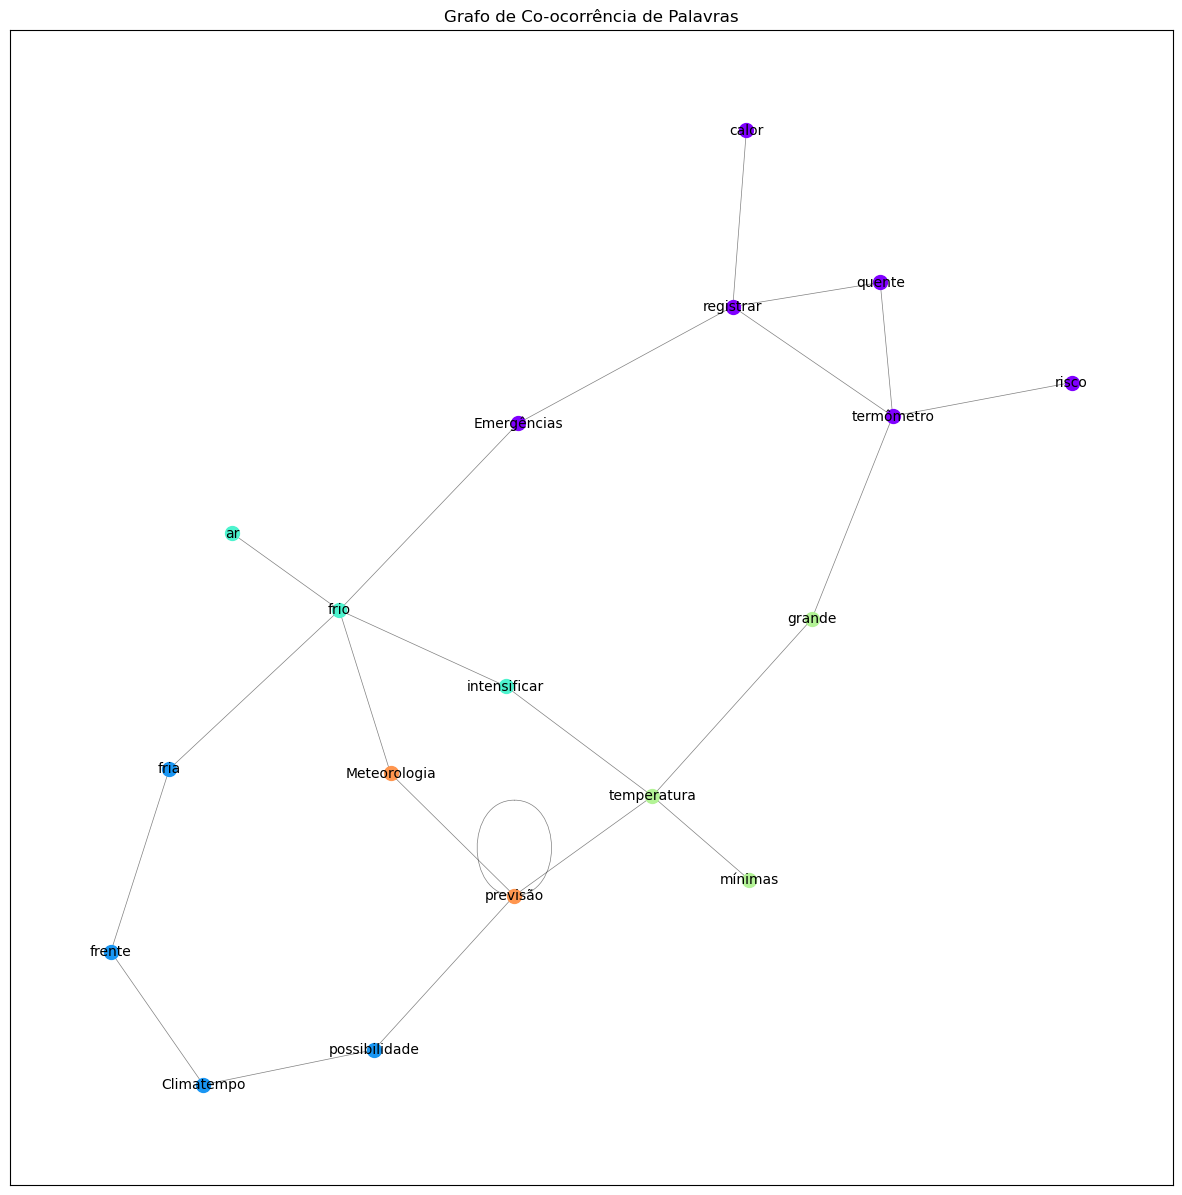


Estatísticas do Grafo:
Número de Nós: 18
Número de Arestas: 22

Grau dos Nós (em ordem decrescente):
Nó: frio, Grau: 5
Nó: previsão, Grau: 5
Nó: termômetro, Grau: 4
Nó: registrar, Grau: 4
Nó: temperatura, Grau: 4
Nó: Emergências, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: possibilidade, Grau: 2
Nó: Climatempo, Grau: 2
Nó: frente, Grau: 2
Nó: fria, Grau: 2
Nó: intensificar, Grau: 2
Nó: grande, Grau: 2
Nó: quente, Grau: 2
Nó: risco, Grau: 1
Nó: ar, Grau: 1
Nó: mínimas, Grau: 1
Nó: calor, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (frio, ar), Peso: 2
Aresta: (previsão, temperatura), Peso: 2
Aresta: (temperatura, mínimas), Peso: 2
Aresta: (risco, termômetro), Peso: 1
Aresta: (termômetro, registrar), Peso: 1
Aresta: (termômetro, grande), Peso: 1
Aresta: (termômetro, quente), Peso: 1
Aresta: (registrar, Emergências), Peso: 1
Aresta: (registrar, quente), Peso: 1
Aresta: (registrar, calor), Peso: 1
Aresta: (Emergências, frio), Peso: 1
Aresta: (frio, Meteorologia), Peso: 1
Aresta: (f

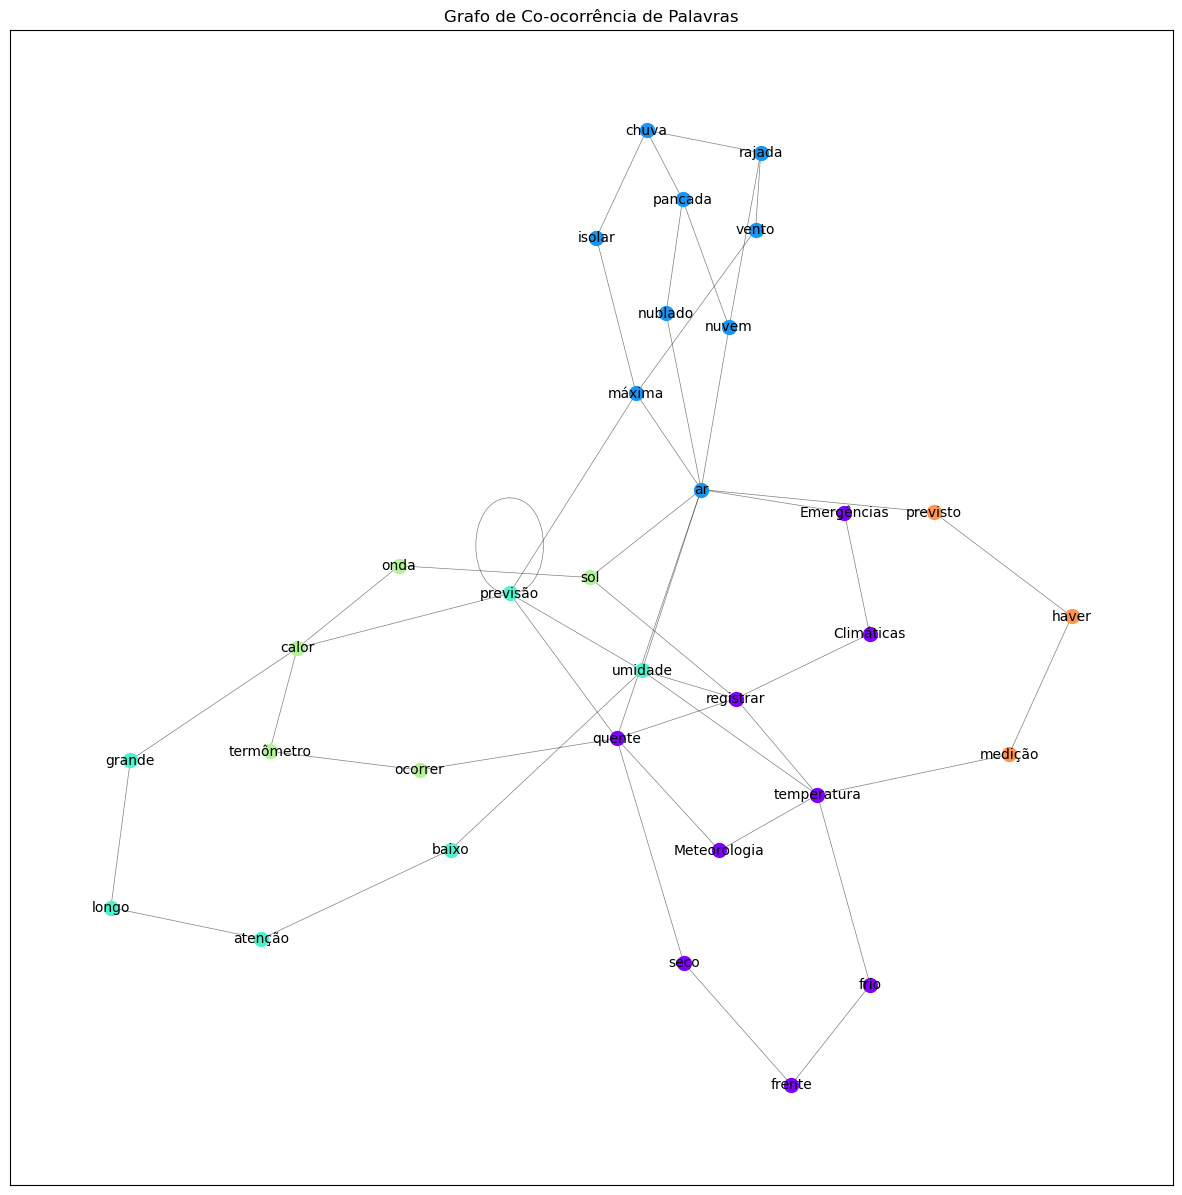


Estatísticas do Grafo:
Número de Nós: 32
Número de Arestas: 48

Grau dos Nós (em ordem decrescente):
Nó: ar, Grau: 8
Nó: quente, Grau: 6
Nó: previsão, Grau: 6
Nó: registrar, Grau: 5
Nó: temperatura, Grau: 5
Nó: umidade, Grau: 5
Nó: calor, Grau: 4
Nó: máxima, Grau: 4
Nó: sol, Grau: 3
Nó: nuvem, Grau: 3
Nó: rajada, Grau: 3
Nó: pancada, Grau: 3
Nó: chuva, Grau: 3
Nó: Meteorologia, Grau: 2
Nó: ocorrer, Grau: 2
Nó: termômetro, Grau: 2
Nó: grande, Grau: 2
Nó: longo, Grau: 2
Nó: atenção, Grau: 2
Nó: baixo, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: medição, Grau: 2
Nó: haver, Grau: 2
Nó: previsto, Grau: 2
Nó: seco, Grau: 2
Nó: frente, Grau: 2
Nó: frio, Grau: 2
Nó: onda, Grau: 2
Nó: vento, Grau: 2
Nó: isolar, Grau: 2
Nó: nublado, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (ar, máxima), Peso: 4
Aresta: (ar, nuvem), Peso: 3
Aresta: (pancada, chuva), Peso: 3
Aresta: (registrar, temperatura), Peso: 2
Aresta: (umidade, ar), Peso: 2
Aresta: (máxima, isolar), Peso: 2

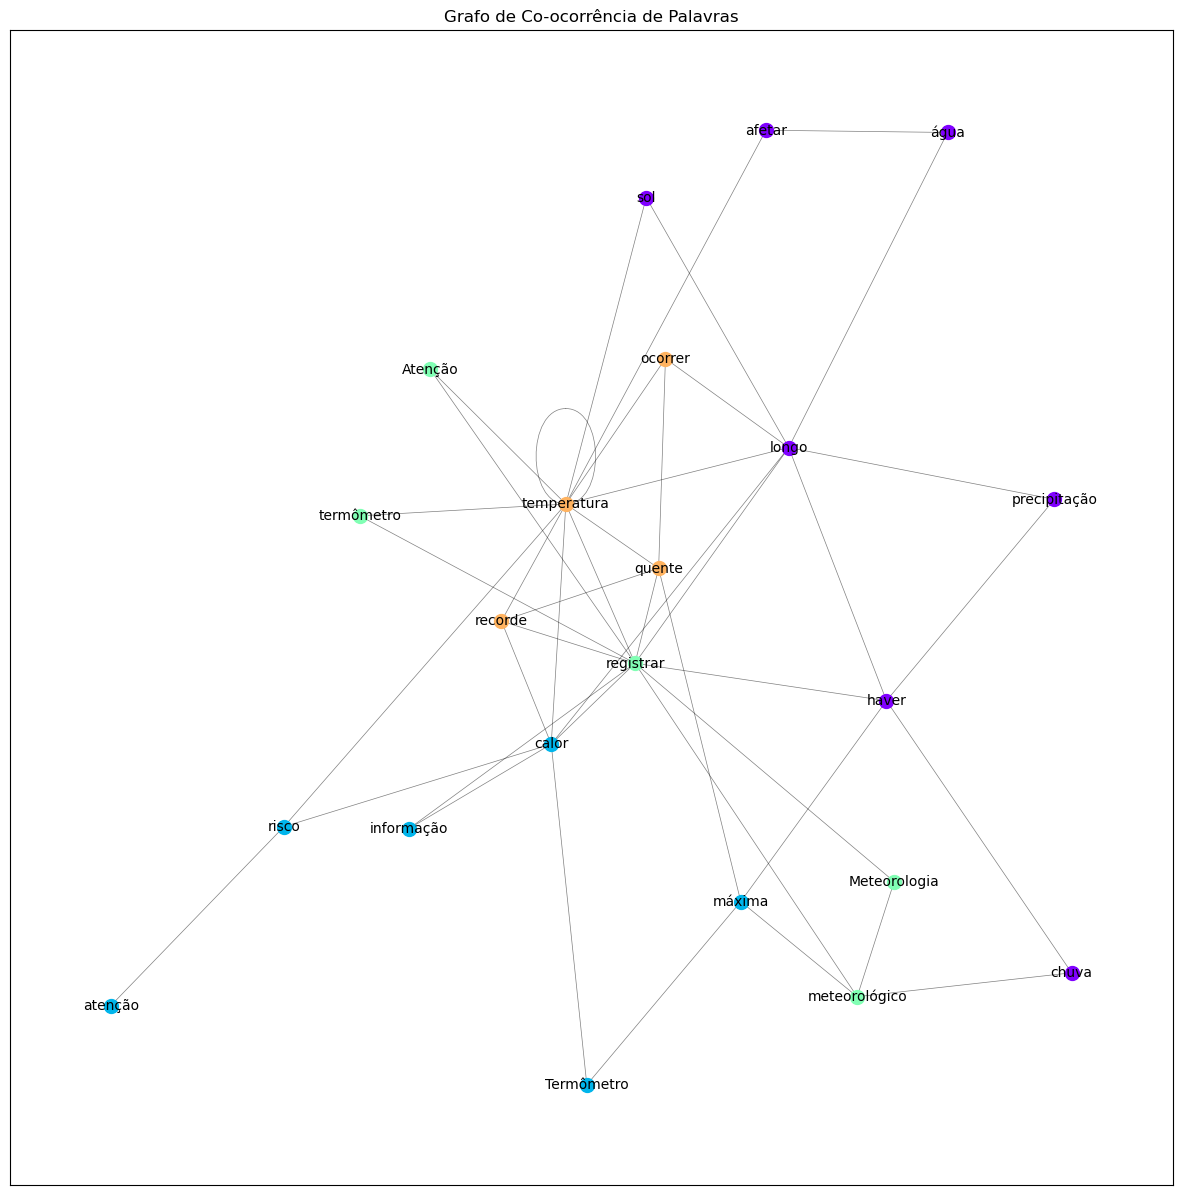


Estatísticas do Grafo:
Número de Nós: 22
Número de Arestas: 44

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 13
Nó: registrar, Grau: 11
Nó: longo, Grau: 8
Nó: calor, Grau: 7
Nó: quente, Grau: 5
Nó: haver, Grau: 5
Nó: recorde, Grau: 4
Nó: meteorológico, Grau: 4
Nó: máxima, Grau: 4
Nó: ocorrer, Grau: 3
Nó: risco, Grau: 3
Nó: Meteorologia, Grau: 2
Nó: termômetro, Grau: 2
Nó: chuva, Grau: 2
Nó: precipitação, Grau: 2
Nó: Termômetro, Grau: 2
Nó: informação, Grau: 2
Nó: afetar, Grau: 2
Nó: água, Grau: 2
Nó: sol, Grau: 2
Nó: Atenção, Grau: 2
Nó: atenção, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (calor, registrar), Peso: 6
Aresta: (temperatura, registrar), Peso: 6
Aresta: (temperatura, temperatura), Peso: 3
Aresta: (calor, recorde), Peso: 2
Aresta: (recorde, quente), Peso: 2
Aresta: (quente, ocorrer), Peso: 2
Aresta: (registrar, haver), Peso: 2
Aresta: (risco, atenção), Peso: 2
Aresta: (calor, Termômetro), Peso: 1
Aresta: (calor, longo), Peso: 1
Aresta: (calor, 

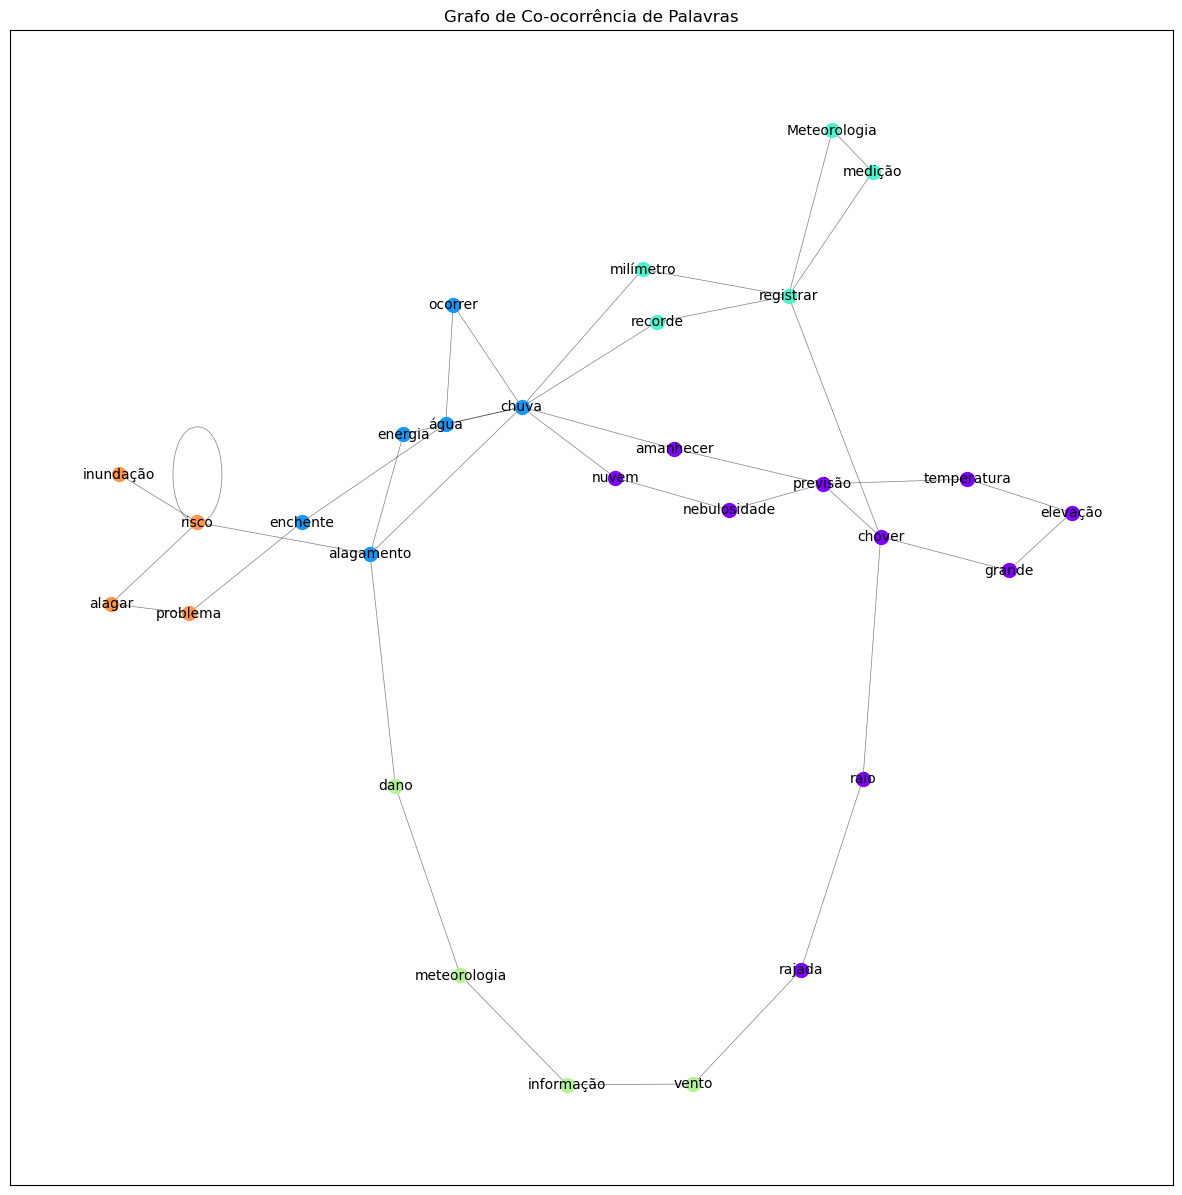


Estatísticas do Grafo:
Número de Nós: 29
Número de Arestas: 38

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 8
Nó: registrar, Grau: 5
Nó: risco, Grau: 5
Nó: chover, Grau: 4
Nó: previsão, Grau: 4
Nó: alagamento, Grau: 4
Nó: água, Grau: 3
Nó: Meteorologia, Grau: 2
Nó: medição, Grau: 2
Nó: milímetro, Grau: 2
Nó: recorde, Grau: 2
Nó: amanhecer, Grau: 2
Nó: nuvem, Grau: 2
Nó: nebulosidade, Grau: 2
Nó: temperatura, Grau: 2
Nó: elevação, Grau: 2
Nó: grande, Grau: 2
Nó: raio, Grau: 2
Nó: rajada, Grau: 2
Nó: vento, Grau: 2
Nó: informação, Grau: 2
Nó: meteorologia, Grau: 2
Nó: dano, Grau: 2
Nó: energia, Grau: 2
Nó: alagar, Grau: 2
Nó: problema, Grau: 2
Nó: enchente, Grau: 2
Nó: ocorrer, Grau: 2
Nó: inundação, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, água), Peso: 4
Aresta: (risco, inundação), Peso: 2
Aresta: (registrar, Meteorologia), Peso: 1
Aresta: (registrar, medição), Peso: 1
Aresta: (registrar, milímetro), Peso: 1
Aresta: (registrar, recorde), Peso: 1
Arest

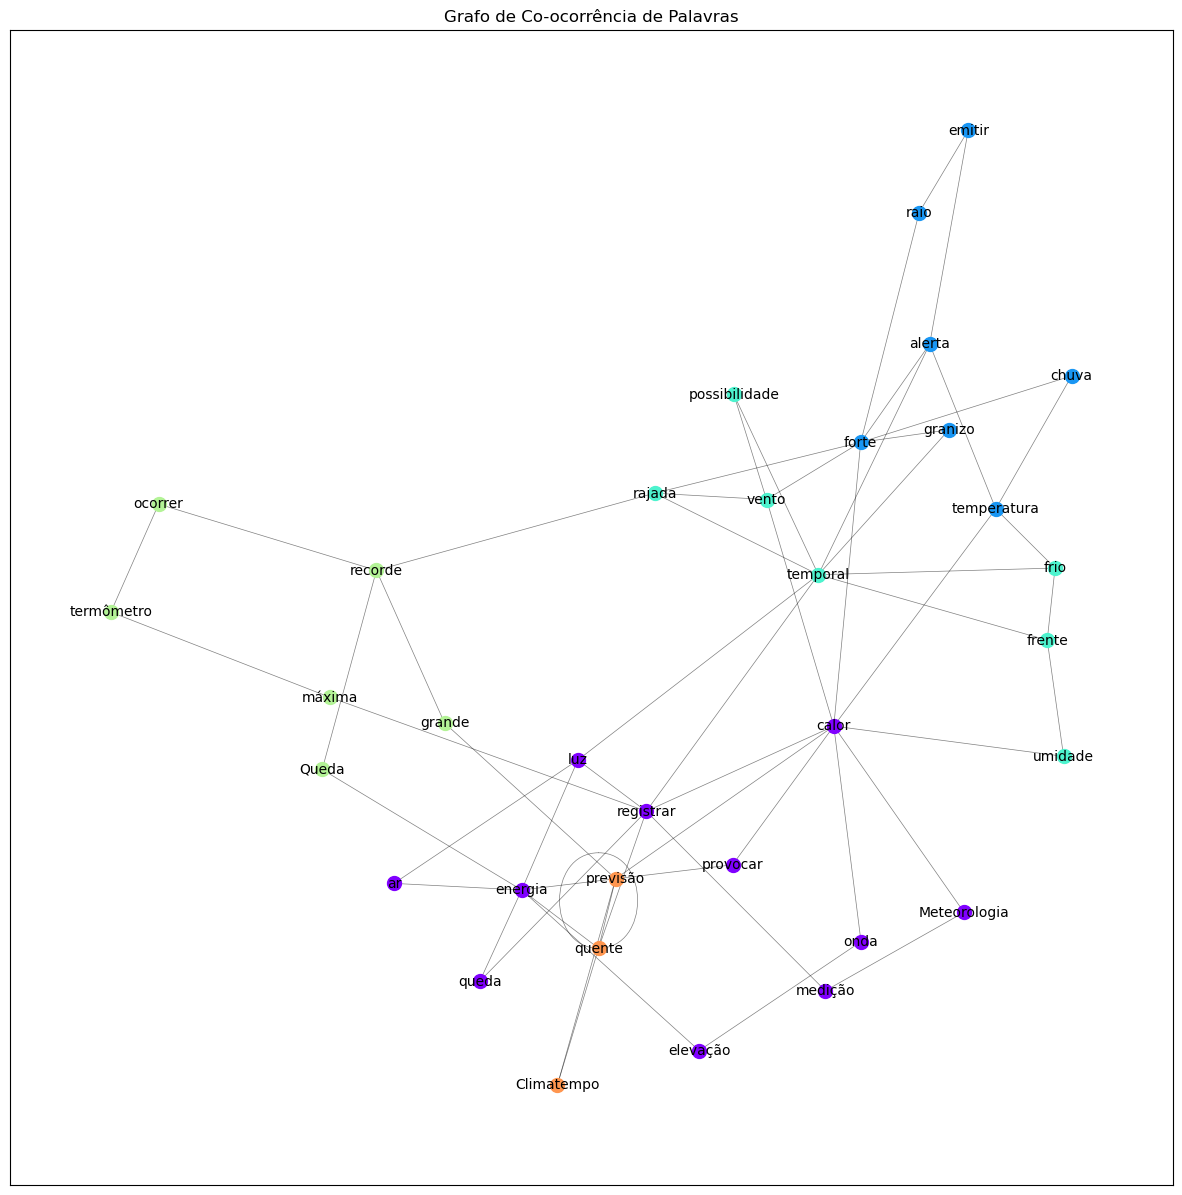


Estatísticas do Grafo:
Número de Nós: 34
Número de Arestas: 58

Grau dos Nós (em ordem decrescente):
Nó: calor, Grau: 9
Nó: temporal, Grau: 8
Nó: forte, Grau: 7
Nó: registrar, Grau: 7
Nó: energia, Grau: 7
Nó: quente, Grau: 6
Nó: previsão, Grau: 4
Nó: recorde, Grau: 4
Nó: temperatura, Grau: 4
Nó: alerta, Grau: 4
Nó: vento, Grau: 4
Nó: rajada, Grau: 4
Nó: luz, Grau: 4
Nó: frente, Grau: 3
Nó: frio, Grau: 3
Nó: Climatempo, Grau: 2
Nó: grande, Grau: 2
Nó: ocorrer, Grau: 2
Nó: termômetro, Grau: 2
Nó: máxima, Grau: 2
Nó: medição, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: chuva, Grau: 2
Nó: raio, Grau: 2
Nó: emitir, Grau: 2
Nó: umidade, Grau: 2
Nó: granizo, Grau: 2
Nó: possibilidade, Grau: 2
Nó: Queda, Grau: 2
Nó: queda, Grau: 2
Nó: ar, Grau: 2
Nó: elevação, Grau: 2
Nó: onda, Grau: 2
Nó: provocar, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (forte, vento), Peso: 3
Aresta: (registrar, quente), Peso: 3
Aresta: (vento, rajada), Peso: 3
Aresta: (calor, registrar), Peso: 2
Aresta: (frent

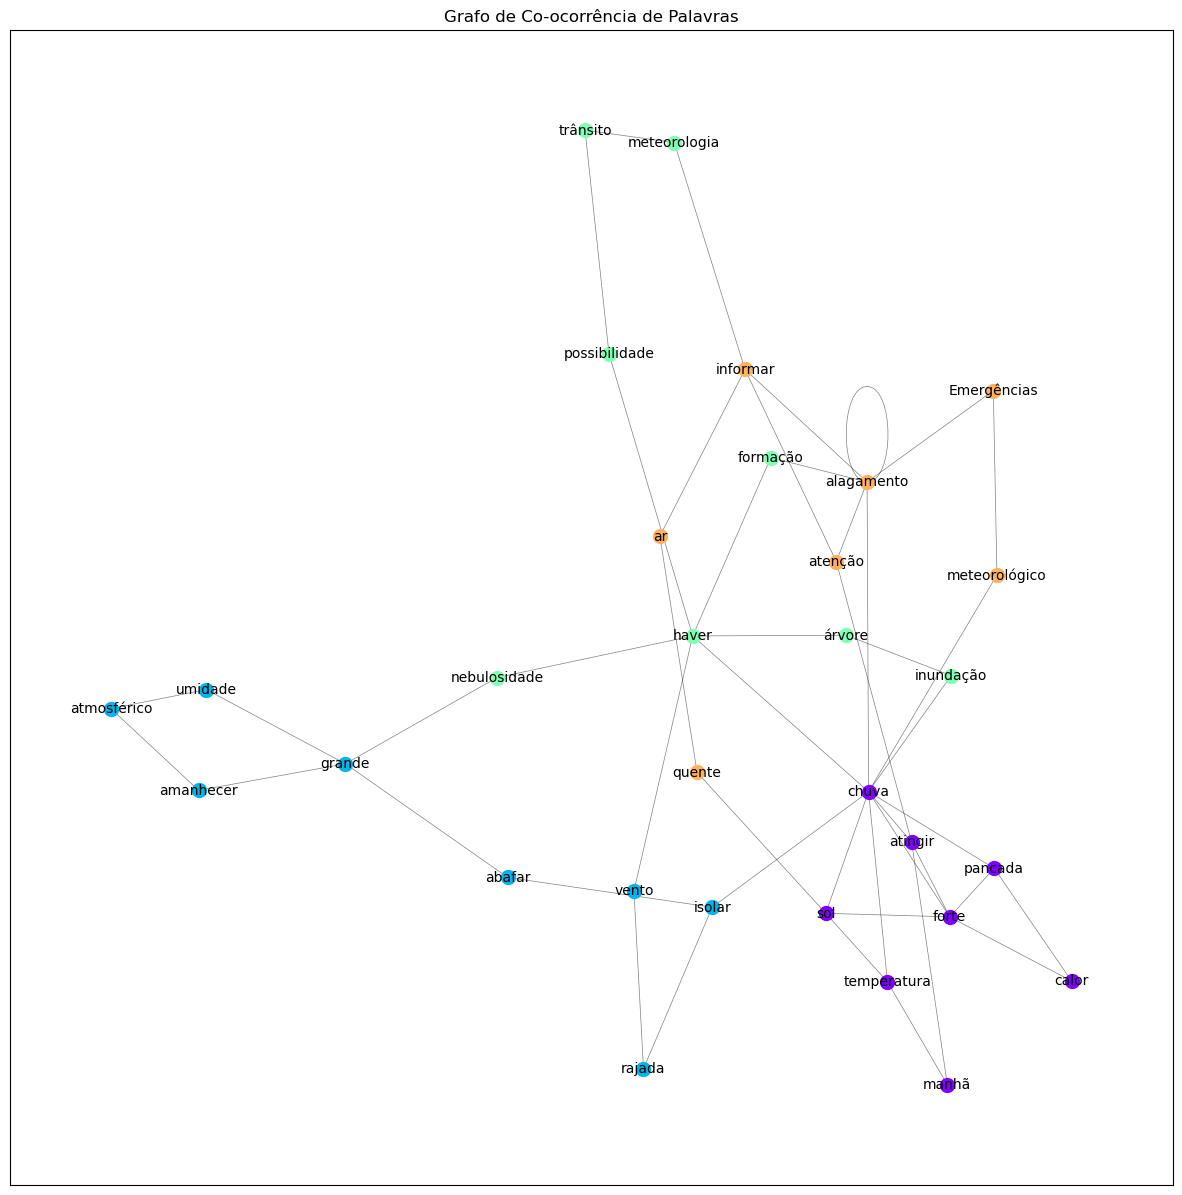


Estatísticas do Grafo:
Número de Nós: 31
Número de Arestas: 47

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 10
Nó: alagamento, Grau: 7
Nó: haver, Grau: 6
Nó: forte, Grau: 5
Nó: atingir, Grau: 4
Nó: informar, Grau: 4
Nó: sol, Grau: 4
Nó: grande, Grau: 4
Nó: temperatura, Grau: 3
Nó: atenção, Grau: 3
Nó: pancada, Grau: 3
Nó: isolar, Grau: 3
Nó: manhã, Grau: 2
Nó: Emergências, Grau: 2
Nó: meteorológico, Grau: 2
Nó: rajada, Grau: 2
Nó: vento, Grau: 2
Nó: formação, Grau: 2
Nó: inundação, Grau: 2
Nó: árvore, Grau: 2
Nó: possibilidade, Grau: 2
Nó: trânsito, Grau: 2
Nó: meteorologia, Grau: 2
Nó: ar, Grau: 2
Nó: quente, Grau: 2
Nó: calor, Grau: 2
Nó: abafar, Grau: 2
Nó: umidade, Grau: 2
Nó: atmosférico, Grau: 2
Nó: amanhecer, Grau: 2
Nó: nebulosidade, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, forte), Peso: 2
Aresta: (chuva, temperatura), Peso: 2
Aresta: (chuva, pancada), Peso: 2
Aresta: (chuva, isolar), Peso: 2
Aresta: (atenção, alagamento), Peso: 2
Aresta: (al

In [ ]:
for url in urls_G1_2023:
    print(f"\nAnalisando link do ano 2023: {url}")
    texto = coletar_texto(url)
    G = construir_grafo(texto)
    plotar_grafo(G)
    estatisticas_grafo(G)
    print()
    detectar_comunidades(G)

# **Análises dos grafos do ano de 2023**

**Análise do Grafo do Mês 01 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/01/09/cidade-de-sao-paulo-tem-o-inicio-de-ano-mais-frio-desde-1982-diz-inmet.ghtml)**

Número de Nós: 32, Número de Arestas: 45

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (8), seguida por "sol" (6), "chuva" (5) e "grande" (5), indicando um período de clima mais frio, com incidência de sol e chuvas intensas, comuns durante o verão. A presença de arestas com peso mais elevado, como (chuva, pancada) com peso 3 e (chuva, provocar) com peso 2, reforça a ocorrência de chuvas fortes e isoladas.

A centralidade de intermediação do nó "temperatura" é de 36,91%, destacando-o como ponto central de conexão entre outros nós no grafo. Os nós "chuva" com 25,25% e "sol" com 25,19% também são centrais, sugerindo que o foco está nas variações de temperatura e no clima chuvoso e quente característico de janeiro.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 13,15%, o grafo exibe baixa conectividade entre os termos, indicando que os subtemas abordados são relativamente independentes entre si.

Modularidade das Comunidades: A modularidade de 42,62% reflete uma estrutura razoavelmente definida, permitindo a identificação de seis comunidades:

Comunidade 1: "ar", "formação", "umidade", "provocar", "Emergências", "máxima", "Climáticas". Esta comunidade está relacionada às condições de umidade e máximas de temperatura, possivelmente ligadas a alertas climáticos.

Comunidade 2: "grande", "temperatura", "baixo", "Meteorologia", "informar", "alagamento". Focada em condições meteorológicas, essa comunidade destaca temperaturas elevadas e a ocorrência de alagamentos.

Comunidade 3: "vento", "forte", "isolar", "rajada", "elevar", "pancada". Relacionada a rajadas de vento e pancadas de chuva, caracterizando o impacto de eventos climáticos mais intensos e pontuais.

Comunidade 4: "registrar", "clima", "chuva", "ameno", "céu". Essa comunidade abrange o registro de chuvas e um clima mais ameno, incluindo aspectos de céu nublado.

Comunidade 5: "termômetro", "nuvem", "abafar", "manhã", "sensação". Relacionada a variações de temperatura ao longo do dia, especialmente pela manhã, e à sensação térmica abafada.

Comunidade 6: "haver", "sol", "nebulosidade". Refere-se à incidência de sol e nebulosidade, comuns em períodos de transição entre sol e chuva.

Este primeiro grafo reflete uma notícia de janeiro de 2023, com foco em um clima quente e úmido, marcado por chuvas intensas e frequentes, típicas do verão. A centralidade de "temperatura" e sua conexão com "chuva" e "sol" indicam um clima variado, com temperaturas altas e chuvas que causam alagamentos e sensação de abafamento. A presença de comunidades ligadas a "formação" e "Meteorologia" reforça o monitoramento das condições climáticas e a preocupação com possíveis emergências associadas ao clima.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 02 de 2023 (https://g1.globo.com/sp/mogi-das-cruzes-suzano/noticia/2023/02/28/fevereiro-de-2023-foi-o-mes-mais-chuvoso-dos-ultimos-quatro-anos-nas-represas-do-alto-tiete-mostra-levantamento.ghtml)**

Número de Nós: 11, Número de Arestas: 13

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (6), seguida por "registrar" (3), "forte" (3) e "milímetro" (2), indicando um período marcado por chuvas intensas com volumes (milímetros) significativos. As arestas mais fortes, como (milímetro, registrar) com peso 2 e (chuva, forte) com peso 2, reforçam a presença de chuvas intensas, provavelmente com acúmulo de grandes volumes de água.

A centralidade de intermediação do nó "chuva" é de 76,67%, posicionando-o como o principal ponto de conexão entre outros termos no grafo. Os nós "forte" com 47,78% e "registrar" com 10,00% também exercem papel relevante nas conexões, reforçando a ideia de um evento climático com chuvas intensas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 12,73%, o grafo apresenta baixa conectividade entre os nós, sugerindo que os subtemas são relativamente independentes entre si.

Modularidade das Comunidades: A modularidade de 30,47% indica uma estrutura de comunidades moderadamente definida, permitindo a identificação de duas comunidades principais:

Comunidade 1: "registrar", "atingir", "chuva", "milímetro", "haver", "tempestade". Esta comunidade foca nos registros de precipitação, destacando a intensidade e o acúmulo de chuva, possivelmente indicando volumes altos de milímetros registrados.

Comunidade 2: "estrago", "temporal", "forte", "provocar". Relacionada aos impactos das chuvas, essa comunidade enfatiza os danos causados por temporais, sugerindo que as chuvas resultaram em estragos significativos.

Este segundo grafo reflete uma notícia de fevereiro de 2023, com foco em chuvas intensas e fortes temporais que resultaram em danos. A centralidade de "chuva" e as conexões com "forte" e "milímetro" indicam registros de precipitação em grandes volumes, sugerindo eventos climáticos significativos. A presença das comunidades ligadas a "registrar" e "estrago" reforça a ideia de que as chuvas causaram impactos notáveis, com potenciais danos aos locais afetados.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 03 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/03/02/cidade-de-sp-tem-o-terceiro-mes-de-fevereiro-mais-chuvoso-da-historia-diz-inmet.ghtml)**

Número de Nós: 26, Número de Arestas: 41

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (15), seguida por "água" (9), "registrar" (8) e "precipitação" (4). Isso indica que a notícia foca em registros de chuvas intensas, com grande quantidade de água, reforçado pelo peso das arestas (água, quente) com peso 3 e (registrar, chuva) com peso 2.

A centralidade de intermediação do nó "chuva" é de 69,83%, mostrando que ele serve como o principal ponto de conexão no grafo. Os nós "água" com 26,83% e "registrar" com 21,33% também são centrais, sugerindo que o foco está em um clima com registros abundantes de chuva e muita água.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 25,26%, o grafo apresenta baixa conectividade entre os nós, sugerindo subtemas distintos relacionados às condições climáticas reportadas.

Modularidade das Comunidades: A modularidade de 41,81% indica uma estrutura razoavelmente definida de comunidades. Foram detectadas cinco comunidades no grafo:

- Comunidade 1: "clima", "vento", "fria", "afetar", "água", "elevar", "ocorrer", "quente". Esta comunidade foca nos efeitos da chuva e nas mudanças de temperatura, sugerindo um impacto direto do clima sobre a sensação térmica.

- Comunidade 2: "Raio", "registrar", "precipitação", "grande", "temperatura", "manhã". Relacionada ao registro de precipitações e à temperatura elevada, enfatizando o impacto dos raios durante a manhã.

- Comunidade 3: "medição", "provocar", "recorde", "longo", "Meteorologia". Focada na medição de chuvas, destaca recordes de precipitação ao longo do período.

- Comunidade 4: "haver", "Energia", "chuva", "seco". A presença de "energia" e "seco" sugere uma análise do impacto da chuva em regiões com falta d'água.

- Comunidade 5: "umidade", "frente", "frio". Esta comunidade se refere a variações na umidade e mudanças de frente fria.

Este terceiro grafo reflete uma notícia de março de 2023, que descreve chuvas intensas, grandes volumes de água e impactos associados, como alterações na umidade e temperatura. A centralidade de "chuva" e suas conexões com "água" e "registrar" reforçam o foco no monitoramento de precipitações. As comunidades destacam diferentes aspectos do evento climático, como medições recordes e impactos locais, mostrando uma análise abrangente das condições e previsões meteorológicas para o período.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 04 de 2023 (https://g1.globo.com/meio-ambiente/noticia/2024/04/23/quarta-onda-de-calor-do-ano-deve-se-estender-ate-a-proxima-semana-temperaturas-podem-chegar-a-35c.ghtml)**

Número de Nós: 27, Número de Arestas: 59

**Principais Nós e Centralidade**

A palavra "calor" possui o maior grau (13), seguida por "temperatura" (12), "ar" (8) e "atmosférico" (8), indicando que essa quarta notícia do mês de abril destaca temperaturas elevadas, com o calor como tema central. Esse fato é reforçado pela presença de arestas com peso elevado, como (onda, calor) com peso 12 e (frente, frio) com peso 5, que sugerem uma onda de calor e uma possível frente fria subsequente.

A centralidade de intermediação do nó "temperatura" é de 27,65%, destacando-o como um importante ponto de conexão entre outros nós no grafo. Os nós "calor" com 22,66% e "ar" com 19,49% também são centrais, reforçando a ideia de que a notícia trata de uma elevação significativa de temperatura devido a uma onda de calor.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 23,44%, o grafo apresenta baixa conectividade entre os nós, sugerindo que os subtemas abordados são relativamente independentes entre si.

Modularidade das Comunidades: A modularidade de 21,49% indica uma estrutura razoavelmente definida, permitindo a identificação de cinco comunidades:

- Comunidade 1: "meteorologia", "formação", "pressão", "mínimas", "climático", "ocorrer", "ar", "baixo". Esta comunidade está relacionada às condições atmosféricas gerais, como a pressão e as mínimas temperaturas, influenciadas pela presença de ar frio.

- Comunidade 2: "Climatempo", "onda", "atingir", "previsão", "temperatura", "meteorológico". Focada em previsões climáticas, essa comunidade destaca uma onda de calor que impacta as condições meteorológicas.

- Comunidade 3: "calor", "seco", "atmosférico", "elevar", "quente". Relacionada à onda de calor e ao clima seco, essa comunidade caracteriza um período de elevação de temperatura.

- Comunidade 4: "registrar", "termômetro", "grande", "forte". Esta comunidade abrange o registro de altas temperaturas, capturadas pelo termômetro, indicando intensidade.

- Comunidade 5: "vento", "frente", "circulação", "frio". Refere-se a uma possível frente fria, com a presença de vento e circulação de ar frio após o período de calor.

Este quarto grafo reflete uma notícia de abril de 2023, com foco em uma onda de calor intensa, marcada por altas temperaturas e clima seco. A centralidade de "temperatura" e "calor" sugere um evento climático extremo, e as comunidades refletem tanto a elevação de temperatura quanto a possibilidade de uma frente fria subsequente.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 05 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/05/23/mes-de-maio-e-o-mais-seco-desde-2020-em-sp-especialistas-dao-dicas-de-como-amenizar-sensacao-de-secura.ghtml)**

Número de Nós: 17, Número de Arestas: 32

**Principais Nós e Centralidade**

A palavra "seco" possui o maior grau (8), seguida por "ar" (8), "chuva" (7) e "respiratório" (6), o que sugere um período marcado por condições de clima seco que podem prejudicar o sistema respiratório. As arestas com maior peso, como (seco, ar) e (chuva, ar) com peso 2, reforçam a predominância de ar seco, indicando um potencial impacto na saúde respiratória.

A centralidade de intermediação do nó "ar" é de 24,58%, mostrando seu papel central na conexão entre outros nós no grafo. O nó "respiratório" tem centralidade de 23,12%, seguido de "secura" com 19,17%, ressaltando o foco no clima seco e na possibilidade de problemas respiratórios associados.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 29,33%, o grafo exibe uma conectividade relativa entre os termos, indicando que os subtemas são em grande parte independentes.

Modularidade das Comunidades: A modularidade de 32,94% reflete uma estrutura razoavelmente definida, permitindo a identificação de cinco comunidades:

- Comunidade 1: "seco", "secura", "chover", "sensação". Esta comunidade está associada à sensação de secura e à ausência de chuva.

- Comunidade 2: "água", "manhã", "circulação", "poluição". Focada nos efeitos da circulação e poluição de ar, especialmente durante a manhã.

- Comunidade 3: "registrar", "milímetro", "chuva". Relacionada aos registros de chuva, sugerindo monitoramento de precipitação.

- Comunidade 4: "risco", "ocorrer", "respiratório". Reflete o risco de problemas respiratórios devido ao clima seco.

- Comunidade 5: "ar", "nuvem", "pressão". Aborda questões ligadas ao ar, pressão atmosférica e nuvens.

Este quinto grafo reflete uma notícia de maio de 2023, com destaque para as condições de ar seco, que podem impactar a saúde respiratória. A centralidade do "ar" e sua ligação com "seco" e "respiratório" indicam um período de baixa umidade, trazendo à tona preocupações com a saúde e com as condições de circulação atmosférica. As comunidades ligadas a "poluição" e "risco" reforçam a necessidade de monitoramento das condições de ar e possíveis alertas de saúde.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 06 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/06/21/outono-2023-teve-minima-de-93oc-e-maxima-de-323oc-em-sp.ghtml)**

Número de Nós: 44, Número de Arestas: 78

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (11), seguida por "chuva" (11), "registrar" (10) e "ar" (8), sugerindo um período de clima frio com registros de chuvas frequentes e queda nas temperaturas. O peso das arestas, como (temperatura, registrar) com peso 6 e (temperatura, baixa) com peso 5, reforça a ocorrência de temperaturas mais baixas, possivelmente causadas pela incidência de chuva.

A centralidade de intermediação do nó "ar" é de 22,71%, destacando-o como um ponto central de conexão entre outros nós no grafo. O nó "temperatura" com 20,64% e o nó "registrar" com 18,83% também apresentam alta centralidade, indicando o foco na influência das condições climáticas sobre a temperatura e a presença de registros detalhados do clima chuvoso.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de apenas 7%, o grafo mostra baixa conectividade entre os termos, sugerindo que os subtemas abordados são em grande parte independentes.

Modularidade das Comunidades: A modularidade de 36,93% reflete uma estrutura razoavelmente definida, permitindo a identificação de seis comunidades:

- Comunidade 1: "frio", "haver", "sol", "queda", "ar", "nuvem", "umidade", "seco", "quente", "sensação". Relacionada ao contraste de temperaturas frias e secas, com presença de nuvens e uma leve sensação de calor.

- Comunidade 2: "atingir", "formação", "raio", "Emergências", "Meteorologia", "Climáticas", "respiratório", "poluição", "medição", "longo". Focada em condições de emergência, formação de raios e impactos na saúde respiratória devido à poluição.

- Comunidade 3: "grande", "pressão", "mínimas", "máxima", "ocorrer", "provocar", "temperatura", "atmosférico". Enfatiza a variação de pressão atmosférica e temperaturas mínimas e máximas.

- Comunidade 4: "vento", "forte", "circulação", "afetar", "calor", "baixo", "rajada", "manhã". Relacionada a ventos fortes e circulação de ar, impactando a sensação de calor durante a manhã.

- Comunidade 5: "registrar", "precipitação", "climático", "intensificar". Concentra-se no registro das precipitações e intensificação de eventos climáticos.

- Comunidade 6: "clima", "Energia", "fria", "chuva". Refere-se ao clima frio e à presença de chuva, com possível impacto no setor energético.

Este sexto grafo reflete uma notícia de junho de 2023, destacando um período de clima frio e úmido, com frequentes registros de chuvas que contribuem para a queda nas temperaturas. A centralidade de "temperatura" e sua conexão com "chuva" e "registrar" indicam um monitoramento constante das condições climáticas e das variações de temperatura. As comunidades ligadas a "Emergências" e "Meteorologia" sugerem preocupações com a previsão de eventos climáticos intensos e seus impactos na saúde e infraestrutura.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 07 de 2023 (https://g1.globo.com/meio-ambiente/noticia/2023/07/05/apesar-dos-25c-na-madrugada-em-sp-julho-deve-ter-temperaturas-acima-da-media-em-grande-parte-do-pais.ghtml)**

Número de Nós: 18, Número de Arestas: 22

**Principais Nós e Centralidade**

A palavra "frio" possui o maior grau (5), seguida por "previsão" (5), "termômetro" (4) e "registrar" (4), indicando um clima mais frio com registros de temperaturas mais baixas. A presença de arestas com pesos mais elevados, como (frio, ar) com peso 2 e (previsão, temperatura) com peso 2, reforça o foco nas previsões e nas quedas de temperatura.

A centralidade de intermediação do nó "frio" é de 41,91%, destacando-o como ponto central de conexão no grafo. Os nós "temperatura" com 30,51% e "registrar" com 25,74% também possuem papéis centrais, sugerindo que a notícia se concentra no monitoramento de um clima frio.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 7,41%, o grafo exibe baixa conectividade entre os termos, indicando que os subtemas abordados são relativamente independentes entre si.

Modularidade das Comunidades: A modularidade de 47,04% reflete uma estrutura razoavelmente definida, permitindo a identificação de cinco comunidades:

- Comunidade 1: "registrar", "termômetro", "risco", "calor", "Emergências", "quente". Esta comunidade está relacionada ao monitoramento de temperatura, incluindo riscos de variações extremas.

- Comunidade 2: "Climatempo", "possibilidade", "frente", "fria". Focada nas previsões de clima frio, especialmente associadas a frentes frias.

- Comunidade 3: "ar", "frio", "intensificar". Refere-se à intensificação do clima frio e sua relação com a circulação de ar.

- Comunidade 4: "mínimas", "grande", "temperatura". Relacionada às mínimas de temperatura e suas variações significativas.

- Comunidade 5: "Meteorologia", "previsão". Essa comunidade enfatiza o papel da meteorologia nas previsões de clima frio.

Este sexto grafo reflete uma notícia de junho de 2023, destacando um período de clima frio e úmido, com frequentes registros de chuvas que contribuem para a queda nas temperaturas. A centralidade de "temperatura" e sua conexão com "chuva" e "registrar" indicam um monitoramento constante das condições climáticas e das variações de temperatura. As comunidades ligadas a "Emergências" e "Meteorologia" sugerem preocupações com a previsão de eventos climáticos intensos de ondas de calor nesse caso e seus impactos na saúde.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 08 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/08/23/sao-paulo-atinge-segunda-maior-temperatura-do-ano-durante-o-inverno.ghtml)**

Número de Nós: 32, Número de Arestas: 48

**Principais Nós e Centralidade**

A palavra "ar" possui o maior grau (8), seguida por "quente" (6), "previsão" (6) e "registrar" (5), indicando que a notícia do mês 08 de 2023 relata um clima quente com registros de temperaturas elevadas. A presença de arestas com pesos mais altos, como (ar, máxima) com peso 4 e (ar, nuvem) com peso 3, reforça a predominância de condições de ar quente, com alguma cobertura de nuvens.

A centralidade de intermediação do nó "ar" é de 43,06%, destacando-o como ponto central de conexão entre outros nós no grafo. Os nós "umidade" com 24,08% e "quente" com 23,82% também são centrais, sugerindo que o foco está no clima quente e na umidade do ar, um período mais seco, porém com alta umidade.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 0,94%, o grafo exibe muito baixa conectividade entre os termos, indicando que os subtemas abordados são praticamente independentes entre si.

Modularidade das Comunidades: A modularidade de 46,43% reflete uma estrutura razoavelmente definida, permitindo a identificação de cinco comunidades:

- Comunidade 1: "frio", "Emergências", "Meteorologia", "Climáticas", "registrar", "frente", "temperatura", "seco", "quente". Esta comunidade está relacionada ao monitoramento de condições meteorológicas extremas, incluindo temperaturas altas e secas, associadas a alertas de emergência.

- Comunidade 2: "vento", "isolar", "chuva", "máxima", "pancada", "ar", "nuvem", "nublado", "rajada". Focada em fenômenos de vento e chuva, essa comunidade destaca condições com rajadas e nuvens, representando o impacto de eventos climáticos pontuais.

- Comunidade 3: "grande", "umidade", "previsão", "atenção", "longo", "baixo". Relacionada à previsão climática com foco na umidade e alertas prolongados de baixa temperatura.

- Comunidade 4: "onda", "termômetro", "calor", "sol", "ocorrer". Essa comunidade está associada ao registro de calor, principalmente relacionado à ação direta do sol, caracterizando períodos de temperaturas elevadas.

- Comunidade 5: "haver", "previsto", "medição". Refere-se à medição e previsões de eventos climáticos, focando em condições previstas para o período.

Este oitavo grafo reflete uma notícia de agosto de 2023, com foco em um clima quente e úmido, marcado por altas temperaturas e umidade no ar. A centralidade de "ar" e sua conexão com "quente" e "umidade" indicam um clima com tendência a temperaturas elevadas, o que é um padrão "estranho" para agosto que geralmente é tende a ter um clima mais frio e a presença de comunidades ligadas à previsão e à meteorologia reforça o monitoramento constante das condições climáticas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 09 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/09/24/com-365c-neste-domingo-sp-tem-a-maior-temperatura-do-ano-e-a-quinta-maior-da-historia.ghtml)**

Número de Nós: 22, Número de Arestas: 44

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (13), seguida por "registrar" (11), "longo" (8) e "calor" (7), indicando um período prolongado de calor intenso registrado em setembro. A presença de arestas com pesos elevados, como (calor, registrar) com peso 6 e (temperatura, registrar) também com peso 6, reforça a ideia de um clima quente e prolongado.

A centralidade de intermediação do nó "registrar" é de 30,71%, destacando-o como um ponto central de conexão entre outros nós no grafo. Os nós "temperatura" com 28,98% e "longo" com 20,67% também possuem alta centralidade, o que reforça a ênfase no registro de um clima prolongadamente quente.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 43,81%, o grafo exibe uma conectividade razoável entre os termos, sugerindo alguma relação entre os subtemas, mas com certa independência entre as comunidades formadas.

Modularidade das Comunidades: A modularidade de 20,03% indica uma estrutura moderadamente definida, com quatro comunidades identificadas:

- Comunidade 1: "precipitação", "água", "chuva", "afetar", "haver", "longo", "sol". Esta comunidade está relacionada à ocorrência de chuvas e precipitações afetando o clima quente e prolongado.

- Comunidade 2: "termômetro", "informação", "risco", "calor", "máxima", "atenção". Relacionada a medições de temperatura e avisos sobre riscos devido ao calor intenso.

- Comunidade 3: "registrar", "termômetro", "meteorologia", "atenção", "meteorológico". Esta comunidade reflete o papel da meteorologia no registro de temperaturas elevadas e no alerta sobre o calor prolongado.

- Comunidade 4: "recorde", "ocorrer", "quente", "temperatura". Focada no registro de temperaturas recordes e o impacto do calor intenso.

Este nono grafo reflete uma notícia de setembro de 2023, destacando um período de calor prolongado, com registros de altas temperaturas e possíveis chuvas esparsas. A centralidade de "registrar" e "temperatura" indica uma ênfase no acompanhamento das altas temperaturas e no monitoramento de possíveis impactos do calor intenso e prolongado. A presença de comunidades focadas em "meteorologia" e "atenção" reforça a preocupação com os efeitos climáticos e com a comunicação de riscos à população.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 10 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/10/27/outubro-de-2023-ja-e-o-mais-chuvoso-da-historia-na-cidade-de-sp-diz-inmet.ghtml)**

Número de Nós: 29, Número de Arestas: 38

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (8), seguida por "registrar" (5), "risco" (5) e "alagamento" (4), o que indica que a notícia do mês de outubro relata chuvas intensas e o risco de alagamentos. A presença de arestas com peso elevado, como (chuva, água) com peso 4 e (risco, inundação) com peso 2, reforça o risco iminente de inundações devido ao grande volume de chuva.

A centralidade de intermediação do nó "chuva" é de 51,98%, destacando-o como o principal ponto de conexão entre outros nós no grafo. Os nós "alagamento" com 32,01% e "registrar" com 24,21% também possuem alta centralidade, sugerindo que o foco da notícia está na documentação e no alerta para as fortes chuvas e alagamentos.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 16,11%, o grafo exibe uma conectividade relativamente baixa entre os termos, indicando que os tópicos são moderadamente independentes.

Modularidade das Comunidades: A modularidade de 54,73% reflete uma estrutura bem definida, permitindo a identificação de cinco comunidades distintas:

- Comunidade 1: "elevação", "grande", "previsão", "nebulosidade", "raio", "nuvem", "chover", "temperatura", "amanhecer", "rajada". Esta comunidade abrange aspectos climáticos, como a previsão de nebulosidade e elevação de temperatura, com a presença de nuvens e possibilidade de raios e rajadas de vento.

- Comunidade 2: "enchente", "energia", "água", "chuva", "ocorrer", "alagamento". Com foco nas consequências das chuvas intensas, esta comunidade sugere uma ligação entre as chuvas e o risco de enchentes e falhas de energia.

- Comunidade 3: "registrar", "medição", "milímetro", "recorde", "Meteorologia". Relacionada ao monitoramento e registro da intensidade das chuvas, essa comunidade destaca o papel da Meteorologia na medição precisa do volume de água.

- Comunidade 4: "meteorologia", "dano", "vento", "informação". Aborda os possíveis danos causados pelo vento, e o papel da meteorologia em fornecer informações atualizadas sobre o clima.

- Comunidade 5: "inundação", "risco", "problema", "alagar". Esta comunidade sugere uma ênfase nos riscos de inundações e problemas associados a alagamentos.

Este décimo grafo reflete uma notícia de outubro de 2023, centrada em chuvas intensas, riscos de alagamentos e enchentes, com um alto nível de monitoramento meteorológico. A centralidade de "chuva" e a presença de comunidades ligadas a "previsão" e "Meteorologia" reforçam o foco nas condições climáticas e a preocupação com emergências urbanas e estruturais.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 11 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/11/16/sp-pode-registrar-o-dia-mais-quente-da-historia-nesta-quinta-temperatura-deve-chegar-a-38c.ghtml)**

Número de Nós: 34, Número de Arestas: 58

**Principais Nós e Centralidade**

A palavra "calor" possui o maior grau (9), seguida por "temporal" (8), "forte" (7) e "energia" (7), sugerindo que a décima primeira notícia de novembro de 2023 se concentra em períodos de calor intenso com a ocorrência de temporais. A presença de arestas com pesos mais elevados, como (forte, vento) com peso 3 e (registrar, quente) com peso 3, reforça a ocorrência de ventos fortes e temperaturas elevadas.

A centralidade de intermediação do nó "calor" é de 34,10%, destacando-o como ponto central de conexão entre os demais termos do grafo. Os nós "registrar" com 24,02% e "temporal" com 21,70% também são centrais, indicando que o foco está no registro de calor e de temporais, mesmo sob altas temperaturas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 12,13%, o grafo apresenta uma conectividade moderada entre os termos, indicando certa independência entre os subtemas.

Modularidade das Comunidades: A modularidade de 42,76% reflete uma estrutura razoavelmente bem definida, permitindo a identificação de cinco comunidades:

- Comunidade 1: "onda", "elevação", "calor", "Meteorologia", "queda", "registrar", "energia", "ar", "medição", "provocar", "luz". Esta comunidade está relacionada a períodos de calor intenso, incluindo quedas de energia e medições de alta temperatura.

- Comunidade 2: "forte", "emitir", "granizo", "raio", "chuva", "temperatura", "alerta". Com foco em condições meteorológicas adversas, esta comunidade destaca alertas de temporais com chuvas fortes e granizo.

- Comunidade 3: "possibilidade", "vento", "umidade", "frio", "frente", "temporal", "rajada". Esta comunidade relaciona-se a mudanças bruscas de clima, caracterizando a entrada de frentes frias e ventos intensos.

- Comunidade 4: "termômetro", "grande", "máxima", "recorde", "ocorrer", "queda". Envolve registros de máximas de temperatura e quedas subsequentes, sugerindo picos de calor recorde.

- Comunidade 5: "Climatempo", "previsão", "quente". Referente à previsão do tempo, indica condições quentes e previsões da Climatempo.

Este décimo primeiro grafo reflete uma notícia de novembro de 2023, onde são registrados períodos de calor intenso com temporais frequentes e ventos fortes. A centralidade de "calor" e sua conexão com "temporal" e "forte" sugerem um clima variado, caracterizado por picos de temperatura e tempestades intensas. A estrutura das comunidades ligadas a "Meteorologia" e "previsão" reforça a relevância de alertas climáticos devido à ocorrência de condições extremas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 12 de 2023 (https://g1.globo.com/sp/sao-paulo/noticia/2023/12/17/chuva-forte-deixa-regioes-da-cidade-de-sp-em-estado-de-atencao-para-alagamentos-neste-domingo.ghtml)**

Número de Nós: 31, Número de Arestas: 47

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (10), seguida por "alagamento" (7), "haver" (6) e "forte" (5), sugerindo uma notícia de dezembro que relata chuvas intensas e possíveis alagamentos. A presença de arestas com pesos mais elevados, como (chuva, forte) com peso 2 e (chuva, temporal) também com peso 2, reforça a ideia de uma precipitação intensa e potencial para enchentes.

A centralidade de intermediação do nó "chuva" é de 55,73%, destacando-o como ponto principal de conexão entre outros nós no grafo. Os nós "haver" com 36,01% e "grande" com 19,58% também são centrais, indicando que o foco da notícia está na quantidade e força das chuvas, possivelmente causando grandes alagamentos.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 11,58%, o grafo apresenta uma conectividade relativamente baixa, indicando que os temas são amplamente independentes entre si.

Modularidade das Comunidades: A modularidade de 49,98% indica uma estrutura bem definida, possibilitando a identificação de quatro comunidades:

- Comunidade 1: "atingir", "chuva", "calor", "sol", "manhã", "pancada", "forte", "temperatura". Essa comunidade reflete as condições de chuva intensa, com a possibilidade de pancadas e temperatura elevada.

- Comunidade 2: "grande", "vento", "isolar", "umidade", "abafar", "amanhecer", "atmosférico", "rajada". Essa comunidade é centrada em eventos de ventos fortes e umidade alta, sugerindo um ambiente abafado.

- Comunidade 3: "meteorologia", "formação", "nebulosidade", "haver", "inundação", "possibilidade", "trânsito", "árvore". Focada em previsões meteorológicas e na possibilidade de enchentes e impactos no trânsito devido às chuvas.

- Comunidade 4: "ar", "Emergências", "atenção", "quente", "informar", "meteorológico", "alagamento". Relacionada a alertas meteorológicos e ao impacto do calor intenso e das emergências geradas por alagamentos.

Este décimo segundo grafo reflete uma notícia de dezembro de 2023, marcada pela ocorrência de chuvas intensas e alagamentos, comuns ao final do ano. A centralidade de "chuva" e suas conexões com "forte" e "temporal" reforçam a probabilidade de alagamentos e a necessidade de monitoramento das condições climáticas. A presença de comunidades ligadas a temas como "Emergências" e "meteorologia" destaca a preocupação com a segurança pública e os efeitos das condições climáticas adversas.


# Notícias do **G1 2024**

In [ ]:
urls_G1_2024 = [
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/01/18/cidade-de-sp-ja-tem-o-inicio-de-janeiro-mais-quente-dos-ultimos-cinco-anos-diz-inmet-previsao-e-de-chuva-forte-no-fim-da-semana.ghtml",
        "https://g1.globo.com/carnaval/2024/noticia/2024/02/01/calor-acima-da-media-e-carnaval-com-chuva-veja-a-previsao-para-o-mes-de-fevereiro.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/03/17/cidade-de-sp-registra-temperatura-maxima-de-34oc-pelo-quarto-dia-seguido.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/04/29/cidade-de-sp-tera-semana-de-sol-e-altas-temperaturas-veja-a-previsao.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/05/03/sp-tem-o-dia-mais-quente-de-maio-da-historia-nesta-sexta-feira-com-321oc.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/06/24/gangorra-sp-pode-ter-recorde-de-calor-nesta-segunda-temperatura-despenca-10c-na-terca-e-volta-a-subir-quarta.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/07/08/apos-41-dias-sem-chuvas-significativas-cidade-de-sp-registra-garoa-nesta-segunda.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/08/27/com-56o-cidade-de-sp-registra-dia-mais-frio-de-2024-nesta-terca.ghtml",
        "https://g1.globo.com/meio-ambiente/noticia/2024/09/06/agosto-de-2024-foi-o-agosto-mais-quente-da-historia-empatando-com-o-mesmo-mes-do-ano-passado.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/10/11/chuva-deixa-toda-a-cidade-de-sp-em-estado-de-atencao-para-alagamentos-nesta-sexta-feira.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/11/02/chuva-deixa-toda-a-cidade-de-sp-em-estado-de-atencao-para-alagamentos-neste-sabado.ghtml",
        "https://g1.globo.com/sp/sao-paulo/noticia/2024/11/08/chuva-deixa-todas-as-regioes-da-cidade-de-sp-em-estado-de-atencao-para-alagamentos.ghtml"
        ]



Analisando link em 2024: https://g1.globo.com/sp/sao-paulo/noticia/2024/01/18/cidade-de-sp-ja-tem-o-inicio-de-janeiro-mais-quente-dos-ultimos-cinco-anos-diz-inmet-previsao-e-de-chuva-forte-no-fim-da-semana.ghtml


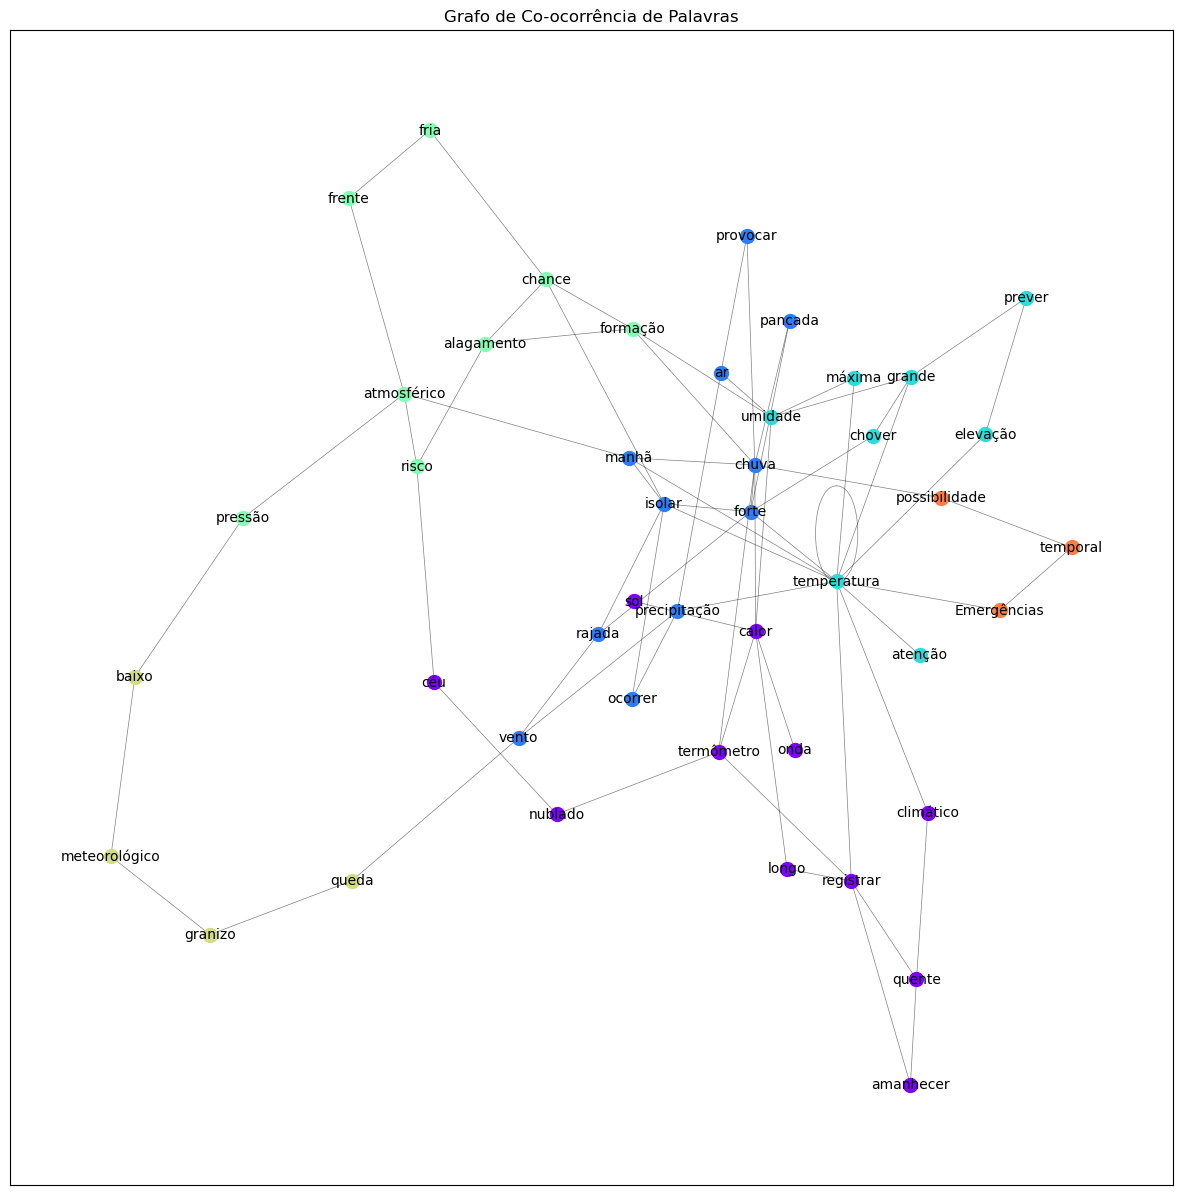


Estatísticas do Grafo:
Número de Nós: 45
Número de Arestas: 71

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 13
Nó: chuva, Grau: 8
Nó: calor, Grau: 6
Nó: forte, Grau: 6
Nó: isolar, Grau: 6
Nó: registrar, Grau: 5
Nó: umidade, Grau: 5
Nó: termômetro, Grau: 4
Nó: formação, Grau: 4
Nó: precipitação, Grau: 4
Nó: grande, Grau: 4
Nó: atmosférico, Grau: 4
Nó: chance, Grau: 4
Nó: manhã, Grau: 4
Nó: quente, Grau: 3
Nó: ar, Grau: 3
Nó: rajada, Grau: 3
Nó: vento, Grau: 3
Nó: alagamento, Grau: 3
Nó: risco, Grau: 3
Nó: amanhecer, Grau: 2
Nó: climático, Grau: 2
Nó: longo, Grau: 2
Nó: provocar, Grau: 2
Nó: possibilidade, Grau: 2
Nó: temporal, Grau: 2
Nó: Emergências, Grau: 2
Nó: pancada, Grau: 2
Nó: chover, Grau: 2
Nó: queda, Grau: 2
Nó: granizo, Grau: 2
Nó: meteorológico, Grau: 2
Nó: baixo, Grau: 2
Nó: pressão, Grau: 2
Nó: frente, Grau: 2
Nó: fria, Grau: 2
Nó: elevação, Grau: 2
Nó: prever, Grau: 2
Nó: ocorrer, Grau: 2
Nó: céu, Grau: 2
Nó: nublado, Grau: 2
Nó: máxima, Grau: 2
Nó: sol, 

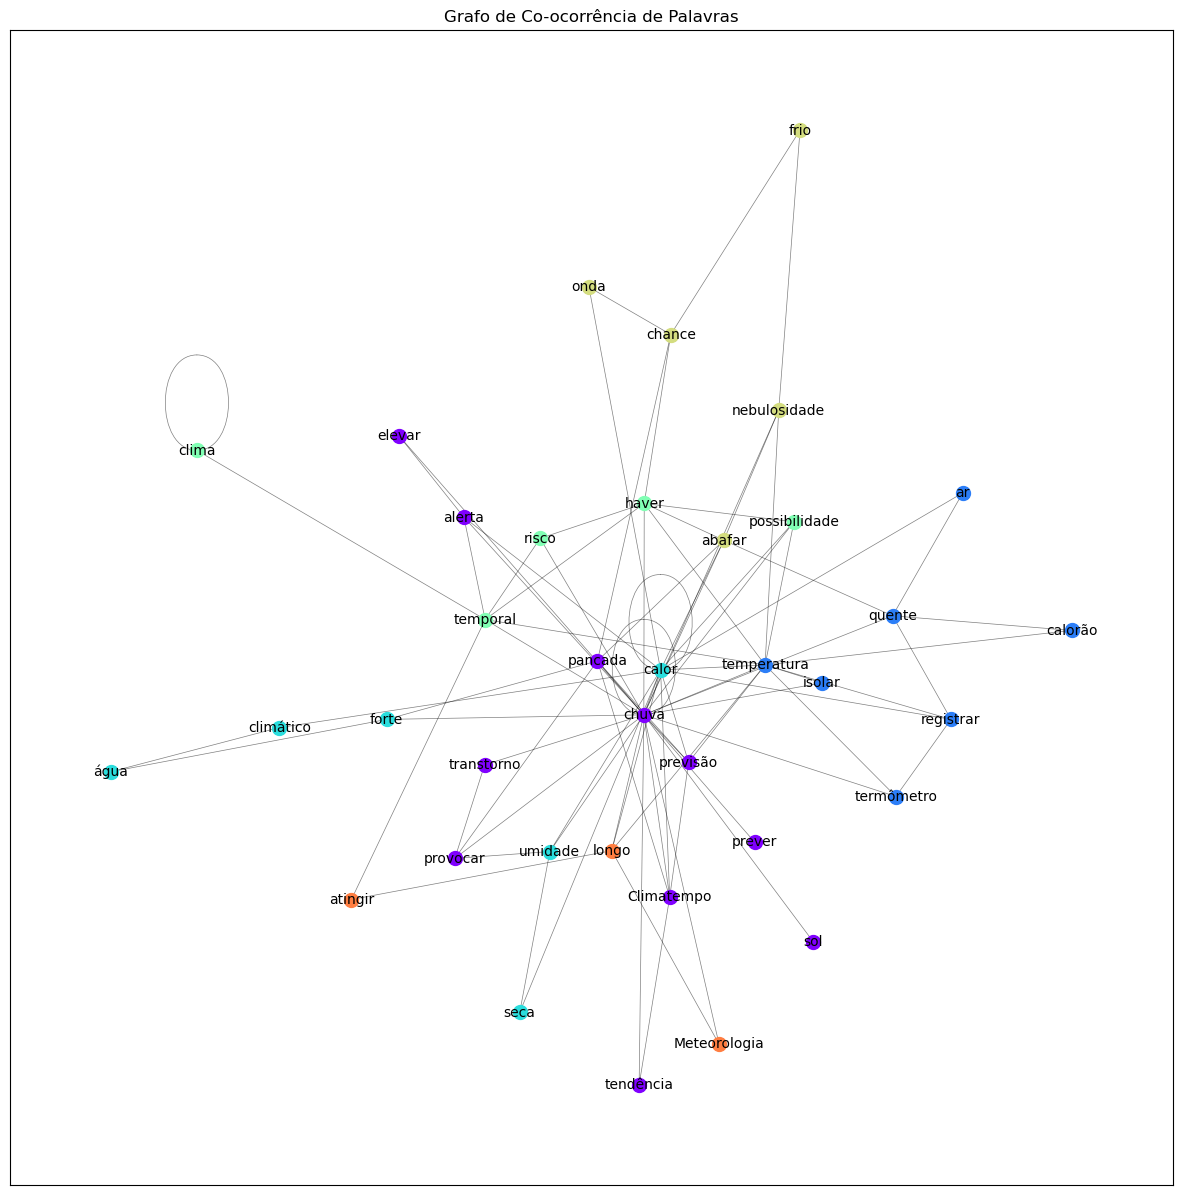


Estatísticas do Grafo:
Número de Nós: 37
Número de Arestas: 85

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 27
Nó: calor, Grau: 16
Nó: temperatura, Grau: 12
Nó: pancada, Grau: 7
Nó: temporal, Grau: 7
Nó: haver, Grau: 7
Nó: abafar, Grau: 6
Nó: previsão, Grau: 5
Nó: longo, Grau: 5
Nó: Climatempo, Grau: 5
Nó: quente, Grau: 5
Nó: provocar, Grau: 4
Nó: nebulosidade, Grau: 4
Nó: alerta, Grau: 4
Nó: chance, Grau: 4
Nó: possibilidade, Grau: 4
Nó: registrar, Grau: 4
Nó: umidade, Grau: 4
Nó: forte, Grau: 3
Nó: risco, Grau: 3
Nó: termômetro, Grau: 3
Nó: clima, Grau: 3
Nó: água, Grau: 2
Nó: climático, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: tendência, Grau: 2
Nó: transtorno, Grau: 2
Nó: isolar, Grau: 2
Nó: atingir, Grau: 2
Nó: elevar, Grau: 2
Nó: calorão, Grau: 2
Nó: seca, Grau: 2
Nó: frio, Grau: 2
Nó: onda, Grau: 2
Nó: ar, Grau: 2
Nó: prever, Grau: 1
Nó: sol, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, pancada), Peso: 7
Aresta: (calor, temperatura), Peso: 6
Aresta: 

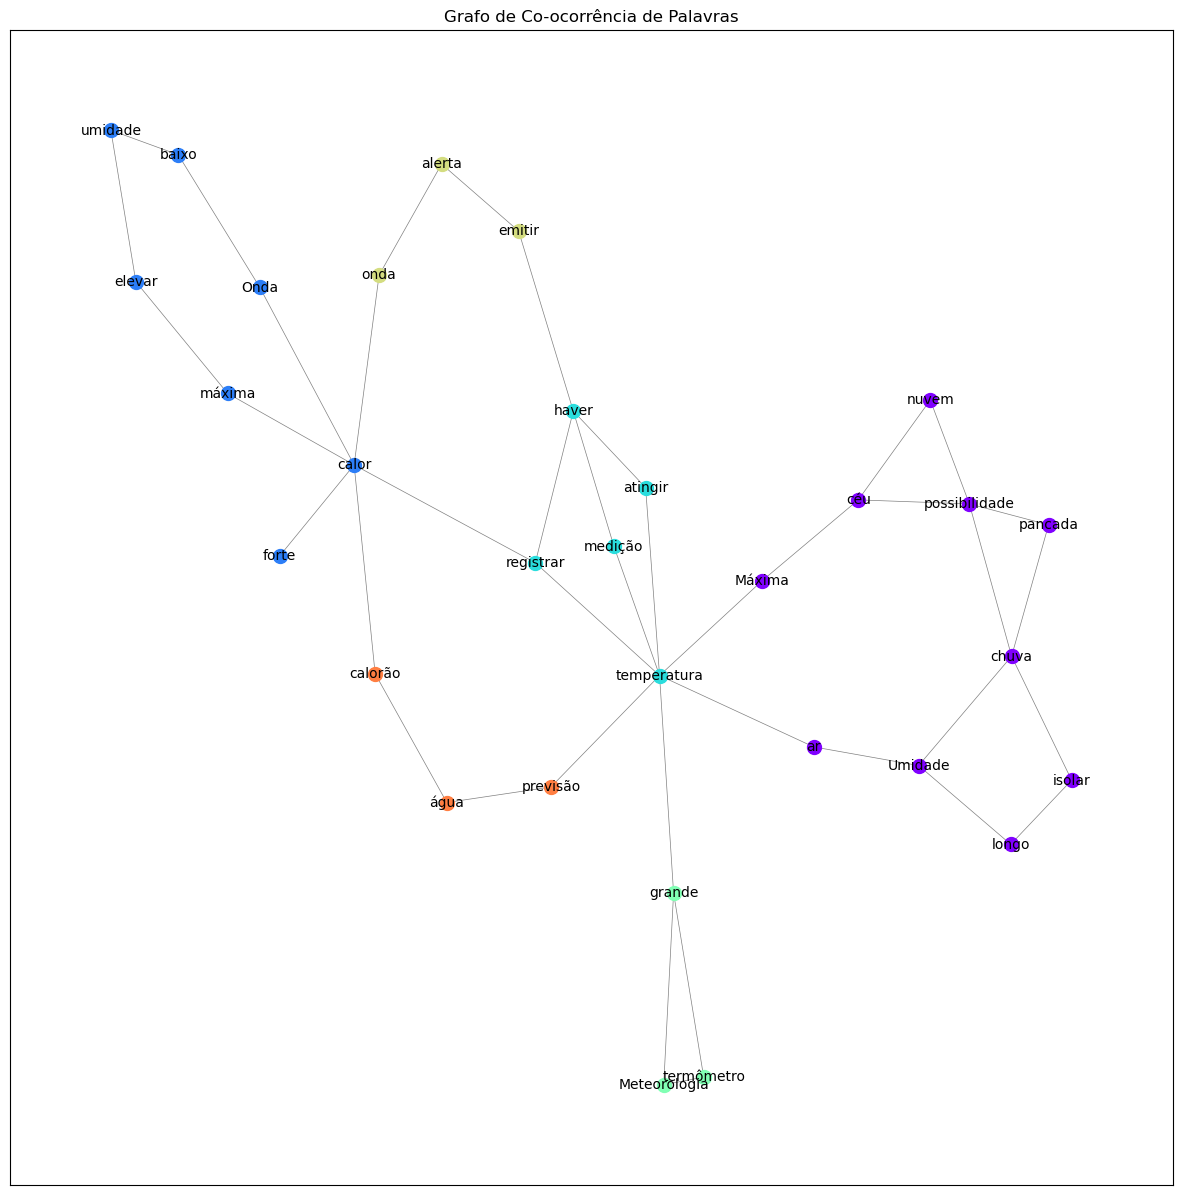


Estatísticas do Grafo:
Número de Nós: 31
Número de Arestas: 40

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 7
Nó: calor, Grau: 6
Nó: haver, Grau: 4
Nó: possibilidade, Grau: 4
Nó: chuva, Grau: 4
Nó: registrar, Grau: 3
Nó: grande, Grau: 3
Nó: céu, Grau: 3
Nó: Umidade, Grau: 3
Nó: Meteorologia, Grau: 2
Nó: termômetro, Grau: 2
Nó: medição, Grau: 2
Nó: atingir, Grau: 2
Nó: emitir, Grau: 2
Nó: alerta, Grau: 2
Nó: onda, Grau: 2
Nó: máxima, Grau: 2
Nó: elevar, Grau: 2
Nó: umidade, Grau: 2
Nó: baixo, Grau: 2
Nó: Onda, Grau: 2
Nó: calorão, Grau: 2
Nó: água, Grau: 2
Nó: previsão, Grau: 2
Nó: Máxima, Grau: 2
Nó: isolar, Grau: 2
Nó: longo, Grau: 2
Nó: ar, Grau: 2
Nó: nuvem, Grau: 2
Nó: pancada, Grau: 2
Nó: forte, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (registrar, temperatura), Peso: 2
Aresta: (temperatura, grande), Peso: 2
Aresta: (temperatura, Máxima), Peso: 2
Aresta: (Máxima, céu), Peso: 2
Aresta: (Umidade, ar), Peso: 2
Aresta: (forte, calor), Peso: 1
Aresta: (

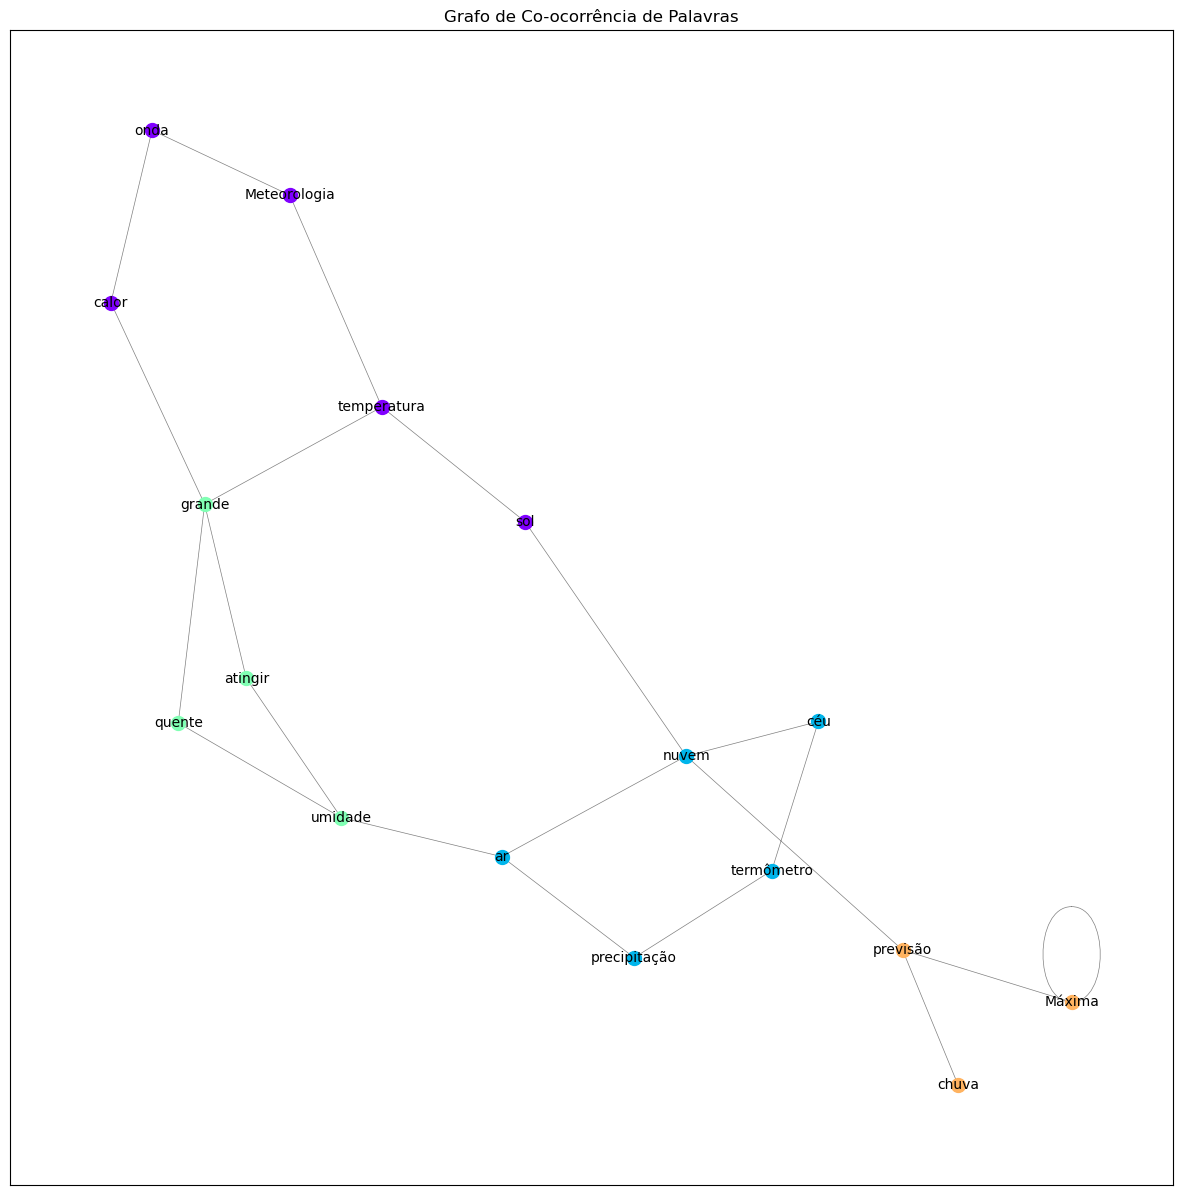


Estatísticas do Grafo:
Número de Nós: 17
Número de Arestas: 21

Grau dos Nós (em ordem decrescente):
Nó: grande, Grau: 4
Nó: nuvem, Grau: 4
Nó: temperatura, Grau: 3
Nó: umidade, Grau: 3
Nó: ar, Grau: 3
Nó: previsão, Grau: 3
Nó: Máxima, Grau: 3
Nó: sol, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: onda, Grau: 2
Nó: calor, Grau: 2
Nó: atingir, Grau: 2
Nó: precipitação, Grau: 2
Nó: termômetro, Grau: 2
Nó: céu, Grau: 2
Nó: quente, Grau: 2
Nó: chuva, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (sol, temperatura), Peso: 2
Aresta: (umidade, ar), Peso: 2
Aresta: (previsão, chuva), Peso: 2
Aresta: (sol, nuvem), Peso: 1
Aresta: (temperatura, Meteorologia), Peso: 1
Aresta: (temperatura, grande), Peso: 1
Aresta: (Meteorologia, onda), Peso: 1
Aresta: (onda, calor), Peso: 1
Aresta: (calor, grande), Peso: 1
Aresta: (grande, atingir), Peso: 1
Aresta: (grande, quente), Peso: 1
Aresta: (atingir, umidade), Peso: 1
Aresta: (umidade, quente), Peso: 1
Aresta: (ar, precipitação), Peso: 1
Aresta: (ar,

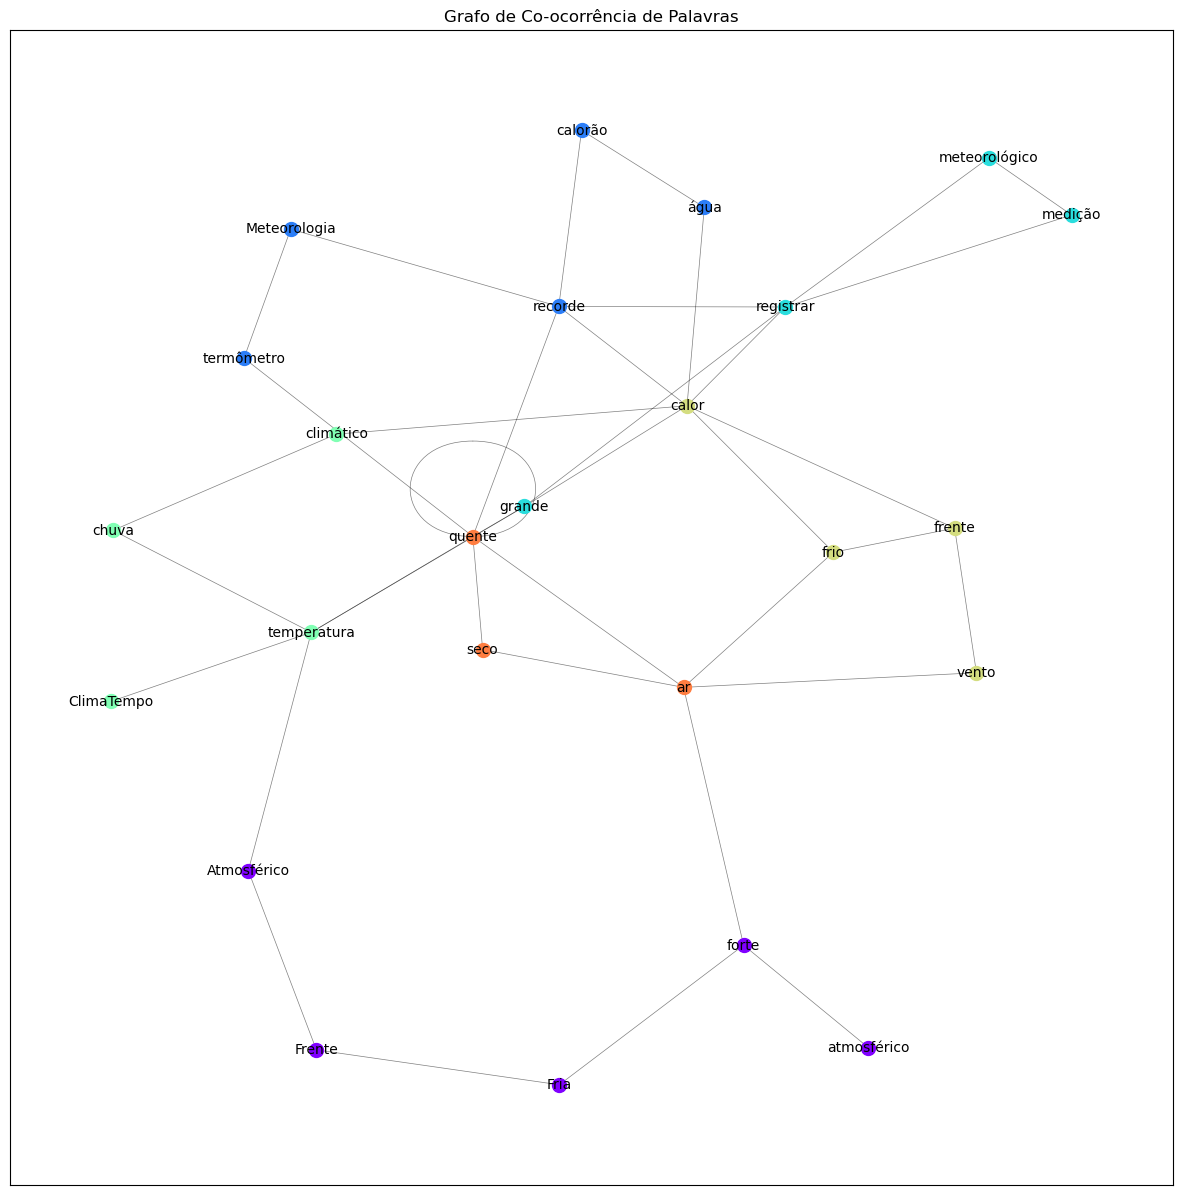


Estatísticas do Grafo:
Número de Nós: 25
Número de Arestas: 38

Grau dos Nós (em ordem decrescente):
Nó: quente, Grau: 8
Nó: calor, Grau: 7
Nó: registrar, Grau: 5
Nó: recorde, Grau: 5
Nó: temperatura, Grau: 5
Nó: ar, Grau: 5
Nó: grande, Grau: 4
Nó: forte, Grau: 3
Nó: frio, Grau: 3
Nó: frente, Grau: 3
Nó: termômetro, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: medição, Grau: 2
Nó: meteorológico, Grau: 2
Nó: Atmosférico, Grau: 2
Nó: Frente, Grau: 2
Nó: Fria, Grau: 2
Nó: seco, Grau: 2
Nó: vento, Grau: 2
Nó: chuva, Grau: 2
Nó: climático, Grau: 2
Nó: água, Grau: 2
Nó: calorão, Grau: 2
Nó: ClimaTempo, Grau: 1
Nó: atmosférico, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (grande, temperatura), Peso: 3
Aresta: (registrar, recorde), Peso: 2
Aresta: (quente, ar), Peso: 2
Aresta: (temperatura, ClimaTempo), Peso: 2
Aresta: (forte, atmosférico), Peso: 2
Aresta: (frio, frente), Peso: 2
Aresta: (calor, registrar), Peso: 1
Aresta: (calor, recorde), Peso: 1
Aresta: (calor, grande), Peso: 1
Ares

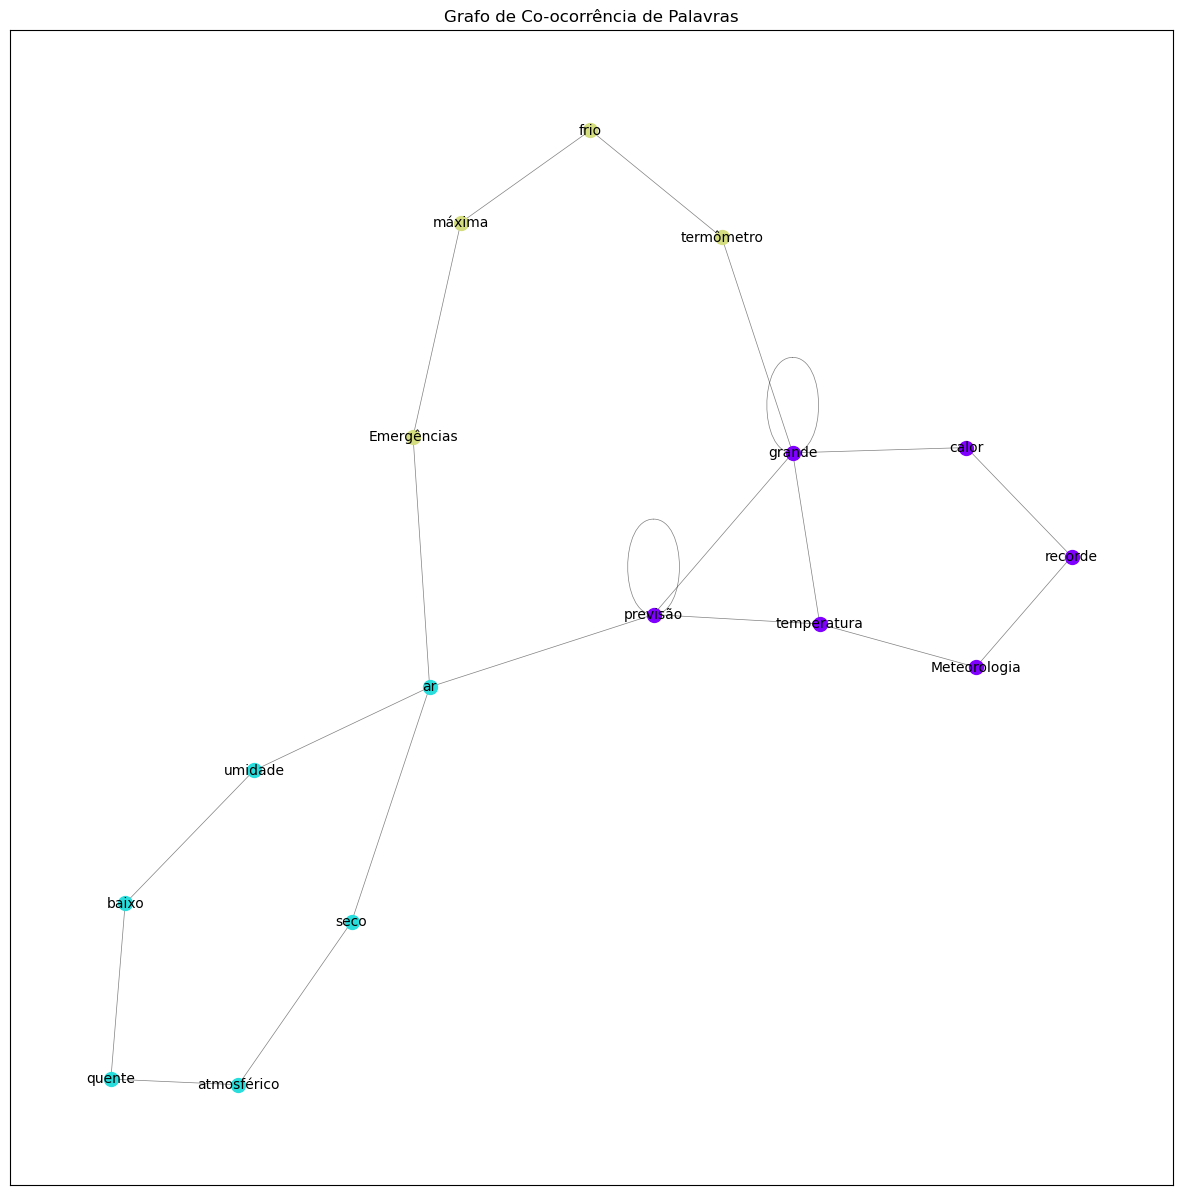


Estatísticas do Grafo:
Número de Nós: 16
Número de Arestas: 21

Grau dos Nós (em ordem decrescente):
Nó: grande, Grau: 6
Nó: previsão, Grau: 5
Nó: ar, Grau: 4
Nó: temperatura, Grau: 3
Nó: Meteorologia, Grau: 2
Nó: recorde, Grau: 2
Nó: calor, Grau: 2
Nó: termômetro, Grau: 2
Nó: frio, Grau: 2
Nó: máxima, Grau: 2
Nó: Emergências, Grau: 2
Nó: seco, Grau: 2
Nó: atmosférico, Grau: 2
Nó: quente, Grau: 2
Nó: baixo, Grau: 2
Nó: umidade, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (temperatura, Meteorologia), Peso: 1
Aresta: (temperatura, grande), Peso: 1
Aresta: (temperatura, previsão), Peso: 1
Aresta: (Meteorologia, recorde), Peso: 1
Aresta: (recorde, calor), Peso: 1
Aresta: (calor, grande), Peso: 1
Aresta: (grande, termômetro), Peso: 1
Aresta: (grande, previsão), Peso: 1
Aresta: (grande, grande), Peso: 1
Aresta: (termômetro, frio), Peso: 1
Aresta: (frio, máxima), Peso: 1
Aresta: (máxima, Emergências), Peso: 1
Aresta: (Emergências, ar), Peso: 1
Aresta: (ar, seco), Peso: 1
Aresta

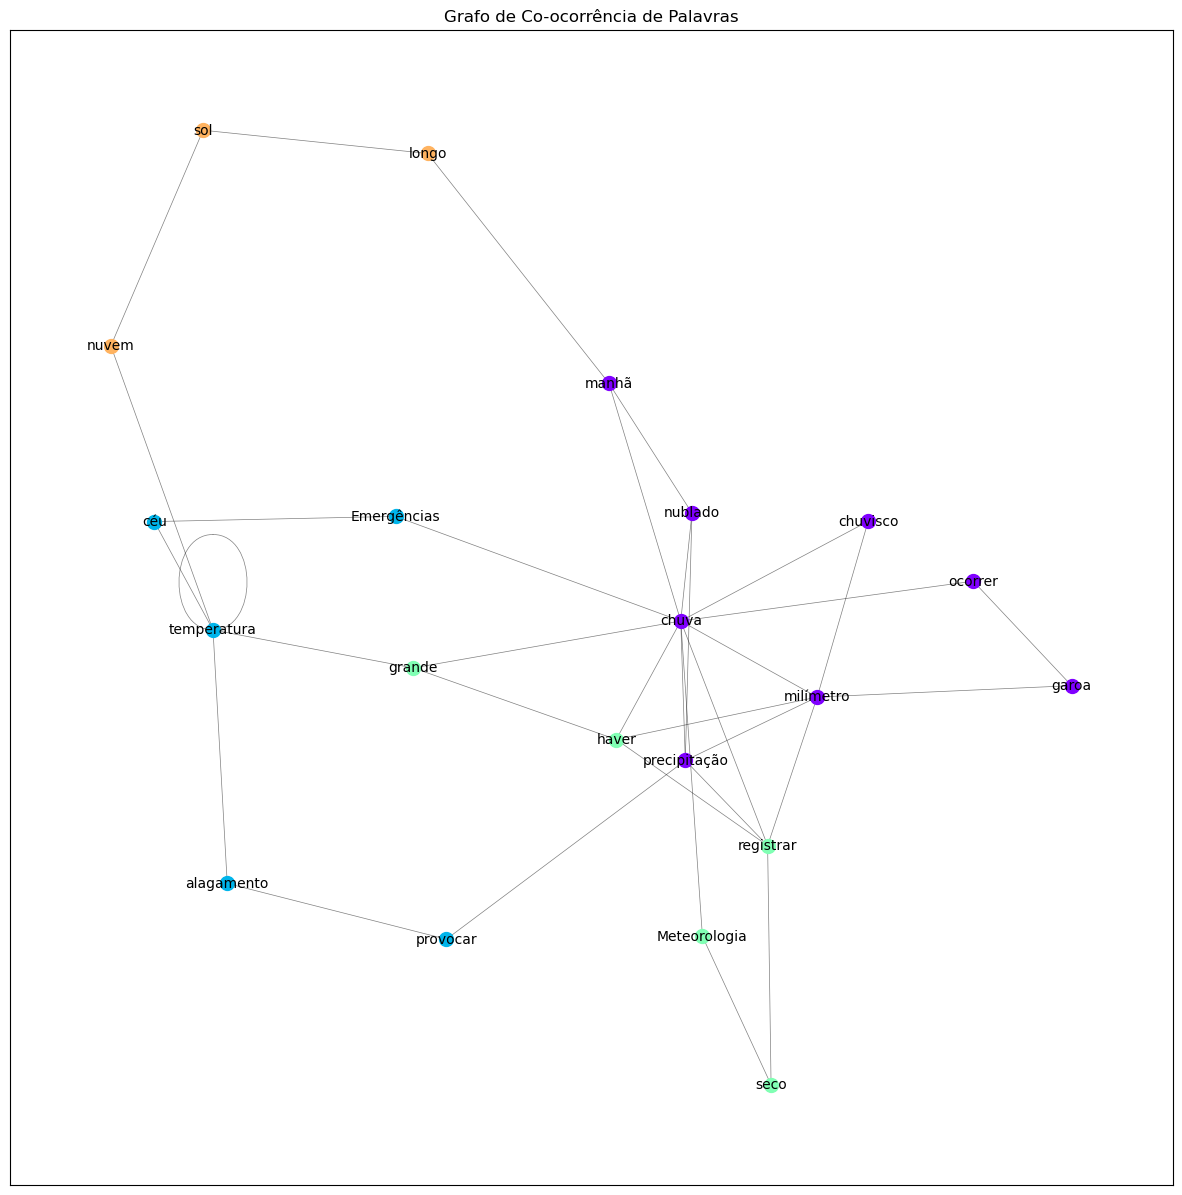


Estatísticas do Grafo:
Número de Nós: 21
Número de Arestas: 35

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 11
Nó: temperatura, Grau: 6
Nó: milímetro, Grau: 6
Nó: registrar, Grau: 5
Nó: precipitação, Grau: 5
Nó: haver, Grau: 4
Nó: manhã, Grau: 3
Nó: nublado, Grau: 3
Nó: grande, Grau: 3
Nó: Emergências, Grau: 2
Nó: céu, Grau: 2
Nó: garoa, Grau: 2
Nó: ocorrer, Grau: 2
Nó: chuvisco, Grau: 2
Nó: Meteorologia, Grau: 2
Nó: seco, Grau: 2
Nó: provocar, Grau: 2
Nó: alagamento, Grau: 2
Nó: longo, Grau: 2
Nó: sol, Grau: 2
Nó: nuvem, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, manhã), Peso: 2
Aresta: (chuva, nublado), Peso: 2
Aresta: (chuva, milímetro), Peso: 2
Aresta: (temperatura, grande), Peso: 2
Aresta: (precipitação, milímetro), Peso: 2
Aresta: (registrar, chuva), Peso: 1
Aresta: (registrar, precipitação), Peso: 1
Aresta: (registrar, milímetro), Peso: 1
Aresta: (registrar, seco), Peso: 1
Aresta: (registrar, haver), Peso: 1
Aresta: (chuva, Emergências), Peso: 1

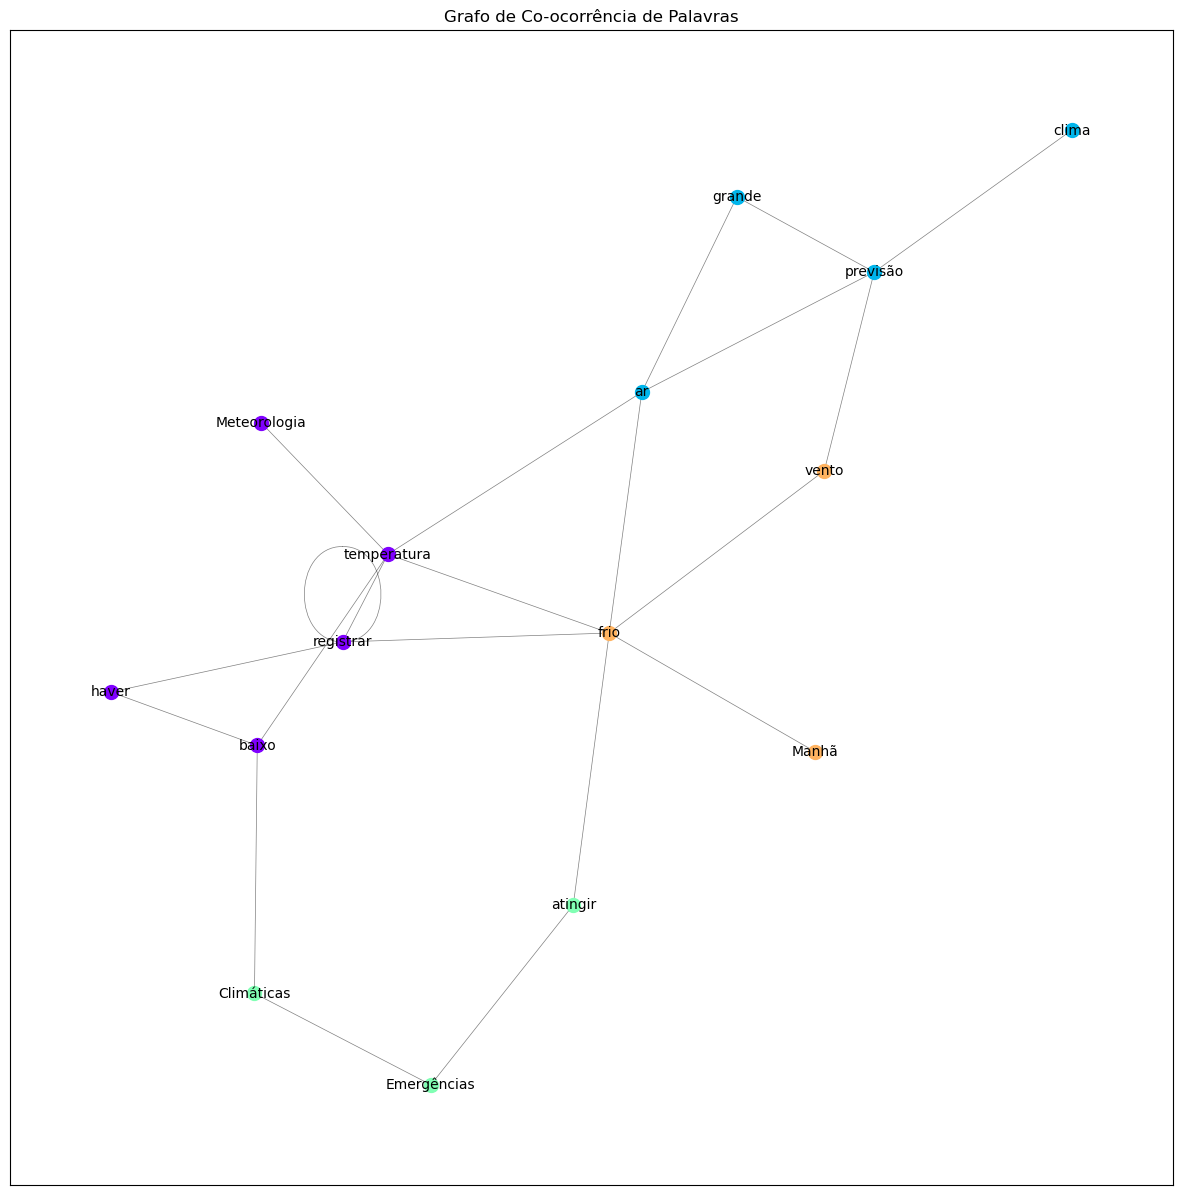


Estatísticas do Grafo:
Número de Nós: 15
Número de Arestas: 21

Grau dos Nós (em ordem decrescente):
Nó: frio, Grau: 6
Nó: registrar, Grau: 5
Nó: temperatura, Grau: 5
Nó: ar, Grau: 4
Nó: previsão, Grau: 4
Nó: baixo, Grau: 3
Nó: haver, Grau: 2
Nó: atingir, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: vento, Grau: 2
Nó: grande, Grau: 2
Nó: Manhã, Grau: 1
Nó: Meteorologia, Grau: 1
Nó: clima, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (registrar, temperatura), Peso: 2
Aresta: (temperatura, Meteorologia), Peso: 2
Aresta: (temperatura, baixo), Peso: 2
Aresta: (Manhã, frio), Peso: 1
Aresta: (frio, registrar), Peso: 1
Aresta: (frio, temperatura), Peso: 1
Aresta: (frio, atingir), Peso: 1
Aresta: (frio, ar), Peso: 1
Aresta: (frio, vento), Peso: 1
Aresta: (registrar, haver), Peso: 1
Aresta: (registrar, registrar), Peso: 1
Aresta: (temperatura, ar), Peso: 1
Aresta: (baixo, haver), Peso: 1
Aresta: (baixo, Climáticas), Peso: 1
Aresta: (atingir, Emergências), Peso: 1
A

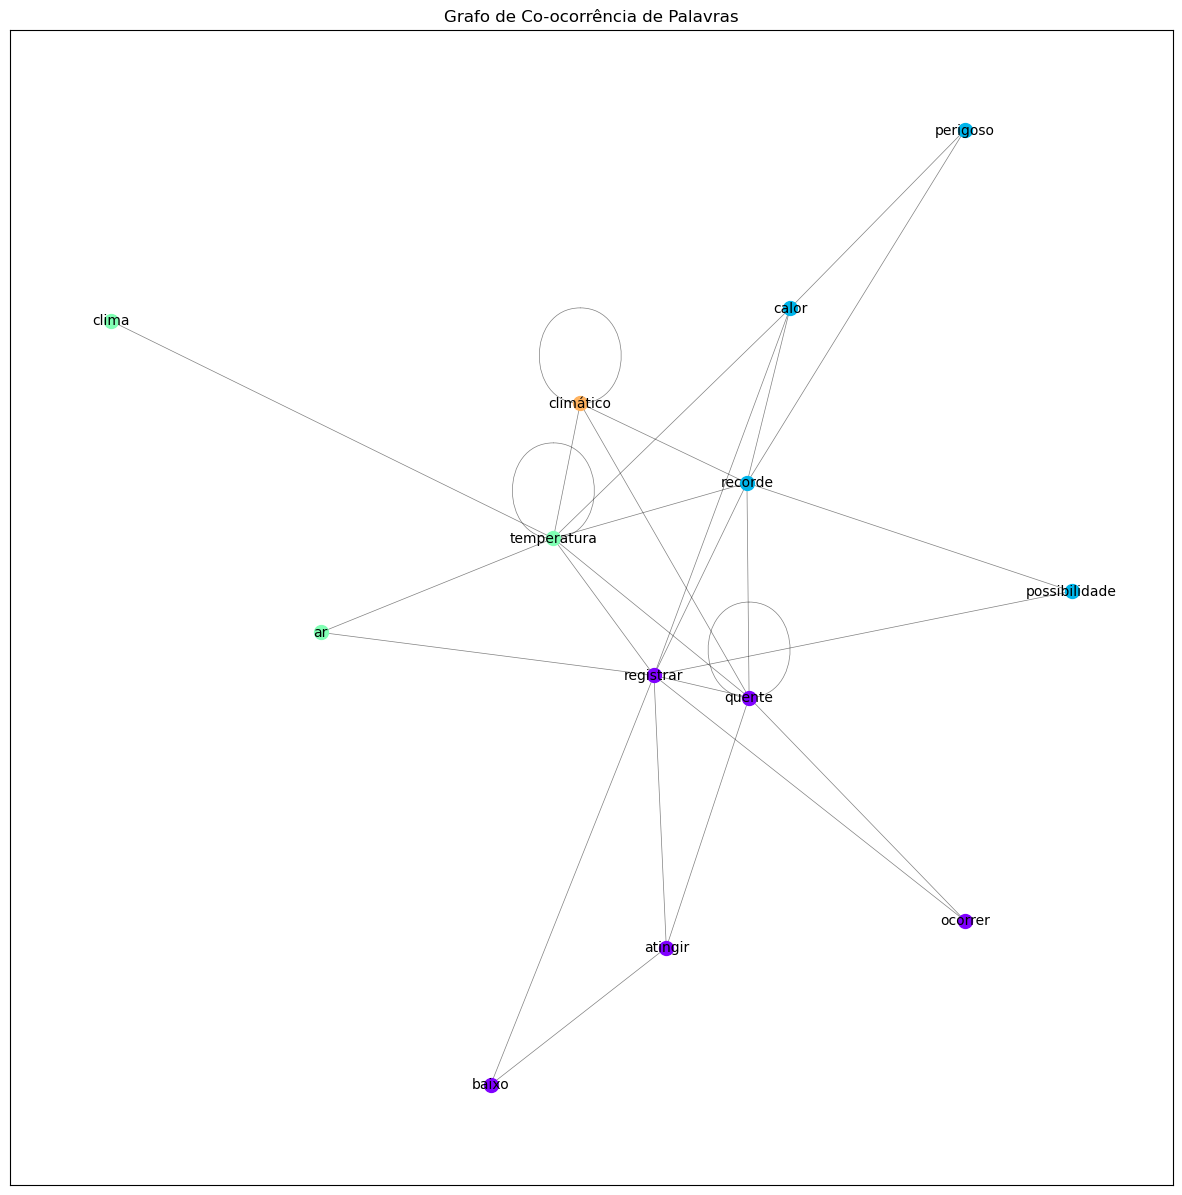


Estatísticas do Grafo:
Número de Nós: 13
Número de Arestas: 28

Grau dos Nós (em ordem decrescente):
Nó: temperatura, Grau: 9
Nó: registrar, Grau: 9
Nó: quente, Grau: 8
Nó: recorde, Grau: 7
Nó: climático, Grau: 5
Nó: calor, Grau: 4
Nó: atingir, Grau: 3
Nó: ar, Grau: 2
Nó: baixo, Grau: 2
Nó: possibilidade, Grau: 2
Nó: perigoso, Grau: 2
Nó: ocorrer, Grau: 2
Nó: clima, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (temperatura, registrar), Peso: 6
Aresta: (temperatura, temperatura), Peso: 5
Aresta: (temperatura, recorde), Peso: 5
Aresta: (temperatura, climático), Peso: 4
Aresta: (temperatura, ar), Peso: 3
Aresta: (temperatura, quente), Peso: 3
Aresta: (registrar, quente), Peso: 3
Aresta: (registrar, recorde), Peso: 3
Aresta: (climático, recorde), Peso: 3
Aresta: (quente, recorde), Peso: 2
Aresta: (quente, atingir), Peso: 2
Aresta: (temperatura, calor), Peso: 1
Aresta: (temperatura, clima), Peso: 1
Aresta: (ar, registrar), Peso: 1
Aresta: (registrar, calor), Peso: 1
Aresta: (r

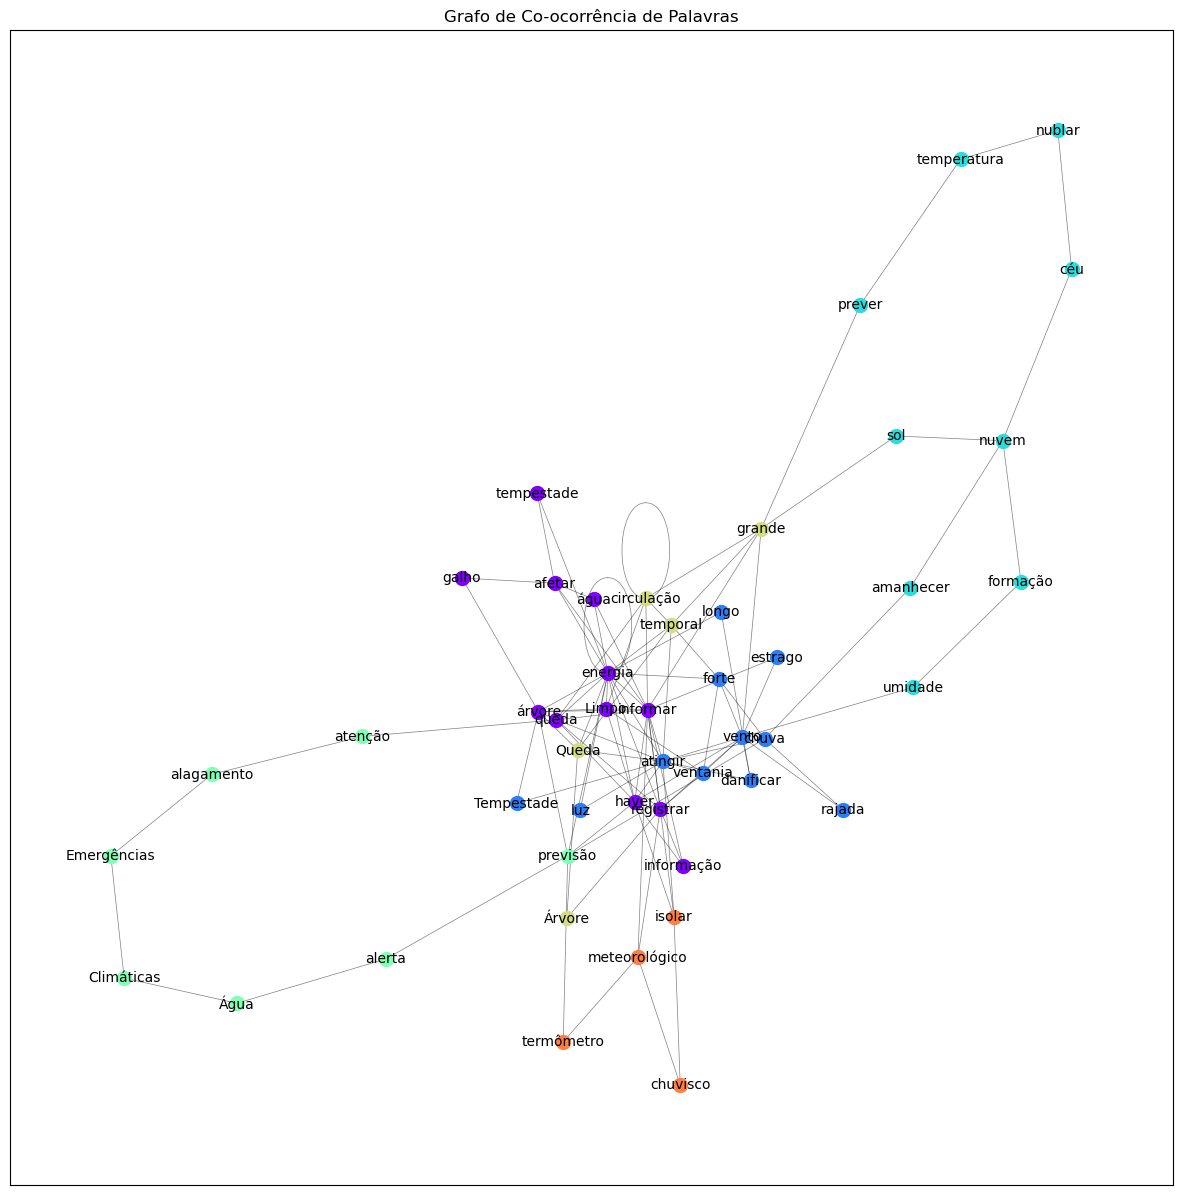


Estatísticas do Grafo:
Número de Nós: 48
Número de Arestas: 106

Grau dos Nós (em ordem decrescente):
Nó: energia, Grau: 18
Nó: informar, Grau: 14
Nó: atingir, Grau: 13
Nó: vento, Grau: 10
Nó: haver, Grau: 9
Nó: queda, Grau: 8
Nó: árvore, Grau: 8
Nó: registrar, Grau: 8
Nó: circulação, Grau: 7
Nó: temporal, Grau: 6
Nó: previsão, Grau: 6
Nó: grande, Grau: 6
Nó: ventania, Grau: 5
Nó: forte, Grau: 5
Nó: Limpo, Grau: 5
Nó: chuva, Grau: 5
Nó: afetar, Grau: 5
Nó: Queda, Grau: 5
Nó: isolar, Grau: 4
Nó: meteorológico, Grau: 4
Nó: nuvem, Grau: 4
Nó: danificar, Grau: 3
Nó: água, Grau: 3
Nó: informação, Grau: 3
Nó: atenção, Grau: 2
Nó: alagamento, Grau: 2
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: Água, Grau: 2
Nó: alerta, Grau: 2
Nó: luz, Grau: 2
Nó: longo, Grau: 2
Nó: rajada, Grau: 2
Nó: tempestade, Grau: 2
Nó: galho, Grau: 2
Nó: estrago, Grau: 2
Nó: termômetro, Grau: 2
Nó: chuvisco, Grau: 2
Nó: amanhecer, Grau: 2
Nó: sol, Grau: 2
Nó: umidade, Grau: 2
Nó: formação, Grau: 2
Nó: céu, Gr

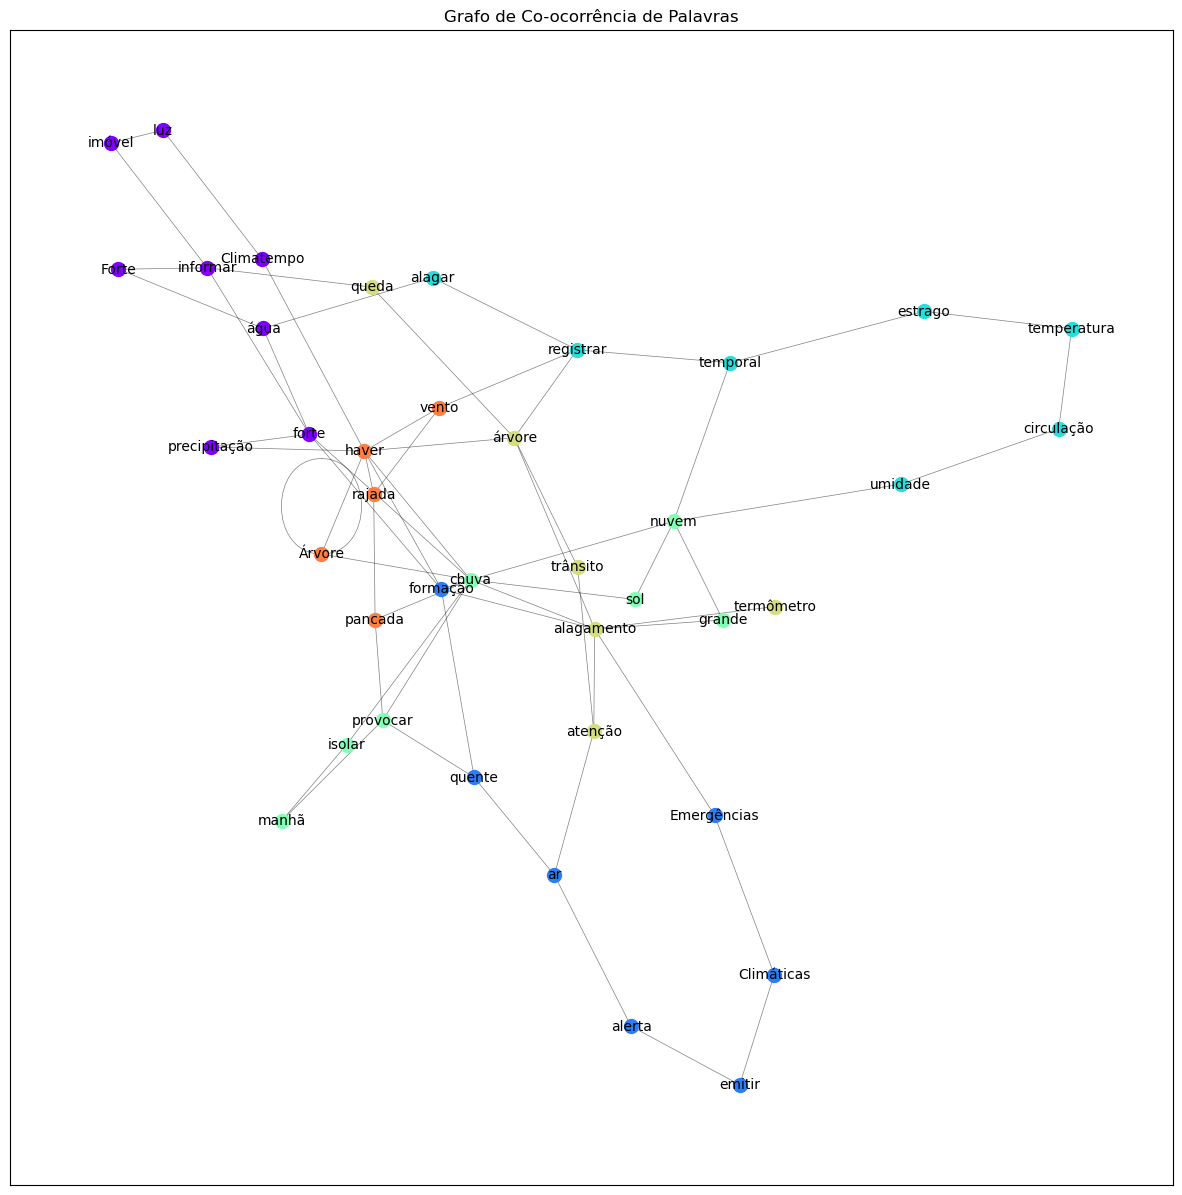


Estatísticas do Grafo:
Número de Nós: 40
Número de Arestas: 63

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 10
Nó: haver, Grau: 8
Nó: alagamento, Grau: 7
Nó: forte, Grau: 5
Nó: nuvem, Grau: 5
Nó: árvore, Grau: 5
Nó: formação, Grau: 5
Nó: provocar, Grau: 4
Nó: informar, Grau: 4
Nó: registrar, Grau: 4
Nó: Árvore, Grau: 4
Nó: atenção, Grau: 3
Nó: ar, Grau: 3
Nó: quente, Grau: 3
Nó: pancada, Grau: 3
Nó: rajada, Grau: 3
Nó: vento, Grau: 3
Nó: temporal, Grau: 3
Nó: água, Grau: 3
Nó: Emergências, Grau: 2
Nó: Climáticas, Grau: 2
Nó: emitir, Grau: 2
Nó: alerta, Grau: 2
Nó: imóvel, Grau: 2
Nó: luz, Grau: 2
Nó: Climatempo, Grau: 2
Nó: estrago, Grau: 2
Nó: temperatura, Grau: 2
Nó: circulação, Grau: 2
Nó: umidade, Grau: 2
Nó: alagar, Grau: 2
Nó: Forte, Grau: 2
Nó: queda, Grau: 2
Nó: trânsito, Grau: 2
Nó: sol, Grau: 2
Nó: isolar, Grau: 2
Nó: manhã, Grau: 2
Nó: grande, Grau: 2
Nó: precipitação, Grau: 2
Nó: termômetro, Grau: 1

Peso das Arestas (em ordem decrescente):
Aresta: (imóvel, luz),

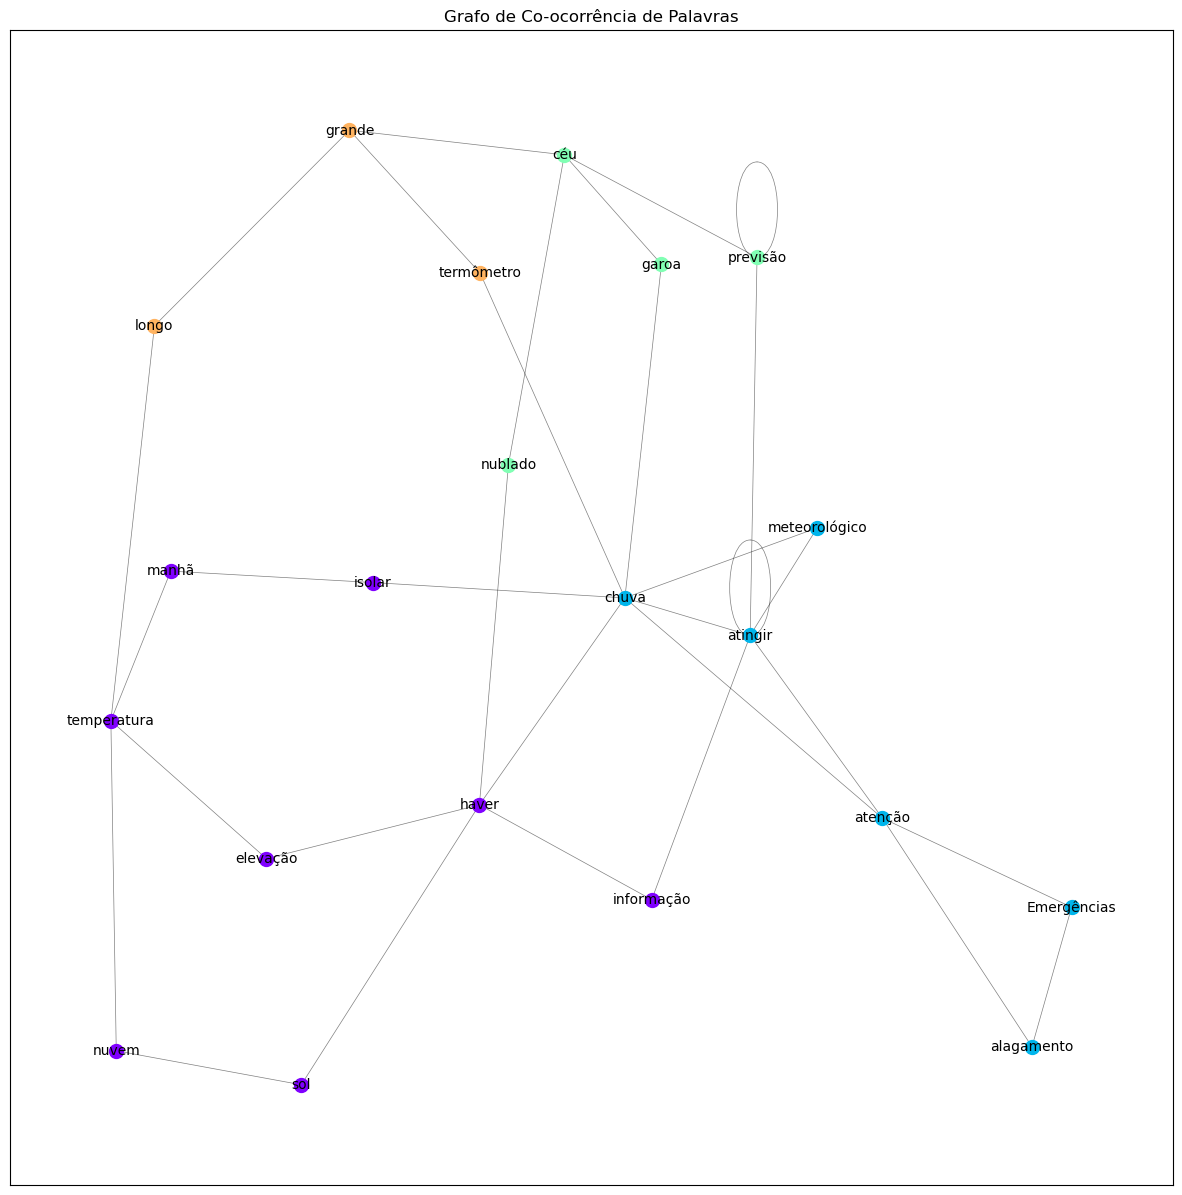


Estatísticas do Grafo:
Número de Nós: 21
Número de Arestas: 32

Grau dos Nós (em ordem decrescente):
Nó: chuva, Grau: 7
Nó: atingir, Grau: 7
Nó: haver, Grau: 5
Nó: atenção, Grau: 4
Nó: previsão, Grau: 4
Nó: céu, Grau: 4
Nó: temperatura, Grau: 4
Nó: grande, Grau: 3
Nó: alagamento, Grau: 2
Nó: Emergências, Grau: 2
Nó: meteorológico, Grau: 2
Nó: informação, Grau: 2
Nó: garoa, Grau: 2
Nó: isolar, Grau: 2
Nó: manhã, Grau: 2
Nó: longo, Grau: 2
Nó: nublado, Grau: 2
Nó: sol, Grau: 2
Nó: nuvem, Grau: 2
Nó: elevação, Grau: 2
Nó: termômetro, Grau: 2

Peso das Arestas (em ordem decrescente):
Aresta: (chuva, atingir), Peso: 2
Aresta: (chuva, haver), Peso: 2
Aresta: (chuva, atenção), Peso: 1
Aresta: (chuva, meteorológico), Peso: 1
Aresta: (chuva, garoa), Peso: 1
Aresta: (chuva, isolar), Peso: 1
Aresta: (chuva, termômetro), Peso: 1
Aresta: (atenção, alagamento), Peso: 1
Aresta: (atenção, Emergências), Peso: 1
Aresta: (atenção, atingir), Peso: 1
Aresta: (alagamento, Emergências), Peso: 1
Aresta: (ati

In [ ]:
for url in urls_G1_2024:
    print(f"\nAnalisando link em 2024: {url}")
    texto = coletar_texto(url)
    G = construir_grafo(texto)
    plotar_grafo(G)
    estatisticas_grafo(G)
    print()
    detectar_comunidades(G)

# **Análises dos grafos do ano de 2024**

**Análise do Grafo do Mês 01 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/01/18/cidade-de-sp-ja-tem-o-inicio-de-janeiro-mais-quente-dos-ultimos-cinco-anos-diz-inmet-previsao-e-de-chuva-forte-no-fim-da-semana.ghtml)**

Número de Nós: 45, Número de Arestas: 71

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (13), seguida por "chuva" (8), "calor" (6) e "forte" (6), indicando um clima caracterizado por forte calor e altas temperaturas, que eventualmente será seguido por chuvas intensas. As arestas com maior peso, como (umidade, ar) com peso 3 e (chuva, forte) com peso 3, reforçam a previsão de chuvas intensas à medida que a umidade aumenta.

A centralidade de intermediação do nó "temperatura" é de 37,02%, destacando-o como o principal ponto de conexão entre os demais nós. Os nós "chuva" (22%) e "manhã" (18,08%) também exercem papel central, sugerindo que o foco da notícia recai sobre uma onda de calor, mas com chuvas já previstas para ocorrer.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: O valor de 9,48% sugere baixa conectividade entre os termos, indicando que os subtemas são relativamente independentes entre si.

Modularidade das Comunidades: A modularidade de 49,47% reflete uma estrutura de comunidades bem definida, permitindo a identificação de seis comunidades principais:

- Comunidade 1: "onda", "calor", "céu", "sol", "climático", "registrar", "termômetro", "nublado", "longo", "amanhecer", "quente". Esta comunidade se relaciona a uma onda de calor e ao registro de altas temperaturas, com um céu variando entre sol e nublado.

- Comunidade 2: "vento", "isolar", "chuva", "ocorrer", "pancada", "manhã", "precipitação", "ar", "forte", "provocar", "rajada". Associada a rajadas de vento e pancadas de chuva que acontecem pela manhã, sugerindo intensificação dos eventos climáticos.

- Comunidade 3: "elevação", "grande", "umidade", "chover", "temperatura", "atenção", "máxima", "prever". Relacionada à previsão de aumento de umidade e temperaturas, reforçando alertas de chuvas intensas.

- Comunidade 4: "formação", "risco", "pressão", "chance", "frente", "fria", "atmosférico", "alagamento". Ligada a formações de pressão e frentes frias, alertando para a possibilidade de alagamentos.

- Comunidade 5: "baixo", "queda", "granizo", "meteorológico". Refere-se a previsões meteorológicas de queda de granizo e temperaturas baixas.

- Comunidade 6: "possibilidade", "temporal", "Emergências". Esta comunidade trata da possibilidade de temporais e a preparação para emergências.

Este primeiro grafo do mês de janeiro de 2024 reflete uma previsão climática para um período de calor intenso, seguido de chuvas fortes e variações atmosféricas. A centralidade de "temperatura" e a presença de comunidades associadas a "calor", "chuva" e "emergências" ressaltam a preocupação com condições climáticas extremas, incluindo a chance de alagamentos e tempestades.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 02 de 2024 (https://g1.globo.com/carnaval/2024/noticia/2024/02/01/calor-acima-da-media-e-carnaval-com-chuva-veja-a-previsao-para-o-mes-de-fevereiro.ghtml)**

Número de Nós: 37, Número de Arestas: 85

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (27), seguida por "calor" (16), "temperatura" (12) e "pancada" (7), indicando que este segundo mês apresenta condições de calor intenso, com temperaturas altas acompanhadas por chuvas e tempestades. Esse padrão é reforçado pelo peso elevado de algumas arestas, como (chuva, pancada) com peso 7 e (calor, temperatura) com peso 6, sugerindo chuvas fortes associadas a um clima quente.

A centralidade de intermediação do nó "chuva" é de 54,82%, destacando-o como o principal centro de conexão entre outros nós no grafo. Os nós "calor" com 21,43% e "temperatura" com 10,70% também atuam como pontos de interligação, reforçando a ideia de um clima caracterizado por calor e precipitação intensa.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 39,46%, o grafo apresenta conectividade moderada entre os termos, indicando uma certa coesão temática entre os subtemas abordados.

Modularidade das Comunidades: A modularidade de 25,85% sugere uma estrutura de comunidades menos definida, revelando a existência de temas interligados sem uma segmentação muito clara. Foram identificadas seis comunidades principais:

- Comunidade 1: "previsão", "chuva", "alerta", "sol", "tendência", "pancada", "prever", "Climatempo", "transtorno", "provocar", "elevar". Esta comunidade está focada em previsões climáticas e alertas de chuvas intensas, possivelmente vinculadas a transtornos causados pelas chuvas.

- Comunidade 2: "registrar", "ar", "termômetro", "isolar", "calorão", "temperatura", "quente". Ligada ao registro de temperaturas elevadas e ao calor intenso, sugere uma fase de calor extremo.

- Comunidade 3: "água", "umidade", "forte", "calor", "seca", "climático". Relacionada à combinação de calor e umidade, caracterizando um clima seco e quente com risco de escassez de água.

- Comunidade 4: "possibilidade", "clima", "risco", "haver", "temporal". Destaca a probabilidade de eventos climáticos extremos, como temporais.

- Comunidade 5: "onda", "abafar", "nebulosidade", "frio", "chance". Aborda variações de temperatura, desde ondas de calor até a possibilidade de dias nublados e abafados.

- Comunidade 6: "Meteorologia", "atingir", "longo". Refere-se a eventos meteorológicos de longo alcance, que podem afetar áreas extensas.

Este segundo grafo do mês de fevereiro de 2024 reflete um clima predominantemente quente, mas com chuvas intensas e tempestades frequentes. A centralidade do nó "chuva" e suas conexões com "calor" e "temperatura" sugerem um mês marcado por altas temperaturas, com previsões de chuvas fortes. A estrutura de comunidades reforça a relevância dos alertas climáticos e o monitoramento meteorológico devido à possibilidade de transtornos causados pelas condições climáticas intensas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 03 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/03/17/cidade-de-sp-registra-temperatura-maxima-de-34oc-pelo-quarto-dia-seguido.ghtml)**

Número de Nós: 31, Número de Arestas: 40

**Principais Nós e Centralidade**

A palavra "temperatura" apresenta o maior grau (7), seguida por "calor" (6), "possibilidade" (4) e "chuva" (4), o que indica um período de calor intenso com temperaturas elevadas e possibilidade de chuva. Esse cenário é reforçado pelo peso das arestas mais fortes, como (registrar, temperatura) com peso 2 e (temperatura, grande) também com peso 2.

A centralidade de intermediação do nó "temperatura" é de 64,29%, destacando-o como ponto central de conexão entre outros nós no grafo. "Calor" possui uma centralidade de 43,61% e "registrar" tem 39,19%, reforçando a ideia de que a notícia está centrada em um calor intenso e na temperatura elevada.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 16,67%, o grafo exibe uma conectividade relativamente baixa entre os termos, indicando que os subtemas abordados são, em geral, independentes.

Modularidade das Comunidades: A modularidade de 54,69% sugere uma estrutura bem definida, com a identificação de seis comunidades:

- Comunidade 1: "isolar", "chuva", "céu", "Umidade", "pancada", "possibilidade", "ar", "nuvem", "longo", "Máxima". Esta comunidade está relacionada à possibilidade de chuvas e condições de umidade elevadas, possivelmente refletindo um aumento na variação climática.

- Comunidade 2: "Onda", "forte", "umidade", "calor", "máxima", "elevar", "baixo". Focada em temperaturas altas, esta comunidade destaca a umidade e a presença de ondas de calor.

- Comunidade 3: "registrar", "atingir", "medição", "temperatura", "haver". Relacionada ao monitoramento da temperatura, indicando a intensidade dos registros de calor.

- Comunidade 4: "Meteorologia", "termômetro", "grande". Reflete a observação de temperaturas elevadas e o uso de medições precisas.

- Comunidade 5: "onda", "emitir", "alerta". Centrada em alertas de onda de calor, reforçando a intensidade do clima.

- Comunidade 6: "água", "previsão", "calorão". Envolve a previsão de calor e a importância da hidratação.

Este terceiro grafo reflete uma notícia de março de 2024, com foco em altas temperaturas e possibilidade de chuva. A centralidade de "temperatura" e suas conexões com "chuva" e "calor" indicam uma situação de calor persistente e clima variável. A estrutura definida das comunidades sugere uma segmentação clara dos tópicos climáticos abordados.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 04 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/04/29/cidade-de-sp-tera-semana-de-sol-e-altas-temperaturas-veja-a-previsao.ghtml)**

Número de Nós: 17, Número de Arestas: 21

**Principais Nós e Centralidade**

A palavra "grande" possui o maior grau (4), seguida por "nuvem" (4), "temperatura" (3) e "umidade" (3), indicando que essa notícia de abril de 2024 foca em uma grande concentração de nuvens com bastante umidade, possivelmente afetando as condições climáticas. Esse cenário é reforçado pela presença de arestas com pesos elevados, como (sol, temperatura) com peso 2 e (umidade, ar) com peso 2.

A centralidade de intermediação do nó "nuvem" é de 51,11%, destacando-o como um ponto central de conexão no grafo. Os nós "temperatura" com 29,44% e "sol" com 27,78% também possuem centralidade significativa, sugerindo um contexto climático que, apesar das grandes nuvens e da umidade, ainda apresenta incidência solar.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 0%, o grafo apresenta completa desconexão entre as palavras, o que indica que os subtemas abordados são bastante independentes entre si, refletindo uma separação clara entre diferentes aspectos do clima.

Modularidade das Comunidades: A modularidade de 49,39% revela uma estrutura de comunidades bem definida, permitindo a identificação de quatro comunidades:

- Comunidade 1: "onda", "calor", "temperatura", "sol", "Meteorologia". Esta comunidade está relacionada ao calor e ao monitoramento meteorológico, sugerindo um contexto de temperatura elevada e calor concentrado.

- Comunidade 2: "ar", "precipitação", "termômetro", "nuvem", "céu". Focada em medições atmosféricas, esta comunidade destaca a presença de nuvens e precipitações.

- Comunidade 3: "atingir", "grande", "umidade", "quente". Relacionada a uma massa de ar úmida e quente que afeta a temperatura, sugerindo um período de calor intenso.

- Comunidade 4: "Máxima", "previsão", "chuva". Referente à previsão climática, com foco em temperaturas máximas e possibilidade de chuvas.

Este quarto grafo de abril de 2024 reflete uma situação climática marcada pela presença de nuvens grandes e úmidas, que impactam as condições locais de temperatura e umidade. A centralidade de "nuvem" e sua conexão com "temperatura" e "umidade" indicam um período com possível aumento da umidade e ocorrência de calor, sugerindo a chegada de mudanças atmosféricas relevantes.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 05 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/05/03/sp-tem-o-dia-mais-quente-de-maio-da-historia-nesta-sexta-feira-com-321oc.ghtml)**

Número de Nós: 17, Número de Arestas: 21

**Principais Nós e Centralidade**

A palavra "quente" possui o maior grau (8), seguida por "calor" (7), "registrar" (5) e "recorde" (5), sugerindo um período marcado por temperaturas intensas, com um possível recorde de calor, que se destaca como tema central na notícia de maio de 2024. A presença de arestas de peso mais alto, como (grande, temperatura) com peso 3 e (registrar, recorde) com peso 2, reforça o foco em um período de calor extremo.

A centralidade de intermediação do nó "quente" é de 31,55%, evidenciando-o como um elo importante entre outros termos no grafo. Os nós "ar" com 25,96% e "calor" com 25,71% também possuem centralidade relevante, sugerindo uma atmosfera de calor intenso e persistente.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 19,50%, o grafo apresenta uma conectividade moderadamente baixa entre as palavras, indicando que os subtemas relacionados ao calor e suas variações não estão fortemente interligados.

Modularidade das Comunidades: A modularidade de 43,09% revela uma estrutura de comunidades razoavelmente definida, possibilitando a identificação de seis comunidades:

- Comunidade 1: "Atmosférico", "Frente", "forte", "Fria", "atmosférico". Esta comunidade está relacionada a frentes atmosféricas e sua interação com o calor, sugerindo variações atmosféricas significativas.

- Comunidade 2: "termômetro", "água", "calorão", "recorde", "Meteorologia". Focada em medições de temperatura, esta comunidade destaca o calor intenso, chegando a recordes históricos, como monitorado pela meteorologia.

- Comunidade 3: "registrar", "grande", "medição", "meteorológico". Relacionada ao registro de temperaturas elevadas e eventos meteorológicos intensos.

- Comunidade 4: "climático", "ClimaTempo", "chuva", "temperatura". Esta comunidade cobre variações climáticas, incluindo chuva e mudanças de temperatura, e o acompanhamento climático pela ClimaTempo.

- Comunidade 5: "vento", "frio", "calor", "frente". Focada nas trocas entre correntes de ar frio e quente, e seu impacto nas temperaturas registradas.

- Comunidade 6: "seco", "ar", "quente". Refere-se a condições de ar quente e seco, com uma atmosfera de baixa umidade.

Este quinto grafo reflete uma notícia de maio de 2024, com foco em temperaturas elevadas e registros de calor, evidenciando um clima quente e seco, que atinge níveis recordes. A centralidade de "quente" e sua conexão com "calor" e "registrar" indicam um cenário climático extremo, caracterizado por variações atmosféricas intensas e um possível impacto nas condições meteorológicas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 06 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/06/24/gangorra-sp-pode-ter-recorde-de-calor-nesta-segunda-temperatura-despenca-10c-na-terca-e-volta-a-subir-quarta.ghtml)**

Número de Nós: 16, Número de Arestas: 21

**Principais Nós e Centralidade**

A palavra "grande" possui o maior grau (6), seguida por "previsão" (5), "ar" (4) e "temperatura" (3). Isso indica que esta notícia de junho de 2024 destaca uma previsão meteorológica significativa relacionada a mudanças nas temperaturas. A presença de arestas com pesos elevados, como (temperatura, meteorologia) e (temperatura, grande), ambas com peso 1, reforça a expectativa de temperaturas elevadas, registradas e monitoradas.

A centralidade de intermediação do nó "ar" é de 57,14%, sinalizando-o como ponto principal de conexão no grafo. Os nós "previsão" com 40% e "grande" com 30,48% também se mostram centrais, sugerindo que o foco da previsão envolve a relação entre a qualidade do ar e as temperaturas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 5,21%, o grafo exibe baixa conectividade entre os nós, sugerindo que os subtemas abordados são independentes.

Modularidade das Comunidades: A modularidade de 48,30% indica uma estrutura bem definida, com a identificação de três comunidades:

Comunidade 1: "grande," "previsão," "calor," "temperatura," "recorde," "Meteorologia." Essa comunidade foca na previsão de altas temperaturas, destacando a possibilidade de recordes.

Comunidade 2: "ar," "umidade," "seco," "atmosférico," "quente," "baixo." Relacionada a um clima seco e com baixa umidade, apontando um ar mais quente e seco.

Comunidade 3: "máxima," "termômetro," "frio," "Emergências." Esta comunidade aborda os extremos de temperatura, com destaque para medidas máximas e monitoramento de emergências climáticas.

Este sexto grafo, referente a uma notícia de junho de 2024, reflete uma previsão de clima seco e quente, com ênfase em altas temperaturas. A centralidade do nó "ar" e suas conexões sugerem um foco nas condições atmosféricas e nos impactos do calor extremo. A estrutura modular sugere um monitoramento contínuo, destacando preocupações com recordes de temperatura e alertas de emergências climáticas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 07 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/07/08/apos-41-dias-sem-chuvas-significativas-cidade-de-sp-registra-garoa-nesta-segunda.ghtml)**

Número de Nós: 21, Número de Arestas: 35

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (11), seguida por "temperatura" (6), "milímetro" (6) e "registrar" (5), sugerindo um evento de precipitação significativa acompanhado pelo registro em milímetros e uma possível queda de temperatura. A presença de arestas com peso mais elevado, como (chuva, manhã) com peso 2 e (chuva, nublado) com peso 2, reforça a ideia de chuvas ocorrendo durante a manhã com períodos de céu nublado.

A centralidade de intermediação do nó "chuva" é de 53,95%, destacando-o como um ponto central de conexão no grafo. Os nós "temperatura" com 16,40% e "manhã" com 13,68% também são centrais, sugerindo que a notícia foca em uma mudança no tempo caracterizada por chuvas pela manhã e possíveis quedas na temperatura.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 21,26%, o grafo apresenta uma conectividade moderada entre os nós, o que indica que os temas têm algumas interconexões, mas ainda estão relativamente independentes.

Modularidade das Comunidades: A modularidade de 31,34% reflete uma estrutura razoavelmente definida, com a identificação de quatro comunidades:

- Comunidade 1: "chuva," "chuvisco," "ocorrer," "manhã," "garoa," "precipitação," "milímetro," "nublado." Esta comunidade destaca a ocorrência de diferentes tipos de precipitação e o acúmulo de milímetros, sugerindo um dia chuvoso com momentos de garoa e céu encoberto.

- Comunidade 2: "Emergências," "provocar," "céu," "temperatura," "alagamento." Relacionada a emergências climáticas, essa comunidade indica que a chuva e a queda de temperatura podem ter provocado alagamentos.

- Comunidade 3: "registrar," "grande," "seco," "haver," "Meteorologia." Enfocada nos registros meteorológicos, esta comunidade aponta variações no clima com menções a períodos mais secos.

- Comunidade 4: "longo," "nuvem," "sol." Aborda o período após as chuvas, com a presença de nuvens e possíveis períodos de sol.

Este sétimo grafo reflete uma notícia de julho de 2024, com foco em uma mudança climática marcada por chuvas intensas e momentos de céu nublado pela manhã. A centralidade de "chuva" e suas conexões com "manhã" e "nublado" destacam a ocorrência de precipitações significativas, que podem ter resultado em alagamentos e resfriamento. A estrutura modular evidencia subtemas, como a previsão meteorológica e o monitoramento de emergências.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 08 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/08/27/com-56o-cidade-de-sp-registra-dia-mais-frio-de-2024-nesta-terca.ghtml)**

Número de Nós: 15, Número de Arestas: 21

**Principais Nós e Centralidade**

A palavra "frio" possui o maior grau (6), seguida por "registrar" (5), "temperatura" (5) e "ar" (4), indicando uma tendência de clima frio, com registro de baixas temperaturas e uma atmosfera mais fria. A presença de arestas com peso mais elevado, como (registrar, temperatura) com peso 2 e (temperatura, meteorologia) com peso 2, reforça a ênfase nos registros de temperatura e na observação das condições atmosféricas frias.

A centralidade de intermediação do nó "frio" é de 43,96%, destacando-o como um ponto central de conexão entre outros nós no grafo. Os nós "temperatura" com 34,07% e "ar" com 27,29% também possuem alta centralidade, sugerindo que o foco está no clima frio e na circulação de ar, refletindo possivelmente um período de inverno ou uma frente fria que impactou a região.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 14,44%, o grafo exibe baixa conectividade entre os termos, indicando que os subtemas abordados têm pouca interdependência.

Modularidade das Comunidades: A modularidade de 39,50% reflete uma estrutura razoavelmente definida, permitindo a identificação de quatro comunidades:

- Comunidade 1: "baixo", "temperatura", "registrar", "Meteorologia", "haver". Esta comunidade está relacionada ao registro de baixas temperaturas e observações meteorológicas.

- Comunidade 2: "ar", "clima", "grande", "previsão". Focada nas condições atmosféricas e previsões, essa comunidade destaca a circulação de ar em um clima mais frio.

- Comunidade 3: "Climáticas", "Emergências", "atingir". Esta comunidade sugere condições climáticas intensas que podem causar emergências ou atingir áreas específicas.

- Comunidade 4: "Manhã", "vento", "frio". Relacionada ao clima mais frio e à presença de ventos nas manhãs, caracterizando um período de temperatura baixa.

Este oitavo grafo reflete uma notícia de agosto de 2024, com foco em condições climáticas frias e observações meteorológicas. A centralidade de "frio" e sua conexão com "temperatura" e "ar" reforçam um clima predominantemente frio, com temperaturas baixas e condições atmosféricas associadas a uma frente fria. A estrutura modular do grafo indica comunidades que se conectam a temas como baixas temperaturas, previsões de clima e potenciais emergências climáticas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 09 de 2024 (https://g1.globo.com/meio-ambiente/noticia/2024/09/06/agosto-de-2024-foi-o-agosto-mais-quente-da-historia-empatando-com-o-mesmo-mes-do-ano-passado.ghtml)**

Número de Nós: 13, Número de Arestas: 28

**Principais Nós e Centralidade**

A palavra "temperatura" possui o maior grau (9), seguida por "registrar" (9), "quente" (8) e "recorde" (7), indicando um período de calor intenso e registros de temperaturas elevadas e recordes. A presença de arestas com pesos altos, como (temperatura, registrar) com peso 6 e (temperatura, recorde) com peso 5, reforça o destaque para o registro de temperaturas extremas.

A centralidade de intermediação do nó "registrar" é de 38,51%, destacando-o como ponto central de conexão entre outros nós no grafo. Os nós "temperatura" com 23,36% e "recorde" com 17,05% também possuem alta centralidade, sugerindo um foco nas condições de calor extremo e nos registros de temperatura.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 68,36%, o grafo exibe alta conectividade entre os termos, indicando que os subtemas abordados estão interligados.

Modularidade das Comunidades: A modularidade de 14,99% reflete uma estrutura pouco definida, com pouca separação entre as comunidades. Foram identificadas quatro comunidades no grafo:

- Comunidade 1: "baixo", "registrar", "ocorrer", "quente", "atingir". Esta comunidade está relacionada aos registros de eventos de calor e temperaturas elevadas que ocorrem com frequência.

- Comunidade 2: "calor", "recorde", "possibilidade", "perigoso". Focada nos riscos associados ao calor recorde, destacando a possibilidade de condições perigosas.

- Comunidade 3: "ar", "temperatura", "clima". Relacionada às condições atmosféricas gerais em um período de calor intenso.

- Comunidade 4: "climático". Sugere um foco em fenômenos climáticos amplos, talvez refletindo o impacto das condições de calor extremo.

Este nono grafo reflete uma notícia de setembro de 2024, com foco em registros de calor extremo e temperaturas recordes. A centralidade de "registrar" e sua conexão com "temperatura" e "recorde" reforçam a ocorrência de condições de calor intenso, com registros que chamam a atenção para possíveis riscos climáticos e temperaturas perigosamente altas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 10 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/10/11/chuva-deixa-toda-a-cidade-de-sp-em-estado-de-atencao-para-alagamentos-nesta-sexta-feira.ghtml)**

Número de Nós: 48, Número de Arestas: 106

**Principais Nós e Centralidade**

A palavra "energia" possui o maior grau (18), seguida por "informar" (14), "atingir" (13) e "vento" (10), indicando que as condições de vento e chuva deixaram diversas regiões do estado sem energia, além de causarem quedas de árvores. As arestas mais fortes, como (queda, árvore) com peso 5 e (árvore, queda) com peso 4, reforçam o impacto dos ventos intensos e a ocorrência de danos materiais.

A centralidade de intermediação do nó "informar" é de 19,37%, destacando-o como ponto de conexão entre outros nós no grafo. Os nós "energia" com 18,21% e "grande" com 18,13% também apresentam alta centralidade, reforçando a ideia de que o foco da notícia está nos impactos dos ventos e na falta de energia em várias áreas.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 18,63%, o grafo apresenta baixa conectividade entre os termos, indicando que os subtemas são relativamente independentes entre si.

Modularidade das Comunidades: A modularidade de 35,51% reflete uma estrutura moderadamente definida, permitindo a identificação de seis comunidades principais:

- Comunidade 1: "afetar", "registrar", "haver", "informação", "queda", "Limpo", "energia", "tempestade", "água", "árvore", "galho", "informar". Essa comunidade aborda os registros de quedas de energia e árvores, ligando esses eventos às tempestades e danos materiais.

- Comunidade 2: "forte", "longo", "chuva", "luz", "vento", "rajada", "danificar", "ventania", "estrago", "atingir", "Tempestade". Relacionada a danos causados por ventos fortes e chuvas intensas, essa comunidade evidencia a gravidade dos eventos climáticos e seus impactos.

- Comunidade 3: "prever", "amanhecer", "nublar", "sol", "formação", "temperatura", "céu", "nuvem", "umidade". Focada nas condições atmosféricas previstas, esta comunidade abrange as variações climáticas, como nebulosidade e umidade.

- Comunidade 4: "água", "climáticas", "alagamento", "Emergências", "previsão", "atenção", "alerta". Relacionada a alertas de emergência e alagamentos, essa comunidade destaca a preocupação com as condições climáticas severas.

- Comunidade 5: "queda", "circulação", "temporal", "grande", "árvore". Esta comunidade evidencia a queda de árvores e interrupções na circulação, associando-as a temporais.

- Comunidade 6: "termômetro", "isolar", "meteorológico", "chuvisco". Refere-se a aspectos meteorológicos menores, como variações de temperatura e chuviscos.

Este décimo grafo reflete uma notícia de outubro de 2024, destacando os impactos de ventos fortes e chuvas intensas que causaram quedas de energia e de árvores em várias regiões do estado. A centralidade de "energia" e "informar" indica a importância da comunicação sobre esses eventos, enquanto a modularidade moderada e as comunidades detectadas evidenciam subtemas específicos, como emergências climáticas e alertas para condições de alagamento e ventania.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**Análise do Grafo do Mês 11 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/11/02/chuva-deixa-toda-a-cidade-de-sp-em-estado-de-atencao-para-alagamentos-neste-sabado.ghtml)**

Número de Nós: 40, Número de Arestas: 63

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (10), seguida por "haver" (8), "alagamento" (7) e "forte" (5), indicando um período marcado por chuvas intensas que provocaram alagamentos e deixaram imóveis sem luz. As arestas mais fortes, como (imóvel, luz) com peso 3 e (alagamento, formação) com peso 2, reforçam a ocorrência de alagamentos e as consequências severas dessas chuvas.

A centralidade de intermediação do nó "chuva" é de 37,81%, destacando-o como ponto de conexão entre outros nós no grafo. Os nós "alagamento" com 27,16% e "haver" com 19,45% também são centrais, reforçando o foco na ocorrência de chuvas intensas e nos alagamentos causados.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 9,87%, o grafo apresenta baixa conectividade entre os termos, sugerindo que os subtemas abordados possuem alguma independência.

Modularidade das Comunidades: A modularidade de 47,36% reflete uma estrutura bem definida, permitindo a identificação de seis comunidades principais:

- Comunidade 1: "imóvel", "forte", "precipitação", "Climatempo", "luz", "Forte", "água", "informar". Esta comunidade está associada à informação sobre precipitação intensa e aos impactos na infraestrutura, como a falta de luz em imóveis.

- Comunidade 2: "formação", "Climáticas", "Emergências", "ar", "quente", "emitir", "alerta". Relacionada a alertas climáticos, esta comunidade destaca a emissão de alertas devido às condições de umidade e ar quente.

- Comunidade 3: "temperatura", "estrago", "registrar", "circulação", "temporal", "alagar", "umidade". Focada no registro de danos e temporais, esta comunidade menciona as consequências de chuvas intensas.

- Comunidade 4: "sol", "isolar", "nuvem", "manhã", "chuva", "grande", "provocar". Refere-se ao impacto das chuvas e ao clima instável, incluindo períodos de céu nublado e isolado.

- Comunidade 5: "queda", "alagamento", "termômetro", "árvore", "atenção", "trânsito". Relacionada aos problemas urbanos causados pelos alagamentos e à atenção necessária no trânsito.

- Comunidade 6: "pancada", "Árvore", "vento", "rajada", "haver". Esta comunidade destaca a ocorrência de ventos e pancadas de chuva intensas, associadas a condições meteorológicas severas.

Este décimo primeiro grafo reflete uma notícia de novembro de 2024, com foco em um período de chuvas intensas que causaram alagamentos, falta de luz em imóveis e problemas no trânsito. A centralidade de "chuva" e "alagamento" destaca a seriedade do evento, enquanto a modularidade elevada e as comunidades identificadas evidenciam subtemas específicos, como alertas climáticos e os impactos urbanos das fortes chuvas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Análise do Grafo do Mês 11 de 2024 (https://g1.globo.com/sp/sao-paulo/noticia/2024/11/08/chuva-deixa-todas-as-regioes-da-cidade-de-sp-em-estado-de-atencao-para-alagamentos.ghtml)**

Número de Nós: 21, Número de Arestas: 32

**Principais Nós e Centralidade**

A palavra "chuva" possui o maior grau (7), seguida por "atingir" (7), "haver" (5) e "atenção" (4), indicando um alerta para fortes chuvas que se espalharão por grande parte do estado e exigem cautela. A presença de arestas mais pesadas, como (chuva, atingir) com peso 2 e (chuva, haver) com peso 2, reforça a ocorrência de precipitações intensas e generalizadas.

A centralidade de intermediação do nó "chuva" é de 46,80%, o que o posiciona como ponto central de conexão entre outros nós no grafo. Os nós "haver" com 30,13% e "atenção" com 18,95% também são centrais, evidenciando a importância das advertências para o evento de grande escala.

**Coesão e Estrutura das Comunidades**

Coeficiente de Aglomeração Médio: Com um valor de 17,28%, o grafo apresenta baixa conectividade entre os termos, sugerindo que os subtemas abordados possuem alguma independência.

Modularidade das Comunidades: A modularidade de 40,18% reflete uma estrutura razoavelmente definida, permitindo a identificação de quatro comunidades principais:

- Comunidade 1: "isolar", "informação", "elevação", "sol", "temperatura", "nuvem", "manhã", "haver". Esta comunidade está relacionada às condições climáticas gerais e à variação de temperatura, incluindo momentos de sol entre nuvens.

- Comunidade 2: "alagamento", "Emergências", "atenção", "chuva", "atingir", "meteorológico". Focada nos alertas de emergência e nas condições meteorológicas de chuva intensa, esta comunidade destaca a necessidade de atenção aos alagamentos.

- Comunidade 3: "nublado", "garoa", "previsão", "céu". Relacionada ao clima nublado e à previsão de chuvas leves, esta comunidade aborda aspectos mais amenos do fenômeno.

- Comunidade 4: "termômetro", "grande", "longo". Refere-se à medição e amplitude das condições climáticas, indicando a duração e intensidade do período de chuva.

Este décimo segundo grafo reflete uma notícia de novembro de 2024, com foco em alertas sobre chuvas intensas que atingirão o estado e exigirão atenção, especialmente para alagamentos e emergências. A centralidade de "chuva" e "atenção" destaca o foco em advertências, enquanto a modularidade e as comunidades identificadas evidenciam subtemas, como previsões meteorológicas e as consequências urbanas e climáticas do evento.

# Gráfico do nós que Ocupam o Top 5 em Tamanho do Grau por Ano

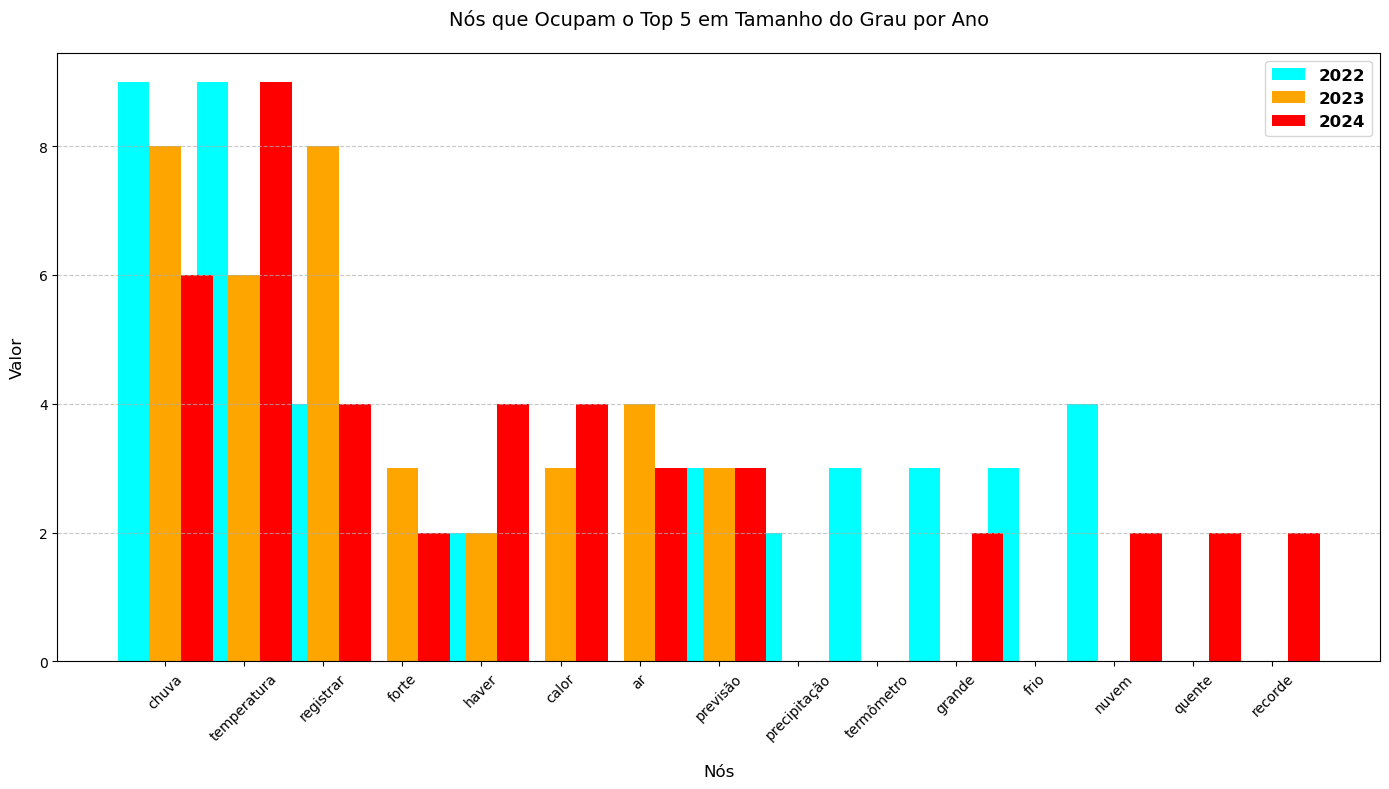

In [ ]:
nos_2022 = {
    "Nós": ["chuva", "temperatura", "registrar", "forte", "haver", "calor", "ar", "previsão", "precipitação", "termômetro", "grande", "frio", "nuvem", "quente", "recorde"],
    "Valor": [9, 9, 4, 0, 2, 0, 0, 3, 2, 3, 3, 3, 4, 0, 0]
}

nos_2023 = {
    "Nós": ["chuva", "temperatura", "registrar", "forte", "haver", "calor", "ar", "previsão", "precipitação", "termômetro", "grande", "frio", "nuvem", "quente", "recorde"],
    "Valor": [8, 6, 8, 3, 2, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0]
}

nos_2024 = {
    "Nós": ["chuva", "temperatura", "registrar", "forte", "haver", "calor", "ar", "previsão", "precipitação", "termômetro", "grande", "frio", "nuvem", "quente", "recorde"],
    "Valor": [6, 9, 4, 2, 4, 4, 3, 3, 0, 0, 2, 0, 2, 2, 2]
}

nodos = nos_2022["Nós"]
barWidth = 0.4


r1 = np.arange(len(nodos))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(14, 8))
plt.bar(r1, nos_2022["Valor"], color='#00FFFF', width=barWidth, label='2022')
plt.bar(r2, nos_2023["Valor"], color='orange', width=barWidth, label='2023')
plt.bar(r3, nos_2024["Valor"], color='red', width=barWidth, label='2024')

plt.xlabel('Nós', fontsize=12, labelpad=15)
plt.xticks([r + barWidth for r in range(len(nodos))], nodos, rotation=45, fontsize=10)
plt.ylabel('Valor', fontsize=12, labelpad=10)
plt.title('Nós que Ocupam o Top 5 em Tamanho do Grau por Ano', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(prop={'size': 12, 'weight': 'bold'}, loc='upper right')

plt.tight_layout()
plt.show()



# **Análise**

**2022 (cor ciano)**

- "Chuva" e "temperatura" tiveram o maior destaque, cada uma aparecendo 9 vezes no "Top 5" dos grafos de 2022. Esse padrão sugere que a precipitação e a temperatura foram temas recorrentes e de grande relevância nas notícias sobre o clima em São Paulo ao longo do ano de 2022.

- "Registrar" também apresenta uma alta frequência (4 vezes), indicando que o registro de eventos climáticos significativos foi tema comum.

- Termos como "ar", "previsão" e "termômetro" aparecem com valores intermediários, mostrando alguma importância, mas não tão consistente quanto os principais termos.

- "Frio" e "nuvem" se destacam ligeiramente, vale ressaltar que o nó "Frio" só aparece apenas nesse ano em comparação com outros indicando um ano com notícias de climas mais frios.

**2023 (cor laranja)**

- A tendência permanece para "chuva" e "registrar", com valores altos, mas ligeiramente menores do que em 2022, o que pode sugerir uma mudança de foco nos tópicos das notícias.

- Notamos o aumento na frequência de "forte" e "calor". Isso pode indicar que eventos climáticos intensos, como fortes tempestades ou ondas de calor, foram mais recorrentes nas publicações sobre clima nesse ano.

- "Haver", "ar" e "previsão" continuam a ter valores intermediários, o que mostra uma continuidade nos temas abordados em relação a previsões e condições atmosféricas.

**2024 (cor vermelha)**

- O destaque se mantém em "temperatura", com um alto valor de 9, semelhante a 2022, o que aponta uma preocupação persistente com a variação de temperatura ao longo dos anos.

- "Chuva" e "registrar" seguem relevantes, mas com uma frequência um pouco menor em comparação com os anos anteriores, o que pode sugerir uma leve mudança nos temas ou uma menor frequência de eventos significativos de chuva nas notícias desse ano.

- Termos como "calor, sendo mais relevante que em 2023 e termos como"quente" e "recorde" aparecem pela primeira vez com valores notáveis, o que pode indicar uma preocupação crescente com eventos climáticos extremos e recordes históricos de temperatura, sugerindo uma ênfase em eventos climáticos de intensidade incomum.


A alta frequência de "chuva" e "temperatura" ao longo dos anos reflete uma preocupação constante com a precipitação e as variações de temperatura, possivelmente relacionadas à experiência de fenômenos extremos ou mudanças sazonais significativas em São Paulo, Observamos, porém, uma tendência de queda na frequência de "chuva" entre 2022 e 2024, o que sugere que a cobertura sobre esse fenômeno diminuiu gradualmente. Em contraste, a atenção aos temas relacionados à intensidade climática aumentou. Com o passar dos anos, palavras como "forte", "calor", "grande" e "recorde" tornam-se mais frequentes, indicando que as notícias sobre o clima estão refletindo um aumento na percepção de eventos climáticos extremos, esse foco em intensidade e recordes pode estar alinhado com as mudanças climáticas globais e seus impactos percebidos localmente.

A recorrência de certos termos sugere que há uma preocupação da sociedade e da mídia com temas como o impacto das chuvas (possíveis enchentes ou problemas urbanos relacionados), bem como a variação de temperatura e sua relação com o conforto térmico e saúde da população.

Este gráfico revela não só as tendências anuais dos temas mais discutidos, mas também uma possível mudança gradual de foco nos assuntos de clima. O estudo sugere que a intensidade e frequência de eventos climáticos extremos (como chuvas fortes e recordes de temperatura) se tornaram tópicos de destaque especialmente em 2023 e 2024. Essa análise pode ajudar a identificar as principais preocupações climáticas ao longo dos anos e a entender melhor as mudanças nas discussões sobre o clima na metrópole paulista.

# **Conclusão**

As análises dos grafos de co-ocorrência oferecem uma visão aprofundada sobre as tendências e mudanças nas discussões climáticas ao longo dos anos. A centralidade de termos como "temperatura", "chuva", "calor" e "recorde" evidencia um foco crescente nas variações climáticas, especialmente em relação a eventos críticos e extremos. A recorrência de "temperatura" e "chuva" ao longo dos três anos reflete uma preocupação contínua com as condições meteorológicas em São Paulo, enquanto o aumento de palavras como "calor" e "recorde" nos grafos mais recentes sugere uma ênfase crescente em eventos climáticos intensos e inéditos.

A estrutura das comunidades dentro dos grafos permitiu identificar a inter-relação entre subtemas específicos, como condições atmosféricas, riscos de alagamentos, incidência de sol e nebulosidade. A formação de comunidades moderadamente definidas destaca temas como previsões meteorológicas, alertas de alagamento, sensação térmica e fenômenos sazonais, como rajadas de vento e chuvas intensas.

A análise desses grafos de co-ocorrência não apenas identificou os temas mais frequentes, mas também evidenciou uma evolução no foco das notícias climáticas ao longo dos anos. Observamos uma redução gradual na cobertura de temas como "chuva" entre 2022 e 2024, contrastada com uma maior atenção à intensidade dos fenômenos climáticos, como indica o aumento de palavras relacionadas a recordes e intensidade. Essa mudança sugere uma percepção crescente da sociedade e da mídia sobre os impactos das mudanças climáticas globais em São Paulo, com uma atenção maior para a frequência e intensidade de eventos extremos.